In [96]:
import keras
from keras.layers import Input, Conv1D,Activation,MaxPooling1D,Dense,Flatten,UpSampling1D
from keras.layers.normalization import BatchNormalization
from keras.models import Model,load_model
import tensorflow as tf
import numpy as np
from matplotlib.pyplot import plot
import matplotlib.pyplot as plt

In [129]:
def get_sub_model(myinputs,channel=3):
    x     = Conv1D(filters =16, kernel_size=5,strides = 1, padding = 'same')(myinputs)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = MaxPooling1D(pool_size=3,strides = 2,padding='same')(x)
    #  x shape is 64X48 =3072
    x     = Conv1D(filters =24, kernel_size=3,strides = 1, padding = 'same')(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = MaxPooling1D(pool_size=2,strides = 2,padding='same')(x)
    #  x shape is 32X64 = 2048
    x     = Conv1D(filters =32, kernel_size=3,strides = 1, padding = 'same')(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = MaxPooling1D(pool_size=2,strides = 2,padding='same')(x)
    # x shape is 16*96 = 1536
    x     = Conv1D(filters =32, kernel_size=3,strides = 1, padding = 'same')(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = MaxPooling1D(pool_size=2,strides = 2,padding='same')(x)
    # x shape is 8*128 = 1024
    x     = Conv1D(filters =48, kernel_size=3,strides = 2, padding = 'same')(x)
    # x shape is 4*128 = 512

    latent_vector = Flatten()(x)
    # decoder x = 4*128
    x     = Conv1D(filters =32, kernel_size=3,strides = 1, padding = 'same')(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = UpSampling1D(2)(x)
    # x shape is 8*128
    x     = Conv1D(filters =32, kernel_size=3,strides = 1, padding = 'same')(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = UpSampling1D(2)(x)
    # x shape is 16*96
    x     = Conv1D(filters =24, kernel_size=3,strides = 1, padding = 'same')(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = UpSampling1D(2)(x)
    # x shape is 32*64
    x     = Conv1D(filters =16, kernel_size=3,strides = 1, padding = 'same')(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = UpSampling1D(2)(x)
    # x shape is 64*48
    x     = Conv1D(filters =16, kernel_size=3,strides = 1, padding = 'same')(x)
    #x     = BatchNormalization()(x) 
    x     = Activation('relu')(x)
    x     = UpSampling1D(2)(x)
    # x shape is 128*48
    y     = Conv1D(filters =channel, kernel_size=3,strides = 1, padding = 'same')(x)
    return latent_vector,y

In [147]:
def build_model(name="push_detect",channel=3):
    # input shape 128X26 =3382
    with tf.name_scope(name):
        myInputs = Input(shape=(128,channel))
                
        LV,Y = get_sub_model(myInputs,channel=channel)
        
        autoencoder = Model (inputs=myInputs,
                             outputs =Y)
    
    return autoencoder

In [ ]:
gyroModel=build_model()
linearAccModel=build_model()
gravityModel=build_model()
gameVecModel=build_model(channel=4)


In [205]:
gyroModel=load_model('gyroModel.h5')
linearAccModel=load_model('linearAccModel.h5')
gravityModel=load_model('gravityModel.h5')
gameVecModel=load_model('gameVecModel.h5')


In [206]:
opt = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
gyroModel.compile(optimizer=opt,loss='mse',metrics=['accuracy'])
opt = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
linearAccModel.compile(optimizer=opt,loss='mse',metrics=['accuracy'])
opt = keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
gravityModel.compile(optimizer=opt,loss='mse',metrics=['accuracy'])
opt = keras.optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False)
gameVecModel.compile(optimizer=opt,loss='mse',metrics=['accuracy'])

In [193]:
data= np.load('watch.npy')
np.random.shuffle(data)
p=0.85
train_num =int(data.shape[0]*p)
gyro_train=data[:train_num,:,0:3]
linearAcc_train=data[:train_num,:,3:6]
gravity_train=data[:train_num,:,6:9]
gameVec_train=data[:train_num,:,9:13]

gyro_test =data[train_num:,:,0:3]
linearAcc_test =data[train_num:,:,3:6]
gravity_test =data[train_num:,:,6:9]
gameVec_test =data[train_num:,:,9:13]

In [219]:
for i in range(50):
    print('start training round '+str(i))
    print('training gyro model')
    gyroModel.fit(gyro_train,gyro_train,batch_size=256,epochs=50,validation_split=0.1)
    print('training linearAcc model')
    linearAccModel.fit(linearAcc_train,linearAcc_train,batch_size=256,epochs=50,validation_split=0.1)
    print('training gravity model')
    gravityModel.fit(gravity_train,gravity_train,batch_size=256,epochs=50,validation_split=0.1)
    print('training gameVec model')
    gameVecModel.fit(gameVec_train,gameVec_train,batch_size=256,epochs=50,validation_split=0.1)
    gyroModel.save('gyroModel.h5')
    linearAccModel.save('linearAccModel.h5')
    gravityModel.save('gravityModel.h5')
    gameVecModel.save('gameVecModel.h5')

start training round 0
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 3s 399us/step - loss: 0.2550 - acc: 0.6736 - val_loss: 0.2693 - val_acc: 0.6712
Epoch 2/50
8564/8564 [==============================] - 3s 381us/step - loss: 0.2529 - acc: 0.6751 - val_loss: 0.2632 - val_acc: 0.6737
Epoch 3/50
8564/8564 [==============================] - 3s 388us/step - loss: 0.2538 - acc: 0.6745 - val_loss: 0.2621 - val_acc: 0.6731
Epoch 4/50
8564/8564 [==============================] - 3s 383us/step - loss: 0.2568 - acc: 0.6747 - val_loss: 0.2658 - val_acc: 0.6728
Epoch 5/50
8564/8564 [==============================] - 3s 385us/step - loss: 0.2542 - acc: 0.6749 - val_loss: 0.2647 - val_acc: 0.6723
Epoch 6/50
8564/8564 [==============================] - 3s 390us/step - loss: 0.2539 - acc: 0.6744 - val_loss: 0.2636 - val_acc: 0.6750
Epoch 7/50
8564/8564 [==============================] - 3s 398us/step - loss: 0.2514 - acc: 0.

Epoch 10/50
8564/8564 [==============================] - 3s 389us/step - loss: 2.0438 - acc: 0.6751 - val_loss: 2.1511 - val_acc: 0.6713
Epoch 11/50
8564/8564 [==============================] - 3s 382us/step - loss: 2.0165 - acc: 0.6756 - val_loss: 2.2103 - val_acc: 0.6704
Epoch 12/50
8564/8564 [==============================] - 3s 375us/step - loss: 2.0629 - acc: 0.6754 - val_loss: 2.1315 - val_acc: 0.6739
Epoch 13/50
8564/8564 [==============================] - 3s 398us/step - loss: 2.0407 - acc: 0.6758 - val_loss: 2.1538 - val_acc: 0.6722
Epoch 14/50
8564/8564 [==============================] - 3s 372us/step - loss: 2.0351 - acc: 0.6760 - val_loss: 2.1733 - val_acc: 0.6735
Epoch 15/50
8564/8564 [==============================] - 3s 384us/step - loss: 2.0583 - acc: 0.6763 - val_loss: 2.1610 - val_acc: 0.6754
Epoch 16/50
8564/8564 [==============================] - 3s 368us/step - loss: 2.0521 - acc: 0.6748 - val_loss: 2.2116 - val_acc: 0.6740
Epoch 17/50
8564/8564 [==================

8564/8564 [==============================] - 3s 382us/step - loss: 0.2530 - acc: 0.9914 - val_loss: 0.2624 - val_acc: 0.9894
Epoch 20/50
8564/8564 [==============================] - 3s 385us/step - loss: 0.2362 - acc: 0.9918 - val_loss: 0.2341 - val_acc: 0.9894
Epoch 21/50
8564/8564 [==============================] - 3s 379us/step - loss: 0.2302 - acc: 0.9916 - val_loss: 0.2292 - val_acc: 0.9888
Epoch 22/50
8564/8564 [==============================] - 3s 391us/step - loss: 0.2276 - acc: 0.9908 - val_loss: 0.2333 - val_acc: 0.9879
Epoch 23/50
8564/8564 [==============================] - 3s 381us/step - loss: 0.2284 - acc: 0.9904 - val_loss: 0.2328 - val_acc: 0.9870
Epoch 24/50
8564/8564 [==============================] - 3s 386us/step - loss: 0.2259 - acc: 0.9905 - val_loss: 0.2298 - val_acc: 0.9879
Epoch 25/50
8564/8564 [==============================] - 3s 375us/step - loss: 0.2295 - acc: 0.9908 - val_loss: 0.2236 - val_acc: 0.9896
Epoch 26/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 408us/step - loss: 0.0036 - acc: 0.9525 - val_loss: 0.0035 - val_acc: 0.9602
Epoch 29/50
8564/8564 [==============================] - 3s 396us/step - loss: 0.0033 - acc: 0.9576 - val_loss: 0.0034 - val_acc: 0.9609
Epoch 30/50
8564/8564 [==============================] - 3s 394us/step - loss: 0.0034 - acc: 0.9553 - val_loss: 0.0035 - val_acc: 0.9604
Epoch 31/50
8564/8564 [==============================] - 3s 393us/step - loss: 0.0034 - acc: 0.9564 - val_loss: 0.0036 - val_acc: 0.9590
Epoch 32/50
8564/8564 [==============================] - 3s 394us/step - loss: 0.0035 - acc: 0.9527 - val_loss: 0.0035 - val_acc: 0.9608
Epoch 33/50
8564/8564 [==============================] - 3s 403us/step - loss: 0.0034 - acc: 0.9564 - val_loss: 0.0037 - val_acc: 0.9573
Epoch 34/50
8564/8564 [==============================] - 3s 399us/step - loss: 0.0035 - acc: 0.9546 - val_loss: 0.0035 - val_acc: 0.9617
Epoch 35/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 386us/step - loss: 0.2495 - acc: 0.6767 - val_loss: 0.2671 - val_acc: 0.6726
Epoch 38/50
8564/8564 [==============================] - 3s 407us/step - loss: 0.2519 - acc: 0.6757 - val_loss: 0.2632 - val_acc: 0.6754
Epoch 39/50
8564/8564 [==============================] - 3s 389us/step - loss: 0.2501 - acc: 0.6764 - val_loss: 0.2633 - val_acc: 0.6757
Epoch 40/50
8564/8564 [==============================] - 3s 386us/step - loss: 0.2501 - acc: 0.6776 - val_loss: 0.2642 - val_acc: 0.6756
Epoch 41/50
8564/8564 [==============================] - 3s 394us/step - loss: 0.2504 - acc: 0.6764 - val_loss: 0.2651 - val_acc: 0.6739
Epoch 42/50
8564/8564 [==============================] - 3s 387us/step - loss: 0.2524 - acc: 0.6762 - val_loss: 0.2663 - val_acc: 0.6752
Epoch 43/50
8564/8564 [==============================] - 3s 378us/step - loss: 0.2542 - acc: 0.6748 - val_loss: 0.2606 - val_acc: 0.6751
Epoch 44/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 389us/step - loss: 2.0162 - acc: 0.6757 - val_loss: 2.1357 - val_acc: 0.6740
Epoch 47/50
8564/8564 [==============================] - 3s 402us/step - loss: 2.0357 - acc: 0.6760 - val_loss: 2.1278 - val_acc: 0.6735
Epoch 48/50
8564/8564 [==============================] - 3s 384us/step - loss: 2.0127 - acc: 0.6764 - val_loss: 2.1342 - val_acc: 0.6726
Epoch 49/50
8564/8564 [==============================] - 3s 392us/step - loss: 2.0008 - acc: 0.6759 - val_loss: 2.1205 - val_acc: 0.6741
Epoch 50/50
8564/8564 [==============================] - 3s 382us/step - loss: 2.0066 - acc: 0.6765 - val_loss: 2.1310 - val_acc: 0.6735
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 3s 388us/step - loss: 0.2277 - acc: 0.9904 - val_loss: 0.2241 - val_acc: 0.9889
Epoch 2/50
8564/8564 [==============================] - 3s 397us/step - loss: 0.2333 - acc: 0.9907 - val_loss: 0.2598 - v

Epoch 5/50
8564/8564 [==============================] - 3s 394us/step - loss: 0.0034 - acc: 0.9566 - val_loss: 0.0036 - val_acc: 0.9572
Epoch 6/50
8564/8564 [==============================] - 3s 391us/step - loss: 0.0035 - acc: 0.9551 - val_loss: 0.0039 - val_acc: 0.9516
Epoch 7/50
8564/8564 [==============================] - 3s 376us/step - loss: 0.0035 - acc: 0.9531 - val_loss: 0.0036 - val_acc: 0.9584
Epoch 8/50
8564/8564 [==============================] - 3s 391us/step - loss: 0.0036 - acc: 0.9532 - val_loss: 0.0035 - val_acc: 0.9619
Epoch 9/50
8564/8564 [==============================] - 3s 389us/step - loss: 0.0034 - acc: 0.9573 - val_loss: 0.0035 - val_acc: 0.9602
Epoch 10/50
8564/8564 [==============================] - 3s 387us/step - loss: 0.0034 - acc: 0.9572 - val_loss: 0.0034 - val_acc: 0.9614
Epoch 11/50
8564/8564 [==============================] - 3s 375us/step - loss: 0.0033 - acc: 0.9578 - val_loss: 0.0034 - val_acc: 0.9599
Epoch 12/50
8564/8564 [=======================

8564/8564 [==============================] - 3s 377us/step - loss: 0.2501 - acc: 0.6757 - val_loss: 0.2658 - val_acc: 0.6732
Epoch 15/50
8564/8564 [==============================] - 3s 385us/step - loss: 0.2540 - acc: 0.6751 - val_loss: 0.2646 - val_acc: 0.6753
Epoch 16/50
8564/8564 [==============================] - 3s 378us/step - loss: 0.2513 - acc: 0.6772 - val_loss: 0.2608 - val_acc: 0.6765
Epoch 17/50
8564/8564 [==============================] - 3s 392us/step - loss: 0.2507 - acc: 0.6774 - val_loss: 0.2632 - val_acc: 0.6752
Epoch 18/50
8564/8564 [==============================] - 3s 382us/step - loss: 0.2501 - acc: 0.6775 - val_loss: 0.2684 - val_acc: 0.6720
Epoch 19/50
8564/8564 [==============================] - 3s 387us/step - loss: 0.2517 - acc: 0.6758 - val_loss: 0.2621 - val_acc: 0.6754
Epoch 20/50
8564/8564 [==============================] - 3s 399us/step - loss: 0.2525 - acc: 0.6766 - val_loss: 0.2627 - val_acc: 0.6748
Epoch 21/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 381us/step - loss: 2.0155 - acc: 0.6752 - val_loss: 2.2238 - val_acc: 0.6732
Epoch 24/50
8564/8564 [==============================] - 3s 391us/step - loss: 2.0406 - acc: 0.6756 - val_loss: 2.2168 - val_acc: 0.6740
Epoch 25/50
8564/8564 [==============================] - 3s 384us/step - loss: 2.0428 - acc: 0.6757 - val_loss: 2.1610 - val_acc: 0.6764
Epoch 26/50
8564/8564 [==============================] - 3s 388us/step - loss: 2.0115 - acc: 0.6761 - val_loss: 2.1361 - val_acc: 0.6748
Epoch 27/50
8564/8564 [==============================] - 3s 381us/step - loss: 2.0315 - acc: 0.6752 - val_loss: 2.2539 - val_acc: 0.6664
Epoch 28/50
8564/8564 [==============================] - 3s 395us/step - loss: 2.0488 - acc: 0.6752 - val_loss: 2.1393 - val_acc: 0.6737
Epoch 29/50
8564/8564 [==============================] - 3s 371us/step - loss: 2.0260 - acc: 0.6765 - val_loss: 2.1987 - val_acc: 0.6724
Epoch 30/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 375us/step - loss: 0.2243 - acc: 0.9911 - val_loss: 0.2472 - val_acc: 0.9871
Epoch 33/50
8564/8564 [==============================] - 3s 376us/step - loss: 0.2365 - acc: 0.9907 - val_loss: 0.2323 - val_acc: 0.9891
Epoch 34/50
8564/8564 [==============================] - 3s 380us/step - loss: 0.2266 - acc: 0.9918 - val_loss: 0.2268 - val_acc: 0.9897
Epoch 35/50
8564/8564 [==============================] - 3s 385us/step - loss: 0.2287 - acc: 0.9918 - val_loss: 0.2286 - val_acc: 0.9896
Epoch 36/50
8564/8564 [==============================] - 3s 374us/step - loss: 0.2241 - acc: 0.9919 - val_loss: 0.2174 - val_acc: 0.9897
Epoch 37/50
8564/8564 [==============================] - 3s 377us/step - loss: 0.2110 - acc: 0.9919 - val_loss: 0.2090 - val_acc: 0.9897
Epoch 38/50
8564/8564 [==============================] - 3s 370us/step - loss: 0.2092 - acc: 0.9920 - val_loss: 0.2155 - val_acc: 0.9895
Epoch 39/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 401us/step - loss: 0.0036 - acc: 0.9515 - val_loss: 0.0034 - val_acc: 0.9597
Epoch 42/50
8564/8564 [==============================] - 3s 402us/step - loss: 0.0033 - acc: 0.9578 - val_loss: 0.0034 - val_acc: 0.9607
Epoch 43/50
8564/8564 [==============================] - 3s 400us/step - loss: 0.0034 - acc: 0.9572 - val_loss: 0.0035 - val_acc: 0.9587
Epoch 44/50
8564/8564 [==============================] - 3s 387us/step - loss: 0.0034 - acc: 0.9570 - val_loss: 0.0035 - val_acc: 0.9603
Epoch 45/50
8564/8564 [==============================] - 3s 390us/step - loss: 0.0034 - acc: 0.9578 - val_loss: 0.0035 - val_acc: 0.9605
Epoch 46/50
8564/8564 [==============================] - ETA: 0s - loss: 0.0034 - acc: 0.957 - 3s 390us/step - loss: 0.0034 - acc: 0.9570 - val_loss: 0.0035 - val_acc: 0.9591
Epoch 47/50
8564/8564 [==============================] - 3s 387us/step - loss: 0.0033 - acc: 0.9577 - val_loss: 0.0035 - val_acc: 0.9574
Epoch 48/50
856

8564/8564 [==============================] - 3s 382us/step - loss: 0.2502 - acc: 0.6786 - val_loss: 0.2618 - val_acc: 0.6750
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 3s 378us/step - loss: 2.0377 - acc: 0.6751 - val_loss: 2.1080 - val_acc: 0.6720
Epoch 2/50
8564/8564 [==============================] - 3s 379us/step - loss: 2.0124 - acc: 0.6757 - val_loss: 2.2855 - val_acc: 0.6662
Epoch 3/50
8564/8564 [==============================] - 3s 381us/step - loss: 2.0345 - acc: 0.6757 - val_loss: 2.1452 - val_acc: 0.6763
Epoch 4/50
8564/8564 [==============================] - 3s 383us/step - loss: 2.0346 - acc: 0.6757 - val_loss: 2.1260 - val_acc: 0.6768
Epoch 5/50
8564/8564 [==============================] - 3s 378us/step - loss: 2.0120 - acc: 0.6764 - val_loss: 2.1182 - val_acc: 0.6757
Epoch 6/50
8564/8564 [==============================] - 3s 377us/step - loss: 2.0049 - acc: 0.6766 - val_loss: 2.1188 - val

Epoch 9/50
8564/8564 [==============================] - 3s 395us/step - loss: 0.2210 - acc: 0.9920 - val_loss: 0.2340 - val_acc: 0.9895
Epoch 10/50
8564/8564 [==============================] - 3s 387us/step - loss: 0.2256 - acc: 0.9914 - val_loss: 0.2409 - val_acc: 0.9892
Epoch 11/50
8564/8564 [==============================] - 3s 378us/step - loss: 0.2208 - acc: 0.9917 - val_loss: 0.2153 - val_acc: 0.9895
Epoch 12/50
8564/8564 [==============================] - 3s 384us/step - loss: 0.2109 - acc: 0.9919 - val_loss: 0.2208 - val_acc: 0.9897
Epoch 13/50
8564/8564 [==============================] - 3s 383us/step - loss: 0.2302 - acc: 0.9918 - val_loss: 0.2258 - val_acc: 0.9897
Epoch 14/50
8564/8564 [==============================] - 3s 380us/step - loss: 0.2262 - acc: 0.9919 - val_loss: 0.2263 - val_acc: 0.9897
Epoch 15/50
8564/8564 [==============================] - 3s 375us/step - loss: 0.2146 - acc: 0.9920 - val_loss: 0.2085 - val_acc: 0.9897
Epoch 16/50
8564/8564 [===================

8564/8564 [==============================] - 3s 403us/step - loss: 0.0034 - acc: 0.9564 - val_loss: 0.0035 - val_acc: 0.9599
Epoch 19/50
8564/8564 [==============================] - 3s 393us/step - loss: 0.0034 - acc: 0.9557 - val_loss: 0.0036 - val_acc: 0.9560
Epoch 20/50
8564/8564 [==============================] - 4s 409us/step - loss: 0.0035 - acc: 0.9546 - val_loss: 0.0036 - val_acc: 0.9538
Epoch 21/50
8564/8564 [==============================] - 3s 399us/step - loss: 0.0037 - acc: 0.9487 - val_loss: 0.0034 - val_acc: 0.9606
Epoch 22/50
8564/8564 [==============================] - 3s 386us/step - loss: 0.0033 - acc: 0.9579 - val_loss: 0.0035 - val_acc: 0.9616
Epoch 23/50
8564/8564 [==============================] - 3s 392us/step - loss: 0.0034 - acc: 0.9552 - val_loss: 0.0034 - val_acc: 0.9619
Epoch 24/50
8564/8564 [==============================] - 3s 402us/step - loss: 0.0034 - acc: 0.9553 - val_loss: 0.0039 - val_acc: 0.9497
Epoch 25/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 382us/step - loss: 0.2500 - acc: 0.6777 - val_loss: 0.2630 - val_acc: 0.6761
Epoch 28/50
8564/8564 [==============================] - 3s 377us/step - loss: 0.2472 - acc: 0.6777 - val_loss: 0.2585 - val_acc: 0.6772
Epoch 29/50
8564/8564 [==============================] - 3s 381us/step - loss: 0.2470 - acc: 0.6785 - val_loss: 0.2601 - val_acc: 0.6771
Epoch 30/50
8564/8564 [==============================] - 3s 380us/step - loss: 0.2493 - acc: 0.6787 - val_loss: 0.2612 - val_acc: 0.6767
Epoch 31/50
8564/8564 [==============================] - 3s 381us/step - loss: 0.2456 - acc: 0.6799 - val_loss: 0.2561 - val_acc: 0.6776
Epoch 32/50
8564/8564 [==============================] - 3s 380us/step - loss: 0.2436 - acc: 0.6801 - val_loss: 0.2607 - val_acc: 0.6780
Epoch 33/50
8564/8564 [==============================] - 3s 384us/step - loss: 0.2491 - acc: 0.6779 - val_loss: 0.2683 - val_acc: 0.6755
Epoch 34/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 390us/step - loss: 2.0422 - acc: 0.6755 - val_loss: 2.2467 - val_acc: 0.6680
Epoch 37/50
8564/8564 [==============================] - 3s 386us/step - loss: 2.0145 - acc: 0.6775 - val_loss: 2.2068 - val_acc: 0.6737
Epoch 38/50
8564/8564 [==============================] - 3s 398us/step - loss: 2.0195 - acc: 0.6771 - val_loss: 2.1346 - val_acc: 0.6742
Epoch 39/50
8564/8564 [==============================] - 3s 391us/step - loss: 1.9970 - acc: 0.6766 - val_loss: 2.1009 - val_acc: 0.6765
Epoch 40/50
8564/8564 [==============================] - 3s 385us/step - loss: 2.0100 - acc: 0.6763 - val_loss: 2.1490 - val_acc: 0.6723
Epoch 41/50
8564/8564 [==============================] - 3s 385us/step - loss: 2.0263 - acc: 0.6763 - val_loss: 2.2323 - val_acc: 0.6692
Epoch 42/50
8564/8564 [==============================] - 3s 387us/step - loss: 2.0215 - acc: 0.6766 - val_loss: 2.1157 - val_acc: 0.6757
Epoch 43/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 385us/step - loss: 0.2009 - acc: 0.9918 - val_loss: 0.2085 - val_acc: 0.9892
Epoch 46/50
8564/8564 [==============================] - 3s 384us/step - loss: 0.2225 - acc: 0.9911 - val_loss: 0.2275 - val_acc: 0.9896
Epoch 47/50
8564/8564 [==============================] - 3s 387us/step - loss: 0.2286 - acc: 0.9920 - val_loss: 0.2234 - val_acc: 0.9896
Epoch 48/50
8564/8564 [==============================] - 3s 380us/step - loss: 0.2193 - acc: 0.9916 - val_loss: 0.2193 - val_acc: 0.9892ss: 0.2203
Epoch 49/50
8564/8564 [==============================] - 3s 385us/step - loss: 0.2102 - acc: 0.9918 - val_loss: 0.2165 - val_acc: 0.9896
Epoch 50/50
8564/8564 [==============================] - 3s 379us/step - loss: 0.2144 - acc: 0.9918 - val_loss: 0.2101 - val_acc: 0.9895
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 3s 404us/step - loss: 0.0033 - acc: 0.9579 - val_loss:

Epoch 4/50
8564/8564 [==============================] - 3s 382us/step - loss: 0.2467 - acc: 0.6791 - val_loss: 0.2665 - val_acc: 0.6750
Epoch 5/50
8564/8564 [==============================] - 3s 385us/step - loss: 0.2471 - acc: 0.6791 - val_loss: 0.2582 - val_acc: 0.6767
Epoch 6/50
8564/8564 [==============================] - 3s 388us/step - loss: 0.2461 - acc: 0.6784 - val_loss: 0.2639 - val_acc: 0.6716
Epoch 7/50
8564/8564 [==============================] - 3s 386us/step - loss: 0.2471 - acc: 0.6788 - val_loss: 0.2606 - val_acc: 0.6776
Epoch 8/50
8564/8564 [==============================] - 3s 392us/step - loss: 0.2463 - acc: 0.6795 - val_loss: 0.2606 - val_acc: 0.6752
Epoch 9/50
8564/8564 [==============================] - 3s 386us/step - loss: 0.2476 - acc: 0.6785 - val_loss: 0.2656 - val_acc: 0.6756
Epoch 10/50
8564/8564 [==============================] - 3s 385us/step - loss: 0.2497 - acc: 0.6782 - val_loss: 0.2622 - val_acc: 0.6766
Epoch 11/50
8564/8564 [========================

8564/8564 [==============================] - 3s 386us/step - loss: 1.9977 - acc: 0.6778 - val_loss: 2.1432 - val_acc: 0.6744
Epoch 14/50
8564/8564 [==============================] - 3s 392us/step - loss: 2.0244 - acc: 0.6766 - val_loss: 2.1285 - val_acc: 0.6754
Epoch 15/50
8564/8564 [==============================] - 3s 388us/step - loss: 1.9966 - acc: 0.6762 - val_loss: 2.2887 - val_acc: 0.6735
Epoch 16/50
8564/8564 [==============================] - 3s 387us/step - loss: 2.0432 - acc: 0.6759 - val_loss: 2.1127 - val_acc: 0.6756
Epoch 17/50
8564/8564 [==============================] - 3s 389us/step - loss: 1.9998 - acc: 0.6761 - val_loss: 2.1335 - val_acc: 0.6741
Epoch 18/50
8564/8564 [==============================] - 3s 387us/step - loss: 2.0417 - acc: 0.6761 - val_loss: 2.2088 - val_acc: 0.6713
Epoch 19/50
8564/8564 [==============================] - 3s 395us/step - loss: 2.0092 - acc: 0.6767 - val_loss: 2.1536 - val_acc: 0.6719
Epoch 20/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 406us/step - loss: 0.2140 - acc: 0.9919 - val_loss: 0.2133 - val_acc: 0.9897
Epoch 23/50
8564/8564 [==============================] - 3s 385us/step - loss: 0.2066 - acc: 0.9920 - val_loss: 0.2039 - val_acc: 0.9898
Epoch 24/50
8564/8564 [==============================] - 3s 378us/step - loss: 0.2048 - acc: 0.9920 - val_loss: 0.2094 - val_acc: 0.9896
Epoch 25/50
8564/8564 [==============================] - 3s 392us/step - loss: 0.2137 - acc: 0.9920 - val_loss: 0.2144 - val_acc: 0.9896
Epoch 26/50
8564/8564 [==============================] - 3s 382us/step - loss: 0.2071 - acc: 0.9918 - val_loss: 0.2193 - val_acc: 0.9895
Epoch 27/50
8564/8564 [==============================] - 3s 388us/step - loss: 0.2159 - acc: 0.9916 - val_loss: 0.2191 - val_acc: 0.9896
Epoch 28/50
8564/8564 [==============================] - 3s 374us/step - loss: 0.2277 - acc: 0.9919 - val_loss: 0.2473 - val_acc: 0.9893
Epoch 29/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 392us/step - loss: 0.0033 - acc: 0.9557 - val_loss: 0.0035 - val_acc: 0.9582
Epoch 32/50
8564/8564 [==============================] - 3s 404us/step - loss: 0.0033 - acc: 0.9562 - val_loss: 0.0034 - val_acc: 0.9611
Epoch 33/50
8564/8564 [==============================] - 4s 419us/step - loss: 0.0033 - acc: 0.9582 - val_loss: 0.0034 - val_acc: 0.9598
Epoch 34/50
8564/8564 [==============================] - 3s 388us/step - loss: 0.0035 - acc: 0.9525 - val_loss: 0.0036 - val_acc: 0.9567
Epoch 35/50
8564/8564 [==============================] - 3s 388us/step - loss: 0.0033 - acc: 0.9570 - val_loss: 0.0035 - val_acc: 0.9588
Epoch 36/50
8564/8564 [==============================] - 3s 398us/step - loss: 0.0033 - acc: 0.9581 - val_loss: 0.0034 - val_acc: 0.9612
Epoch 37/50
8564/8564 [==============================] - 3s 398us/step - loss: 0.0034 - acc: 0.9571 - val_loss: 0.0034 - val_acc: 0.9601
Epoch 38/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 390us/step - loss: 0.2443 - acc: 0.6804 - val_loss: 0.2635 - val_acc: 0.6757
Epoch 41/50
8564/8564 [==============================] - 3s 389us/step - loss: 0.2473 - acc: 0.6783 - val_loss: 0.2585 - val_acc: 0.6758
Epoch 42/50
8564/8564 [==============================] - 3s 393us/step - loss: 0.2422 - acc: 0.6812 - val_loss: 0.2563 - val_acc: 0.6782
Epoch 43/50
8564/8564 [==============================] - 3s 389us/step - loss: 0.2446 - acc: 0.6802 - val_loss: 0.2548 - val_acc: 0.6793
Epoch 44/50
8564/8564 [==============================] - 3s 380us/step - loss: 0.2461 - acc: 0.6801 - val_loss: 0.2588 - val_acc: 0.6779
Epoch 45/50
8564/8564 [==============================] - 3s 390us/step - loss: 0.2450 - acc: 0.6802 - val_loss: 0.2560 - val_acc: 0.6783
Epoch 46/50
8564/8564 [==============================] - 3s 392us/step - loss: 0.2457 - acc: 0.6811 - val_loss: 0.2658 - val_acc: 0.6743
Epoch 47/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 390us/step - loss: 1.9961 - acc: 0.6769 - val_loss: 2.1481 - val_acc: 0.6701
Epoch 50/50
8564/8564 [==============================] - 3s 386us/step - loss: 2.0253 - acc: 0.6768 - val_loss: 2.0948 - val_acc: 0.6755
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 3s 384us/step - loss: 0.2048 - acc: 0.9919 - val_loss: 0.2085 - val_acc: 0.9897
Epoch 2/50
8564/8564 [==============================] - 3s 405us/step - loss: 0.2124 - acc: 0.9921 - val_loss: 0.2135 - val_acc: 0.9897
Epoch 3/50
8564/8564 [==============================] - 3s 391us/step - loss: 0.2104 - acc: 0.9920 - val_loss: 0.2266 - val_acc: 0.9898
Epoch 4/50
8564/8564 [==============================] - 3s 381us/step - loss: 0.2359 - acc: 0.9918 - val_loss: 0.2546 - val_acc: 0.9885
Epoch 5/50
8564/8564 [==============================] - 3s 398us/step - loss: 0.2263 - acc: 0.9916 - val_loss: 0.2249 - val_

Epoch 8/50
8564/8564 [==============================] - 3s 406us/step - loss: 0.0033 - acc: 0.9575 - val_loss: 0.0036 - val_acc: 0.9616
Epoch 9/50
8564/8564 [==============================] - 3s 392us/step - loss: 0.0035 - acc: 0.9532 - val_loss: 0.0036 - val_acc: 0.9577
Epoch 10/50
8564/8564 [==============================] - 3s 394us/step - loss: 0.0034 - acc: 0.9565 - val_loss: 0.0035 - val_acc: 0.9619
Epoch 11/50
8564/8564 [==============================] - 4s 424us/step - loss: 0.0034 - acc: 0.9565 - val_loss: 0.0034 - val_acc: 0.9618
Epoch 12/50
8564/8564 [==============================] - 3s 400us/step - loss: 0.0033 - acc: 0.9586 - val_loss: 0.0034 - val_acc: 0.9615
Epoch 13/50
8564/8564 [==============================] - 3s 398us/step - loss: 0.0033 - acc: 0.9577 - val_loss: 0.0033 - val_acc: 0.9615
Epoch 14/50
8564/8564 [==============================] - 3s 386us/step - loss: 0.0034 - acc: 0.9541 - val_loss: 0.0035 - val_acc: 0.9532
Epoch 15/50
8564/8564 [====================

8564/8564 [==============================] - 3s 381us/step - loss: 0.2452 - acc: 0.6796 - val_loss: 0.2561 - val_acc: 0.6790
Epoch 18/50
8564/8564 [==============================] - 3s 389us/step - loss: 0.2435 - acc: 0.6805 - val_loss: 0.2530 - val_acc: 0.6794
Epoch 19/50
8564/8564 [==============================] - 3s 392us/step - loss: 0.2416 - acc: 0.6820 - val_loss: 0.2594 - val_acc: 0.6804
Epoch 20/50
8564/8564 [==============================] - 3s 393us/step - loss: 0.2482 - acc: 0.6812 - val_loss: 0.2540 - val_acc: 0.6799
Epoch 21/50
8564/8564 [==============================] - 3s 390us/step - loss: 0.2406 - acc: 0.6822 - val_loss: 0.2543 - val_acc: 0.6799
Epoch 22/50
8564/8564 [==============================] - 4s 410us/step - loss: 0.2436 - acc: 0.6810 - val_loss: 0.2601 - val_acc: 0.6755
Epoch 23/50
8564/8564 [==============================] - 3s 397us/step - loss: 0.2436 - acc: 0.6797 - val_loss: 0.2569 - val_acc: 0.6770
Epoch 24/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 389us/step - loss: 2.0176 - acc: 0.6767 - val_loss: 2.2307 - val_acc: 0.6749
Epoch 27/50
8564/8564 [==============================] - 3s 378us/step - loss: 2.0322 - acc: 0.6779 - val_loss: 2.0965 - val_acc: 0.6769
Epoch 28/50
8564/8564 [==============================] - 3s 390us/step - loss: 1.9768 - acc: 0.6780 - val_loss: 2.1155 - val_acc: 0.6747
Epoch 29/50
8564/8564 [==============================] - 3s 377us/step - loss: 2.0157 - acc: 0.6761 - val_loss: 2.1917 - val_acc: 0.6740
Epoch 30/50
8564/8564 [==============================] - 3s 385us/step - loss: 2.0200 - acc: 0.6769 - val_loss: 2.1247 - val_acc: 0.6739
Epoch 31/50
8564/8564 [==============================] - 3s 392us/step - loss: 2.0135 - acc: 0.6774 - val_loss: 2.1373 - val_acc: 0.6739
Epoch 32/50
8564/8564 [==============================] - 3s 383us/step - loss: 2.0383 - acc: 0.6781 - val_loss: 2.1076 - val_acc: 0.6751
Epoch 33/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 393us/step - loss: 0.2121 - acc: 0.9907 - val_loss: 0.2080 - val_acc: 0.9894
Epoch 36/50
8564/8564 [==============================] - 3s 388us/step - loss: 0.2221 - acc: 0.9918 - val_loss: 0.2232 - val_acc: 0.9898
Epoch 37/50
8564/8564 [==============================] - 3s 377us/step - loss: 0.2301 - acc: 0.9921 - val_loss: 0.2142 - val_acc: 0.9898
Epoch 38/50
8564/8564 [==============================] - 3s 393us/step - loss: 0.2049 - acc: 0.9921 - val_loss: 0.1978 - val_acc: 0.9898
Epoch 39/50
8564/8564 [==============================] - 3s 383us/step - loss: 0.1941 - acc: 0.9921 - val_loss: 0.1955 - val_acc: 0.9900
Epoch 40/50
8564/8564 [==============================] - 3s 388us/step - loss: 0.1965 - acc: 0.9921 - val_loss: 0.2115 - val_acc: 0.9898
Epoch 41/50
8564/8564 [==============================] - 3s 394us/step - loss: 0.2198 - acc: 0.9921 - val_loss: 0.2088 - val_acc: 0.9899
Epoch 42/50
8564/8564 [==============================

8564/8564 [==============================] - 4s 422us/step - loss: 0.0032 - acc: 0.9584 - val_loss: 0.0034 - val_acc: 0.9626
Epoch 45/50
8564/8564 [==============================] - 4s 414us/step - loss: 0.0032 - acc: 0.9583 - val_loss: 0.0036 - val_acc: 0.9566
Epoch 46/50
8564/8564 [==============================] - 3s 395us/step - loss: 0.0033 - acc: 0.9554 - val_loss: 0.0036 - val_acc: 0.9521
Epoch 47/50
8564/8564 [==============================] - 3s 390us/step - loss: 0.0034 - acc: 0.9516 - val_loss: 0.0033 - val_acc: 0.9602
Epoch 48/50
8564/8564 [==============================] - 3s 405us/step - loss: 0.0032 - acc: 0.9585 - val_loss: 0.0033 - val_acc: 0.9607
Epoch 49/50
8564/8564 [==============================] - 3s 399us/step - loss: 0.0033 - acc: 0.9573 - val_loss: 0.0035 - val_acc: 0.9584
Epoch 50/50
8564/8564 [==============================] - 3s 401us/step - loss: 0.0035 - acc: 0.9538 - val_loss: 0.0036 - val_acc: 0.9532
start training round 8
training gyro model
Train on 8

Epoch 3/50
8564/8564 [==============================] - 3s 384us/step - loss: 2.0063 - acc: 0.6776 - val_loss: 2.1384 - val_acc: 0.6765
Epoch 4/50
8564/8564 [==============================] - 3s 387us/step - loss: 2.0201 - acc: 0.6769 - val_loss: 2.1913 - val_acc: 0.6728
Epoch 5/50
8564/8564 [==============================] - 3s 387us/step - loss: 2.0191 - acc: 0.6768 - val_loss: 2.0980 - val_acc: 0.6757
Epoch 6/50
8564/8564 [==============================] - ETA: 0s - loss: 1.9736 - acc: 0.677 - 3s 388us/step - loss: 1.9726 - acc: 0.6771 - val_loss: 2.1366 - val_acc: 0.6777
Epoch 7/50
8564/8564 [==============================] - 3s 398us/step - loss: 2.0028 - acc: 0.6776 - val_loss: 2.2107 - val_acc: 0.6769
Epoch 8/50
8564/8564 [==============================] - 3s 394us/step - loss: 2.0492 - acc: 0.6772 - val_loss: 2.1512 - val_acc: 0.6740
Epoch 9/50
8564/8564 [==============================] - 3s 380us/step - loss: 1.9850 - acc: 0.6782 - val_loss: 2.1498 - val_acc: 0.6723
Epoch 10/5

8564/8564 [==============================] - 3s 365us/step - loss: 0.1992 - acc: 0.9918 - val_loss: 0.2070 - val_acc: 0.9897
Epoch 13/50
8564/8564 [==============================] - 3s 385us/step - loss: 0.2139 - acc: 0.9919 - val_loss: 0.2326 - val_acc: 0.9899
Epoch 14/50
8564/8564 [==============================] - 3s 387us/step - loss: 0.2342 - acc: 0.9919 - val_loss: 0.2110 - val_acc: 0.9894
Epoch 15/50
8564/8564 [==============================] - 3s 376us/step - loss: 0.2029 - acc: 0.9916 - val_loss: 0.2064 - val_acc: 0.9894
Epoch 16/50
8564/8564 [==============================] - 3s 384us/step - loss: 0.2036 - acc: 0.9912 - val_loss: 0.2064 - val_acc: 0.9892
Epoch 17/50
8564/8564 [==============================] - 3s 395us/step - loss: 0.1970 - acc: 0.9917 - val_loss: 0.2016 - val_acc: 0.9893
Epoch 18/50
8564/8564 [==============================] - 3s 386us/step - loss: 0.2073 - acc: 0.9918 - val_loss: 0.2227 - val_acc: 0.9899
Epoch 19/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 385us/step - loss: 0.0034 - acc: 0.9556 - val_loss: 0.0035 - val_acc: 0.9571
Epoch 22/50
8564/8564 [==============================] - 3s 391us/step - loss: 0.0033 - acc: 0.9563 - val_loss: 0.0033 - val_acc: 0.9606
Epoch 23/50
8564/8564 [==============================] - 3s 408us/step - loss: 0.0033 - acc: 0.9568 - val_loss: 0.0043 - val_acc: 0.9416
Epoch 24/50
8564/8564 [==============================] - 3s 409us/step - loss: 0.0036 - acc: 0.9508 - val_loss: 0.0034 - val_acc: 0.9607
Epoch 25/50
8564/8564 [==============================] - 3s 404us/step - loss: 0.0033 - acc: 0.9571 - val_loss: 0.0033 - val_acc: 0.9610
Epoch 26/50
8564/8564 [==============================] - 4s 421us/step - loss: 0.0034 - acc: 0.9532 - val_loss: 0.0033 - val_acc: 0.9614
Epoch 27/50
8564/8564 [==============================] - 3s 408us/step - loss: 0.0032 - acc: 0.9587 - val_loss: 0.0033 - val_acc: 0.9603
Epoch 28/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 377us/step - loss: 0.2405 - acc: 0.6828 - val_loss: 0.2564 - val_acc: 0.6776
Epoch 31/50
8564/8564 [==============================] - 3s 395us/step - loss: 0.2448 - acc: 0.6804 - val_loss: 0.2557 - val_acc: 0.6783
Epoch 32/50
8564/8564 [==============================] - 3s 374us/step - loss: 0.2394 - acc: 0.6831 - val_loss: 0.2549 - val_acc: 0.6804
Epoch 33/50
8564/8564 [==============================] - 3s 377us/step - loss: 0.2420 - acc: 0.6821 - val_loss: 0.2621 - val_acc: 0.6788
Epoch 34/50
8564/8564 [==============================] - 3s 383us/step - loss: 0.2430 - acc: 0.6820 - val_loss: 0.2537 - val_acc: 0.6799
Epoch 35/50
8564/8564 [==============================] - 3s 375us/step - loss: 0.2418 - acc: 0.6829 - val_loss: 0.2562 - val_acc: 0.6813
Epoch 36/50
8564/8564 [==============================] - 3s 387us/step - loss: 0.2459 - acc: 0.6808 - val_loss: 0.2570 - val_acc: 0.6792
Epoch 37/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 383us/step - loss: 2.0210 - acc: 0.6777 - val_loss: 2.0923 - val_acc: 0.6776
Epoch 40/50
8564/8564 [==============================] - 3s 386us/step - loss: 1.9705 - acc: 0.6786 - val_loss: 2.1531 - val_acc: 0.6724
Epoch 41/50
8564/8564 [==============================] - 3s 386us/step - loss: 1.9890 - acc: 0.6776 - val_loss: 2.0887 - val_acc: 0.6744
Epoch 42/50
8564/8564 [==============================] - 3s 381us/step - loss: 2.0095 - acc: 0.6770 - val_loss: 2.1618 - val_acc: 0.6760
Epoch 43/50
8564/8564 [==============================] - 3s 370us/step - loss: 2.0327 - acc: 0.6776 - val_loss: 2.1197 - val_acc: 0.6742
Epoch 44/50
8564/8564 [==============================] - 3s 384us/step - loss: 1.9959 - acc: 0.6779 - val_loss: 2.0862 - val_acc: 0.6756
Epoch 45/50
8564/8564 [==============================] - 3s 380us/step - loss: 1.9827 - acc: 0.6778 - val_loss: 2.1223 - val_acc: 0.6766
Epoch 46/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 382us/step - loss: 0.2018 - acc: 0.9913 - val_loss: 0.2050 - val_acc: 0.9891
Epoch 49/50
8564/8564 [==============================] - 3s 382us/step - loss: 0.2001 - acc: 0.9916 - val_loss: 0.2027 - val_acc: 0.9896
Epoch 50/50
8564/8564 [==============================] - 3s 391us/step - loss: 0.2062 - acc: 0.9910 - val_loss: 0.2174 - val_acc: 0.9888
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 3s 388us/step - loss: 0.0033 - acc: 0.9549 - val_loss: 0.0034 - val_acc: 0.9583
Epoch 2/50
8564/8564 [==============================] - 3s 403us/step - loss: 0.0032 - acc: 0.9585 - val_loss: 0.0033 - val_acc: 0.9618
Epoch 3/50
8564/8564 [==============================] - 3s 397us/step - loss: 0.0032 - acc: 0.9585 - val_loss: 0.0034 - val_acc: 0.9594
Epoch 4/50
8564/8564 [==============================] - 3s 407us/step - loss: 0.0033 - acc: 0.9563 - val_loss: 0.0033 - val

Epoch 7/50
8564/8564 [==============================] - 3s 386us/step - loss: 0.2394 - acc: 0.6828 - val_loss: 0.2533 - val_acc: 0.6812
Epoch 8/50
8564/8564 [==============================] - 3s 377us/step - loss: 0.2438 - acc: 0.6816 - val_loss: 0.2585 - val_acc: 0.6770
Epoch 9/50
8564/8564 [==============================] - 3s 390us/step - loss: 0.2419 - acc: 0.6816 - val_loss: 0.2556 - val_acc: 0.6794
Epoch 10/50
8564/8564 [==============================] - 3s 389us/step - loss: 0.2424 - acc: 0.6821 - val_loss: 0.2566 - val_acc: 0.6817
Epoch 11/50
8564/8564 [==============================] - 3s 389us/step - loss: 0.2423 - acc: 0.6813 - val_loss: 0.2513 - val_acc: 0.6825
Epoch 12/50
8564/8564 [==============================] - 3s 389us/step - loss: 0.2408 - acc: 0.6821 - val_loss: 0.2522 - val_acc: 0.6816
Epoch 13/50
8564/8564 [==============================] - 3s 382us/step - loss: 0.2425 - acc: 0.6816 - val_loss: 0.2527 - val_acc: 0.6817
Epoch 14/50
8564/8564 [=====================

8564/8564 [==============================] - 3s 392us/step - loss: 2.0021 - acc: 0.6782 - val_loss: 2.1007 - val_acc: 0.6780
Epoch 17/50
8564/8564 [==============================] - 3s 394us/step - loss: 1.9844 - acc: 0.6788 - val_loss: 2.1616 - val_acc: 0.6783
Epoch 18/50
8564/8564 [==============================] - 3s 387us/step - loss: 2.0192 - acc: 0.6782 - val_loss: 2.1313 - val_acc: 0.6727
Epoch 19/50
8564/8564 [==============================] - 3s 395us/step - loss: 1.9857 - acc: 0.6780 - val_loss: 2.2181 - val_acc: 0.6707
Epoch 20/50
8564/8564 [==============================] - 3s 399us/step - loss: 2.0031 - acc: 0.6774 - val_loss: 2.0968 - val_acc: 0.6761
Epoch 21/50
8564/8564 [==============================] - 3s 386us/step - loss: 1.9858 - acc: 0.6787 - val_loss: 2.0836 - val_acc: 0.6748
Epoch 22/50
8564/8564 [==============================] - 3s 386us/step - loss: 1.9990 - acc: 0.6786 - val_loss: 2.0946 - val_acc: 0.6744
Epoch 23/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 379us/step - loss: 0.1947 - acc: 0.9921 - val_loss: 0.2009 - val_acc: 0.9900
Epoch 26/50
8564/8564 [==============================] - 3s 383us/step - loss: 0.1989 - acc: 0.9921 - val_loss: 0.2054 - val_acc: 0.9895
Epoch 27/50
8564/8564 [==============================] - 3s 381us/step - loss: 0.2036 - acc: 0.9917 - val_loss: 0.2077 - val_acc: 0.9896
Epoch 28/50
8564/8564 [==============================] - 3s 361us/step - loss: 0.1999 - acc: 0.9919 - val_loss: 0.2005 - val_acc: 0.9897
Epoch 29/50
8564/8564 [==============================] - 3s 390us/step - loss: 0.1973 - acc: 0.9921 - val_loss: 0.1951 - val_acc: 0.9900
Epoch 30/50
8564/8564 [==============================] - 3s 380us/step - loss: 0.2029 - acc: 0.9921 - val_loss: 0.2130 - val_acc: 0.9899
Epoch 31/50
8564/8564 [==============================] - 3s 382us/step - loss: 0.2120 - acc: 0.9922 - val_loss: 0.2160 - val_acc: 0.9900
Epoch 32/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 401us/step - loss: 0.0033 - acc: 0.9577 - val_loss: 0.0036 - val_acc: 0.9570
Epoch 35/50
8564/8564 [==============================] - 3s 392us/step - loss: 0.0035 - acc: 0.9505 - val_loss: 0.0037 - val_acc: 0.9526
Epoch 36/50
8564/8564 [==============================] - 3s 399us/step - loss: 0.0033 - acc: 0.9530 - val_loss: 0.0038 - val_acc: 0.9522
Epoch 37/50
8564/8564 [==============================] - 3s 394us/step - loss: 0.0034 - acc: 0.9536 - val_loss: 0.0033 - val_acc: 0.9619
Epoch 38/50
8564/8564 [==============================] - 3s 407us/step - loss: 0.0032 - acc: 0.9588 - val_loss: 0.0033 - val_acc: 0.9621
Epoch 39/50
8564/8564 [==============================] - 3s 398us/step - loss: 0.0032 - acc: 0.9589 - val_loss: 0.0034 - val_acc: 0.9616
Epoch 40/50
8564/8564 [==============================] - 3s 408us/step - loss: 0.0033 - acc: 0.9570 - val_loss: 0.0034 - val_acc: 0.9619
Epoch 41/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 381us/step - loss: 0.2413 - acc: 0.6826 - val_loss: 0.2490 - val_acc: 0.6828
Epoch 44/50
8564/8564 [==============================] - 3s 384us/step - loss: 0.2364 - acc: 0.6845 - val_loss: 0.2532 - val_acc: 0.6803
Epoch 45/50
8564/8564 [==============================] - 3s 393us/step - loss: 0.2402 - acc: 0.6832 - val_loss: 0.2539 - val_acc: 0.6805
Epoch 46/50
8564/8564 [==============================] - 3s 372us/step - loss: 0.2414 - acc: 0.6825 - val_loss: 0.2656 - val_acc: 0.6782
Epoch 47/50
8564/8564 [==============================] - 3s 376us/step - loss: 0.2434 - acc: 0.6818 - val_loss: 0.2508 - val_acc: 0.6827
Epoch 48/50
8564/8564 [==============================] - 3s 397us/step - loss: 0.2398 - acc: 0.6827 - val_loss: 0.2505 - val_acc: 0.6828
Epoch 49/50
8564/8564 [==============================] - 3s 376us/step - loss: 0.2379 - acc: 0.6841 - val_loss: 0.2545 - val_acc: 0.6818
Epoch 50/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 387us/step - loss: 0.2034 - acc: 0.9921 - val_loss: 0.2046 - val_acc: 0.9896
Epoch 2/50
8564/8564 [==============================] - 3s 377us/step - loss: 0.2071 - acc: 0.9920 - val_loss: 0.2117 - val_acc: 0.9893
Epoch 3/50
8564/8564 [==============================] - 3s 380us/step - loss: 0.2091 - acc: 0.9915 - val_loss: 0.1975 - val_acc: 0.9897
Epoch 4/50
8564/8564 [==============================] - 3s 383us/step - loss: 0.1963 - acc: 0.9920 - val_loss: 0.2055 - val_acc: 0.9898
Epoch 5/50
8564/8564 [==============================] - 3s 380us/step - loss: 0.2009 - acc: 0.9920 - val_loss: 0.2084 - val_acc: 0.9898
Epoch 6/50
8564/8564 [==============================] - 3s 391us/step - loss: 0.2025 - acc: 0.9921 - val_loss: 0.2050 - val_acc: 0.9898
Epoch 7/50
8564/8564 [==============================] - 3s 367us/step - loss: 0.2114 - acc: 0.9919 - val_loss: 0.2146 - val_acc: 0.9891
Epoch 8/50
8564/8564 [==============================] - 3s 

8564/8564 [==============================] - 3s 399us/step - loss: 0.0034 - acc: 0.9526 - val_loss: 0.0034 - val_acc: 0.9572
Epoch 11/50
8564/8564 [==============================] - 4s 414us/step - loss: 0.0034 - acc: 0.9544 - val_loss: 0.0035 - val_acc: 0.9514
Epoch 12/50
8564/8564 [==============================] - 3s 406us/step - loss: 0.0034 - acc: 0.9534 - val_loss: 0.0034 - val_acc: 0.9587
Epoch 13/50
8564/8564 [==============================] - 3s 392us/step - loss: 0.0032 - acc: 0.9586 - val_loss: 0.0033 - val_acc: 0.9594
Epoch 14/50
8564/8564 [==============================] - 3s 405us/step - loss: 0.0035 - acc: 0.9523 - val_loss: 0.0033 - val_acc: 0.9614
Epoch 15/50
8564/8564 [==============================] - 3s 393us/step - loss: 0.0032 - acc: 0.9577 - val_loss: 0.0033 - val_acc: 0.9618
Epoch 16/50
8564/8564 [==============================] - 3s 401us/step - loss: 0.0032 - acc: 0.9584 - val_loss: 0.0033 - val_acc: 0.9578
Epoch 17/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 390us/step - loss: 0.2380 - acc: 0.6837 - val_loss: 0.2506 - val_acc: 0.6829
Epoch 20/50
8564/8564 [==============================] - 3s 375us/step - loss: 0.2409 - acc: 0.6827 - val_loss: 0.2546 - val_acc: 0.6809
Epoch 21/50
8564/8564 [==============================] - 3s 379us/step - loss: 0.2389 - acc: 0.6834 - val_loss: 0.2507 - val_acc: 0.6812
Epoch 22/50
8564/8564 [==============================] - 3s 390us/step - loss: 0.2393 - acc: 0.6833 - val_loss: 0.2517 - val_acc: 0.6807
Epoch 23/50
8564/8564 [==============================] - 3s 382us/step - loss: 0.2374 - acc: 0.6836 - val_loss: 0.2511 - val_acc: 0.6806
Epoch 24/50
8564/8564 [==============================] - 3s 380us/step - loss: 0.2362 - acc: 0.6845 - val_loss: 0.2514 - val_acc: 0.6820
Epoch 25/50
8564/8564 [==============================] - 3s 376us/step - loss: 0.2400 - acc: 0.6838 - val_loss: 0.2546 - val_acc: 0.6810
Epoch 26/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 391us/step - loss: 2.0031 - acc: 0.6784 - val_loss: 2.1038 - val_acc: 0.6740
Epoch 29/50
8564/8564 [==============================] - 3s 390us/step - loss: 1.9935 - acc: 0.6783 - val_loss: 2.1337 - val_acc: 0.6759
Epoch 30/50
8564/8564 [==============================] - 3s 390us/step - loss: 1.9764 - acc: 0.6790 - val_loss: 2.1799 - val_acc: 0.6762
Epoch 31/50
8564/8564 [==============================] - 3s 377us/step - loss: 1.9864 - acc: 0.6784 - val_loss: 2.0971 - val_acc: 0.6769
Epoch 32/50
8564/8564 [==============================] - 3s 383us/step - loss: 1.9643 - acc: 0.6784 - val_loss: 2.1034 - val_acc: 0.6758
Epoch 33/50
8564/8564 [==============================] - 3s 376us/step - loss: 2.0146 - acc: 0.6784 - val_loss: 2.0964 - val_acc: 0.6757
Epoch 34/50
8564/8564 [==============================] - 3s 378us/step - loss: 1.9842 - acc: 0.6782 - val_loss: 2.0956 - val_acc: 0.6780
Epoch 35/50
8564/8564 [==============================

8564/8564 [==============================] - 4s 425us/step - loss: 0.2122 - acc: 0.9922 - val_loss: 0.2047 - val_acc: 0.9900
Epoch 38/50
8564/8564 [==============================] - 4s 422us/step - loss: 0.1951 - acc: 0.9922 - val_loss: 0.1966 - val_acc: 0.9900
Epoch 39/50
8564/8564 [==============================] - 4s 415us/step - loss: 0.1959 - acc: 0.9921 - val_loss: 0.1962 - val_acc: 0.9898
Epoch 40/50
8564/8564 [==============================] - 3s 404us/step - loss: 0.1989 - acc: 0.9915 - val_loss: 0.2146 - val_acc: 0.9894
Epoch 41/50
8564/8564 [==============================] - 4s 427us/step - loss: 0.2005 - acc: 0.9915 - val_loss: 0.1994 - val_acc: 0.9895
Epoch 42/50
8564/8564 [==============================] - 4s 424us/step - loss: 0.1989 - acc: 0.9918 - val_loss: 0.1915 - val_acc: 0.9898
Epoch 43/50
8564/8564 [==============================] - 4s 419us/step - loss: 0.1858 - acc: 0.9922 - val_loss: 0.1934 - val_acc: 0.9899
Epoch 44/50
8564/8564 [==============================

8564/8564 [==============================] - 4s 472us/step - loss: 0.0034 - acc: 0.9545 - val_loss: 0.0033 - val_acc: 0.9613
Epoch 47/50
8564/8564 [==============================] - 4s 463us/step - loss: 0.0032 - acc: 0.9559 - val_loss: 0.0033 - val_acc: 0.9600
Epoch 48/50
8564/8564 [==============================] - 4s 420us/step - loss: 0.0032 - acc: 0.9583 - val_loss: 0.0033 - val_acc: 0.9611
Epoch 49/50
8564/8564 [==============================] - 4s 436us/step - loss: 0.0032 - acc: 0.9579 - val_loss: 0.0033 - val_acc: 0.9623
Epoch 50/50
8564/8564 [==============================] - 4s 473us/step - loss: 0.0032 - acc: 0.9577 - val_loss: 0.0033 - val_acc: 0.9617
start training round 13
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 3s 400us/step - loss: 0.2373 - acc: 0.6854 - val_loss: 0.2559 - val_acc: 0.6819
Epoch 2/50
8564/8564 [==============================] - 4s 412us/step - loss: 0.2405 - acc: 0.6831 -

Epoch 5/50
8564/8564 [==============================] - 4s 414us/step - loss: 1.9850 - acc: 0.6784 - val_loss: 2.1543 - val_acc: 0.6718
Epoch 6/50
8564/8564 [==============================] - 4s 447us/step - loss: 1.9998 - acc: 0.6783 - val_loss: 2.0987 - val_acc: 0.6752
Epoch 7/50
8564/8564 [==============================] - 4s 418us/step - loss: 1.9726 - acc: 0.6794 - val_loss: 2.0919 - val_acc: 0.6742
Epoch 8/50
8564/8564 [==============================] - 4s 411us/step - loss: 1.9872 - acc: 0.6788 - val_loss: 2.0812 - val_acc: 0.6753
Epoch 9/50
8564/8564 [==============================] - 4s 417us/step - loss: 1.9611 - acc: 0.6791 - val_loss: 2.2061 - val_acc: 0.6724
Epoch 10/50
8564/8564 [==============================] - 3s 389us/step - loss: 1.9956 - acc: 0.6790 - val_loss: 2.1128 - val_acc: 0.6760
Epoch 11/50
8564/8564 [==============================] - 4s 422us/step - loss: 1.9672 - acc: 0.6790 - val_loss: 2.1238 - val_acc: 0.6754
Epoch 12/50
8564/8564 [=======================

8564/8564 [==============================] - 3s 384us/step - loss: 0.2013 - acc: 0.9913 - val_loss: 0.2009 - val_acc: 0.9893
Epoch 15/50
8564/8564 [==============================] - 3s 396us/step - loss: 0.1956 - acc: 0.9915 - val_loss: 0.1991 - val_acc: 0.9890
Epoch 16/50
8564/8564 [==============================] - 3s 386us/step - loss: 0.2073 - acc: 0.9910 - val_loss: 0.2129 - val_acc: 0.9888
Epoch 17/50
8564/8564 [==============================] - 3s 386us/step - loss: 0.2050 - acc: 0.9917 - val_loss: 0.1967 - val_acc: 0.9900
Epoch 18/50
8564/8564 [==============================] - 3s 392us/step - loss: 0.1930 - acc: 0.9921 - val_loss: 0.1944 - val_acc: 0.9898
Epoch 19/50
8564/8564 [==============================] - 3s 393us/step - loss: 0.1868 - acc: 0.9922 - val_loss: 0.1875 - val_acc: 0.9900
Epoch 20/50
8564/8564 [==============================] - 3s 395us/step - loss: 0.1871 - acc: 0.9922 - val_loss: 0.1920 - val_acc: 0.9899
Epoch 21/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 400us/step - loss: 0.0031 - acc: 0.9592 - val_loss: 0.0033 - val_acc: 0.9615
Epoch 24/50
8564/8564 [==============================] - 3s 398us/step - loss: 0.0032 - acc: 0.9590 - val_loss: 0.0033 - val_acc: 0.9614
Epoch 25/50
8564/8564 [==============================] - 4s 412us/step - loss: 0.0033 - acc: 0.9568 - val_loss: 0.0034 - val_acc: 0.9575
Epoch 26/50
8564/8564 [==============================] - 3s 396us/step - loss: 0.0032 - acc: 0.9582 - val_loss: 0.0033 - val_acc: 0.9609
Epoch 27/50
8564/8564 [==============================] - 3s 397us/step - loss: 0.0033 - acc: 0.9569 - val_loss: 0.0033 - val_acc: 0.9604
Epoch 28/50
8564/8564 [==============================] - 4s 413us/step - loss: 0.0032 - acc: 0.9585 - val_loss: 0.0034 - val_acc: 0.9578
Epoch 29/50
8564/8564 [==============================] - 3s 394us/step - loss: 0.0033 - acc: 0.9551 - val_loss: 0.0038 - val_acc: 0.9449
Epoch 30/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 377us/step - loss: 0.2372 - acc: 0.6845 - val_loss: 0.2541 - val_acc: 0.6817
Epoch 33/50
8564/8564 [==============================] - 3s 388us/step - loss: 0.2380 - acc: 0.6831 - val_loss: 0.2468 - val_acc: 0.6847
Epoch 34/50
8564/8564 [==============================] - 3s 398us/step - loss: 0.2373 - acc: 0.6846 - val_loss: 0.2522 - val_acc: 0.6821
Epoch 35/50
8564/8564 [==============================] - 3s 390us/step - loss: 0.2401 - acc: 0.6843 - val_loss: 0.2603 - val_acc: 0.6829
Epoch 36/50
8564/8564 [==============================] - 3s 390us/step - loss: 0.2401 - acc: 0.6852 - val_loss: 0.2477 - val_acc: 0.6839
Epoch 37/50
8564/8564 [==============================] - 3s 386us/step - loss: 0.2350 - acc: 0.6856 - val_loss: 0.2498 - val_acc: 0.6837
Epoch 38/50
8564/8564 [==============================] - 3s 385us/step - loss: 0.2342 - acc: 0.6858 - val_loss: 0.2474 - val_acc: 0.6847
Epoch 39/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 385us/step - loss: 1.9859 - acc: 0.6791 - val_loss: 2.1486 - val_acc: 0.6768
Epoch 42/50
8564/8564 [==============================] - 3s 379us/step - loss: 1.9904 - acc: 0.6777 - val_loss: 2.1206 - val_acc: 0.6757
Epoch 43/50
8564/8564 [==============================] - 3s 382us/step - loss: 1.9638 - acc: 0.6785 - val_loss: 2.0747 - val_acc: 0.6757
Epoch 44/50
8564/8564 [==============================] - 3s 383us/step - loss: 1.9656 - acc: 0.6790 - val_loss: 2.1068 - val_acc: 0.6736
Epoch 45/50
8564/8564 [==============================] - 3s 377us/step - loss: 1.9993 - acc: 0.6789 - val_loss: 2.0834 - val_acc: 0.6777
Epoch 46/50
8564/8564 [==============================] - 3s 379us/step - loss: 1.9630 - acc: 0.6790 - val_loss: 2.1160 - val_acc: 0.6734
Epoch 47/50
8564/8564 [==============================] - 3s 384us/step - loss: 1.9716 - acc: 0.6784 - val_loss: 2.0755 - val_acc: 0.6769
Epoch 48/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 387us/step - loss: 0.1977 - acc: 0.9923 - val_loss: 0.2060 - val_acc: 0.9898
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 3s 395us/step - loss: 0.0033 - acc: 0.9571 - val_loss: 0.0035 - val_acc: 0.9548
Epoch 2/50
8564/8564 [==============================] - 3s 402us/step - loss: 0.0032 - acc: 0.9556 - val_loss: 0.0033 - val_acc: 0.9585
Epoch 3/50
8564/8564 [==============================] - 3s 385us/step - loss: 0.0032 - acc: 0.9562 - val_loss: 0.0036 - val_acc: 0.9525
Epoch 4/50
8564/8564 [==============================] - 3s 390us/step - loss: 0.0033 - acc: 0.9530 - val_loss: 0.0034 - val_acc: 0.9570
Epoch 5/50
8564/8564 [==============================] - 3s 404us/step - loss: 0.0033 - acc: 0.9535 - val_loss: 0.0032 - val_acc: 0.9615
Epoch 6/50
8564/8564 [==============================] - 3s 396us/step - loss: 0.0031 - acc: 0.9598 - val_loss: 0.0032 - val_a

Epoch 9/50
8564/8564 [==============================] - 3s 387us/step - loss: 0.2337 - acc: 0.6861 - val_loss: 0.2472 - val_acc: 0.6850
Epoch 10/50
8564/8564 [==============================] - 3s 392us/step - loss: 0.2364 - acc: 0.6849 - val_loss: 0.2496 - val_acc: 0.6846
Epoch 11/50
8564/8564 [==============================] - 3s 394us/step - loss: 0.2342 - acc: 0.6863 - val_loss: 0.2477 - val_acc: 0.6838
Epoch 12/50
8564/8564 [==============================] - 3s 399us/step - loss: 0.2395 - acc: 0.6839 - val_loss: 0.2485 - val_acc: 0.6824
Epoch 13/50
8564/8564 [==============================] - 3s 373us/step - loss: 0.2362 - acc: 0.6843 - val_loss: 0.2481 - val_acc: 0.6825
Epoch 14/50
8564/8564 [==============================] - 3s 407us/step - loss: 0.2357 - acc: 0.6850 - val_loss: 0.2455 - val_acc: 0.6843
Epoch 15/50
8564/8564 [==============================] - 3s 392us/step - loss: 0.2356 - acc: 0.6851 - val_loss: 0.2472 - val_acc: 0.6835
Epoch 16/50
8564/8564 [===================

8564/8564 [==============================] - 3s 376us/step - loss: 1.9635 - acc: 0.6786 - val_loss: 2.1048 - val_acc: 0.6755
Epoch 19/50
8564/8564 [==============================] - 3s 377us/step - loss: 1.9621 - acc: 0.6794 - val_loss: 2.0918 - val_acc: 0.6777
Epoch 20/50
8564/8564 [==============================] - 3s 381us/step - loss: 1.9841 - acc: 0.6791 - val_loss: 2.0919 - val_acc: 0.6759
Epoch 21/50
8564/8564 [==============================] - 3s 377us/step - loss: 1.9732 - acc: 0.6787 - val_loss: 2.1117 - val_acc: 0.6755
Epoch 22/50
8564/8564 [==============================] - 3s 395us/step - loss: 2.0250 - acc: 0.6783 - val_loss: 2.1023 - val_acc: 0.6737
Epoch 23/50
8564/8564 [==============================] - 3s 395us/step - loss: 1.9739 - acc: 0.6794 - val_loss: 2.0728 - val_acc: 0.6770
Epoch 24/50
8564/8564 [==============================] - 3s 403us/step - loss: 1.9662 - acc: 0.6793 - val_loss: 2.0918 - val_acc: 0.6763
Epoch 25/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 401us/step - loss: 0.1918 - acc: 0.9923 - val_loss: 0.1954 - val_acc: 0.9900
Epoch 28/50
8564/8564 [==============================] - 3s 389us/step - loss: 0.1937 - acc: 0.9922 - val_loss: 0.2045 - val_acc: 0.9897
Epoch 29/50
8564/8564 [==============================] - 3s 394us/step - loss: 0.2060 - acc: 0.9919 - val_loss: 0.2099 - val_acc: 0.9896
Epoch 30/50
8564/8564 [==============================] - 3s 388us/step - loss: 0.1921 - acc: 0.9919 - val_loss: 0.1849 - val_acc: 0.9898
Epoch 31/50
8564/8564 [==============================] - 3s 396us/step - loss: 0.1850 - acc: 0.9920 - val_loss: 0.1859 - val_acc: 0.9899
Epoch 32/50
8564/8564 [==============================] - 3s 397us/step - loss: 0.1884 - acc: 0.9918 - val_loss: 0.1927 - val_acc: 0.9898
Epoch 33/50
8564/8564 [==============================] - 3s 386us/step - loss: 0.1891 - acc: 0.9920 - val_loss: 0.1845 - val_acc: 0.9898
Epoch 34/50
8564/8564 [==============================

8564/8564 [==============================] - 4s 430us/step - loss: 0.0032 - acc: 0.9543 - val_loss: 0.0032 - val_acc: 0.9613
Epoch 37/50
8564/8564 [==============================] - 4s 451us/step - loss: 0.0031 - acc: 0.9584 - val_loss: 0.0033 - val_acc: 0.9617
Epoch 38/50
8564/8564 [==============================] - 4s 458us/step - loss: 0.0031 - acc: 0.9594 - val_loss: 0.0033 - val_acc: 0.9627
Epoch 39/50
8564/8564 [==============================] - 4s 458us/step - loss: 0.0033 - acc: 0.9558 - val_loss: 0.0034 - val_acc: 0.9612
Epoch 40/50
8564/8564 [==============================] - 4s 454us/step - loss: 0.0034 - acc: 0.9528 - val_loss: 0.0033 - val_acc: 0.9619
Epoch 41/50
8564/8564 [==============================] - 4s 463us/step - loss: 0.0032 - acc: 0.9587 - val_loss: 0.0032 - val_acc: 0.9626
Epoch 42/50
8564/8564 [==============================] - 4s 449us/step - loss: 0.0031 - acc: 0.9596 - val_loss: 0.0033 - val_acc: 0.9623
Epoch 43/50
8564/8564 [==============================

8564/8564 [==============================] - 4s 424us/step - loss: 0.2359 - acc: 0.6842 - val_loss: 0.2476 - val_acc: 0.6837
Epoch 46/50
8564/8564 [==============================] - 4s 416us/step - loss: 0.2358 - acc: 0.6853 - val_loss: 0.2490 - val_acc: 0.6832
Epoch 47/50
8564/8564 [==============================] - 4s 431us/step - loss: 0.2353 - acc: 0.6856 - val_loss: 0.2474 - val_acc: 0.6834
Epoch 48/50
8564/8564 [==============================] - 4s 439us/step - loss: 0.2342 - acc: 0.6868 - val_loss: 0.2490 - val_acc: 0.6839
Epoch 49/50
8564/8564 [==============================] - 4s 415us/step - loss: 0.2350 - acc: 0.6860 - val_loss: 0.2475 - val_acc: 0.6823
Epoch 50/50
8564/8564 [==============================] - 4s 424us/step - loss: 0.2355 - acc: 0.6854 - val_loss: 0.2479 - val_acc: 0.6841
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 4s 425us/step - loss: 1.9889 - acc: 0.6791 - val_loss: 2.0861 

Epoch 4/50
8564/8564 [==============================] - 4s 410us/step - loss: 0.1949 - acc: 0.9922 - val_loss: 0.2033 - val_acc: 0.9900
Epoch 5/50
8564/8564 [==============================] - 3s 400us/step - loss: 0.2050 - acc: 0.9923 - val_loss: 0.2072 - val_acc: 0.9899
Epoch 6/50
8564/8564 [==============================] - 4s 411us/step - loss: 0.1972 - acc: 0.9922 - val_loss: 0.2001 - val_acc: 0.9900
Epoch 7/50
8564/8564 [==============================] - 4s 423us/step - loss: 0.1972 - acc: 0.9917 - val_loss: 0.1952 - val_acc: 0.9896
Epoch 8/50
8564/8564 [==============================] - 4s 416us/step - loss: 0.1914 - acc: 0.9916 - val_loss: 0.1876 - val_acc: 0.9897
Epoch 9/50
8564/8564 [==============================] - 3s 403us/step - loss: 0.1873 - acc: 0.9919 - val_loss: 0.1904 - val_acc: 0.9898
Epoch 10/50
8564/8564 [==============================] - 4s 411us/step - loss: 0.1857 - acc: 0.9921 - val_loss: 0.1832 - val_acc: 0.9900
Epoch 11/50
8564/8564 [========================

8564/8564 [==============================] - 4s 442us/step - loss: 0.0032 - acc: 0.9579 - val_loss: 0.0032 - val_acc: 0.9610
Epoch 14/50
8564/8564 [==============================] - 4s 442us/step - loss: 0.0031 - acc: 0.9597 - val_loss: 0.0032 - val_acc: 0.9615
Epoch 15/50
8564/8564 [==============================] - 4s 446us/step - loss: 0.0031 - acc: 0.9587 - val_loss: 0.0035 - val_acc: 0.9563
Epoch 16/50
8564/8564 [==============================] - 4s 442us/step - loss: 0.0032 - acc: 0.9577 - val_loss: 0.0033 - val_acc: 0.9597
Epoch 17/50
8564/8564 [==============================] - 4s 446us/step - loss: 0.0031 - acc: 0.9588 - val_loss: 0.0032 - val_acc: 0.9618
Epoch 18/50
8564/8564 [==============================] - 4s 464us/step - loss: 0.0032 - acc: 0.9576 - val_loss: 0.0034 - val_acc: 0.9578
Epoch 19/50
8564/8564 [==============================] - 4s 451us/step - loss: 0.0033 - acc: 0.9528 - val_loss: 0.0033 - val_acc: 0.9603
Epoch 20/50
8564/8564 [==============================

8564/8564 [==============================] - 4s 426us/step - loss: 0.2320 - acc: 0.6869 - val_loss: 0.2495 - val_acc: 0.6826
Epoch 23/50
8564/8564 [==============================] - 3s 406us/step - loss: 0.2347 - acc: 0.6864 - val_loss: 0.2453 - val_acc: 0.6838
Epoch 24/50
8564/8564 [==============================] - 4s 427us/step - loss: 0.2342 - acc: 0.6857 - val_loss: 0.2478 - val_acc: 0.6841
Epoch 25/50
8564/8564 [==============================] - 4s 431us/step - loss: 0.2362 - acc: 0.6851 - val_loss: 0.2542 - val_acc: 0.6793
Epoch 26/50
8564/8564 [==============================] - 4s 418us/step - loss: 0.2339 - acc: 0.6865 - val_loss: 0.2452 - val_acc: 0.6861
Epoch 27/50
8564/8564 [==============================] - 4s 432us/step - loss: 0.2334 - acc: 0.6867 - val_loss: 0.2507 - val_acc: 0.6817
Epoch 28/50
8564/8564 [==============================] - 4s 438us/step - loss: 0.2381 - acc: 0.6850 - val_loss: 0.2449 - val_acc: 0.6851
Epoch 29/50
8564/8564 [==============================

8564/8564 [==============================] - 4s 429us/step - loss: 2.0117 - acc: 0.6786 - val_loss: 2.1858 - val_acc: 0.6728
Epoch 32/50
8564/8564 [==============================] - 4s 422us/step - loss: 1.9718 - acc: 0.6791 - val_loss: 2.0968 - val_acc: 0.6751
Epoch 33/50
8564/8564 [==============================] - 4s 412us/step - loss: 1.9529 - acc: 0.6802 - val_loss: 2.0752 - val_acc: 0.6771
Epoch 34/50
8564/8564 [==============================] - 4s 411us/step - loss: 1.9554 - acc: 0.6805 - val_loss: 2.1844 - val_acc: 0.6754
Epoch 35/50
8564/8564 [==============================] - 4s 416us/step - loss: 2.0087 - acc: 0.6789 - val_loss: 2.2227 - val_acc: 0.6772
Epoch 36/50
8564/8564 [==============================] - 4s 418us/step - loss: 1.9757 - acc: 0.6788 - val_loss: 2.1627 - val_acc: 0.6763
Epoch 37/50
8564/8564 [==============================] - 3s 407us/step - loss: 1.9746 - acc: 0.6794 - val_loss: 2.1046 - val_acc: 0.6783
Epoch 38/50
8564/8564 [==============================

8564/8564 [==============================] - 4s 463us/step - loss: 0.1928 - acc: 0.9917 - val_loss: 0.1908 - val_acc: 0.9895
Epoch 41/50
8564/8564 [==============================] - 4s 428us/step - loss: 0.1912 - acc: 0.9915 - val_loss: 0.2112 - val_acc: 0.9886
Epoch 42/50
8564/8564 [==============================] - 4s 412us/step - loss: 0.2055 - acc: 0.9913 - val_loss: 0.2015 - val_acc: 0.9900
Epoch 43/50
8564/8564 [==============================] - 4s 415us/step - loss: 0.1973 - acc: 0.9923 - val_loss: 0.1943 - val_acc: 0.9903
Epoch 44/50
8564/8564 [==============================] - 4s 409us/step - loss: 0.1931 - acc: 0.9923 - val_loss: 0.1947 - val_acc: 0.9900
Epoch 45/50
8564/8564 [==============================] - 4s 436us/step - loss: 0.1887 - acc: 0.9922 - val_loss: 0.1828 - val_acc: 0.9900
Epoch 46/50
8564/8564 [==============================] - 4s 435us/step - loss: 0.1806 - acc: 0.9922 - val_loss: 0.1884 - val_acc: 0.9899
Epoch 47/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 404us/step - loss: 0.0031 - acc: 0.9579 - val_loss: 0.0033 - val_acc: 0.9609
Epoch 50/50
8564/8564 [==============================] - 3s 397us/step - loss: 0.0032 - acc: 0.9548 - val_loss: 0.0032 - val_acc: 0.9611
start training round 18
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 3s 380us/step - loss: 0.2373 - acc: 0.6870 - val_loss: 0.2503 - val_acc: 0.6845
Epoch 2/50
8564/8564 [==============================] - 3s 395us/step - loss: 0.2335 - acc: 0.6873 - val_loss: 0.2470 - val_acc: 0.6854
Epoch 3/50
8564/8564 [==============================] - 3s 398us/step - loss: 0.2336 - acc: 0.6856 - val_loss: 0.2504 - val_acc: 0.6836
Epoch 4/50
8564/8564 [==============================] - 3s 403us/step - loss: 0.2368 - acc: 0.6853 - val_loss: 0.2483 - val_acc: 0.6829
Epoch 5/50
8564/8564 [==============================] - 3s 402us/step - loss: 0.2354 - acc: 0.6862 - va

Epoch 8/50
8564/8564 [==============================] - 3s 381us/step - loss: 1.9916 - acc: 0.6782 - val_loss: 2.0944 - val_acc: 0.6764
Epoch 9/50
8564/8564 [==============================] - 3s 399us/step - loss: 1.9697 - acc: 0.6798 - val_loss: 2.1893 - val_acc: 0.6753
Epoch 10/50
8564/8564 [==============================] - 3s 389us/step - loss: 1.9714 - acc: 0.6794 - val_loss: 2.1090 - val_acc: 0.6779
Epoch 11/50
8564/8564 [==============================] - 3s 389us/step - loss: 1.9537 - acc: 0.6794 - val_loss: 2.2061 - val_acc: 0.6739
Epoch 12/50
8564/8564 [==============================] - 3s 395us/step - loss: 1.9573 - acc: 0.6792 - val_loss: 2.2073 - val_acc: 0.6757
Epoch 13/50
8564/8564 [==============================] - 3s 389us/step - loss: 2.0033 - acc: 0.6787 - val_loss: 2.1101 - val_acc: 0.6744
Epoch 14/50
8564/8564 [==============================] - 3s 390us/step - loss: 1.9795 - acc: 0.6787 - val_loss: 2.1021 - val_acc: 0.6747
Epoch 15/50
8564/8564 [====================

8564/8564 [==============================] - 3s 396us/step - loss: 0.1823 - acc: 0.9924 - val_loss: 0.1838 - val_acc: 0.9902
Epoch 18/50
8564/8564 [==============================] - 3s 392us/step - loss: 0.1831 - acc: 0.9923 - val_loss: 0.1857 - val_acc: 0.9899
Epoch 19/50
8564/8564 [==============================] - 3s 402us/step - loss: 0.1859 - acc: 0.9916 - val_loss: 0.1841 - val_acc: 0.9898
Epoch 20/50
8564/8564 [==============================] - 3s 382us/step - loss: 0.1885 - acc: 0.9917 - val_loss: 0.1896 - val_acc: 0.9899
Epoch 21/50
8564/8564 [==============================] - 3s 389us/step - loss: 0.1906 - acc: 0.9922 - val_loss: 0.1873 - val_acc: 0.9901
Epoch 22/50
8564/8564 [==============================] - 3s 393us/step - loss: 0.1816 - acc: 0.9924 - val_loss: 0.1887 - val_acc: 0.9901
Epoch 23/50
8564/8564 [==============================] - 3s 379us/step - loss: 0.1877 - acc: 0.9923 - val_loss: 0.1897 - val_acc: 0.9900
Epoch 24/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 396us/step - loss: 0.0030 - acc: 0.9595 - val_loss: 0.0032 - val_acc: 0.9620
Epoch 27/50
8564/8564 [==============================] - 3s 400us/step - loss: 0.0032 - acc: 0.9574 - val_loss: 0.0034 - val_acc: 0.9596
Epoch 28/50
8564/8564 [==============================] - 3s 400us/step - loss: 0.0032 - acc: 0.9569 - val_loss: 0.0035 - val_acc: 0.9536
Epoch 29/50
8564/8564 [==============================] - 3s 395us/step - loss: 0.0031 - acc: 0.9571 - val_loss: 0.0037 - val_acc: 0.9513
Epoch 30/50
8564/8564 [==============================] - 3s 395us/step - loss: 0.0033 - acc: 0.9520 - val_loss: 0.0035 - val_acc: 0.9568
Epoch 31/50
8564/8564 [==============================] - 3s 397us/step - loss: 0.0032 - acc: 0.9552 - val_loss: 0.0032 - val_acc: 0.9621
Epoch 32/50
8564/8564 [==============================] - 3s 400us/step - loss: 0.0031 - acc: 0.9586 - val_loss: 0.0033 - val_acc: 0.9627
Epoch 33/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 382us/step - loss: 0.2304 - acc: 0.6881 - val_loss: 0.2540 - val_acc: 0.6806
Epoch 36/50
8564/8564 [==============================] - 3s 394us/step - loss: 0.2354 - acc: 0.6864 - val_loss: 0.2488 - val_acc: 0.6849
Epoch 37/50
8564/8564 [==============================] - 3s 387us/step - loss: 0.2323 - acc: 0.6876 - val_loss: 0.2497 - val_acc: 0.6826
Epoch 38/50
8564/8564 [==============================] - 3s 374us/step - loss: 0.2310 - acc: 0.6871 - val_loss: 0.2483 - val_acc: 0.6820
Epoch 39/50
8564/8564 [==============================] - 3s 379us/step - loss: 0.2335 - acc: 0.6867 - val_loss: 0.2432 - val_acc: 0.6848
Epoch 40/50
8564/8564 [==============================] - 3s 393us/step - loss: 0.2299 - acc: 0.6883 - val_loss: 0.2415 - val_acc: 0.6865
Epoch 41/50
8564/8564 [==============================] - 3s 393us/step - loss: 0.2340 - acc: 0.6875 - val_loss: 0.2472 - val_acc: 0.6854
Epoch 42/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 382us/step - loss: 1.9781 - acc: 0.6801 - val_loss: 2.1349 - val_acc: 0.6756
Epoch 45/50
8564/8564 [==============================] - 3s 374us/step - loss: 1.9997 - acc: 0.6793 - val_loss: 2.1076 - val_acc: 0.6749
Epoch 46/50
8564/8564 [==============================] - 3s 385us/step - loss: 1.9736 - acc: 0.6787 - val_loss: 2.0625 - val_acc: 0.6792
Epoch 47/50
8564/8564 [==============================] - 3s 394us/step - loss: 1.9437 - acc: 0.6798 - val_loss: 2.0718 - val_acc: 0.6785
Epoch 48/50
8564/8564 [==============================] - 3s 390us/step - loss: 1.9508 - acc: 0.6798 - val_loss: 2.0737 - val_acc: 0.6776
Epoch 49/50
8564/8564 [==============================] - 3s 382us/step - loss: 1.9560 - acc: 0.6790 - val_loss: 2.1003 - val_acc: 0.6767
Epoch 50/50
8564/8564 [==============================] - 3s 387us/step - loss: 1.9596 - acc: 0.6799 - val_loss: 2.1732 - val_acc: 0.6753
training gravity model
Train on 8564 samples, validat

Epoch 3/50
8564/8564 [==============================] - 4s 411us/step - loss: 0.0032 - acc: 0.9555 - val_loss: 0.0032 - val_acc: 0.9602
Epoch 4/50
8564/8564 [==============================] - 4s 412us/step - loss: 0.0033 - acc: 0.9552 - val_loss: 0.0033 - val_acc: 0.9599
Epoch 5/50
8564/8564 [==============================] - 3s 405us/step - loss: 0.0032 - acc: 0.9587 - val_loss: 0.0032 - val_acc: 0.9619
Epoch 6/50
8564/8564 [==============================] - 3s 393us/step - loss: 0.0031 - acc: 0.9591 - val_loss: 0.0033 - val_acc: 0.9603
Epoch 7/50
8564/8564 [==============================] - 3s 395us/step - loss: 0.0031 - acc: 0.9589 - val_loss: 0.0032 - val_acc: 0.9610
Epoch 8/50
8564/8564 [==============================] - 4s 422us/step - loss: 0.0032 - acc: 0.9580 - val_loss: 0.0035 - val_acc: 0.9562
Epoch 9/50
8564/8564 [==============================] - 4s 411us/step - loss: 0.0033 - acc: 0.9537 - val_loss: 0.0032 - val_acc: 0.9611
Epoch 10/50
8564/8564 [=========================

8564/8564 [==============================] - 3s 385us/step - loss: 0.2341 - acc: 0.6871 - val_loss: 0.2434 - val_acc: 0.6856
Epoch 13/50
8564/8564 [==============================] - 3s 389us/step - loss: 0.2321 - acc: 0.6875 - val_loss: 0.2455 - val_acc: 0.6847
Epoch 14/50
8564/8564 [==============================] - 3s 386us/step - loss: 0.2328 - acc: 0.6875 - val_loss: 0.2421 - val_acc: 0.6868
Epoch 15/50
8564/8564 [==============================] - 3s 383us/step - loss: 0.2295 - acc: 0.6882 - val_loss: 0.2453 - val_acc: 0.6867
Epoch 16/50
8564/8564 [==============================] - 3s 380us/step - loss: 0.2317 - acc: 0.6869 - val_loss: 0.2432 - val_acc: 0.6854
Epoch 17/50
8564/8564 [==============================] - 3s 385us/step - loss: 0.2304 - acc: 0.6881 - val_loss: 0.2520 - val_acc: 0.6817
Epoch 18/50
8564/8564 [==============================] - 3s 383us/step - loss: 0.2350 - acc: 0.6859 - val_loss: 0.2433 - val_acc: 0.6857
Epoch 19/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 388us/step - loss: 1.9558 - acc: 0.6797 - val_loss: 2.1500 - val_acc: 0.6763
Epoch 22/50
8564/8564 [==============================] - 3s 386us/step - loss: 1.9743 - acc: 0.6800 - val_loss: 2.1623 - val_acc: 0.6764
Epoch 23/50
8564/8564 [==============================] - 3s 391us/step - loss: 1.9777 - acc: 0.6787 - val_loss: 2.0949 - val_acc: 0.6768
Epoch 24/50
8564/8564 [==============================] - 3s 381us/step - loss: 1.9672 - acc: 0.6790 - val_loss: 2.0860 - val_acc: 0.6760
Epoch 25/50
8564/8564 [==============================] - 3s 391us/step - loss: 1.9589 - acc: 0.6791 - val_loss: 2.0669 - val_acc: 0.6769
Epoch 26/50
8564/8564 [==============================] - 3s 388us/step - loss: 1.9608 - acc: 0.6783 - val_loss: 2.0814 - val_acc: 0.6780
Epoch 27/50
8564/8564 [==============================] - 3s 389us/step - loss: 1.9747 - acc: 0.6798 - val_loss: 2.0658 - val_acc: 0.6765
Epoch 28/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 386us/step - loss: 0.1806 - acc: 0.9924 - val_loss: 0.1867 - val_acc: 0.9903
Epoch 31/50
8564/8564 [==============================] - 3s 395us/step - loss: 0.1886 - acc: 0.9924 - val_loss: 0.1906 - val_acc: 0.9903
Epoch 32/50
8564/8564 [==============================] - 3s 372us/step - loss: 0.1895 - acc: 0.9924 - val_loss: 0.1896 - val_acc: 0.9902
Epoch 33/50
8564/8564 [==============================] - 3s 399us/step - loss: 0.1825 - acc: 0.9923 - val_loss: 0.1827 - val_acc: 0.9899
Epoch 34/50
8564/8564 [==============================] - 3s 387us/step - loss: 0.1810 - acc: 0.9918 - val_loss: 0.1849 - val_acc: 0.9895
Epoch 35/50
8564/8564 [==============================] - 3s 379us/step - loss: 0.1844 - acc: 0.9917 - val_loss: 0.1905 - val_acc: 0.9898
Epoch 36/50
8564/8564 [==============================] - 3s 373us/step - loss: 0.1873 - acc: 0.9921 - val_loss: 0.1860 - val_acc: 0.9901
Epoch 37/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 401us/step - loss: 0.0031 - acc: 0.9584 - val_loss: 0.0032 - val_acc: 0.9624
Epoch 40/50
8564/8564 [==============================] - 3s 399us/step - loss: 0.0032 - acc: 0.9550 - val_loss: 0.0033 - val_acc: 0.9599
Epoch 41/50
8564/8564 [==============================] - 3s 387us/step - loss: 0.0031 - acc: 0.9566 - val_loss: 0.0033 - val_acc: 0.9602
Epoch 42/50
8564/8564 [==============================] - 4s 414us/step - loss: 0.0031 - acc: 0.9569 - val_loss: 0.0032 - val_acc: 0.9607
Epoch 43/50
8564/8564 [==============================] - 3s 402us/step - loss: 0.0031 - acc: 0.9587 - val_loss: 0.0033 - val_acc: 0.9596
Epoch 44/50
8564/8564 [==============================] - 3s 396us/step - loss: 0.0032 - acc: 0.9561 - val_loss: 0.0032 - val_acc: 0.9614
Epoch 45/50
8564/8564 [==============================] - 3s 389us/step - loss: 0.0031 - acc: 0.9572 - val_loss: 0.0037 - val_acc: 0.9491
Epoch 46/50
8564/8564 [==============================

8564/8564 [==============================] - 4s 423us/step - loss: 0.2344 - acc: 0.6872 - val_loss: 0.2524 - val_acc: 0.6832
Epoch 49/50
8564/8564 [==============================] - 4s 420us/step - loss: 0.2308 - acc: 0.6875 - val_loss: 0.2433 - val_acc: 0.6843
Epoch 50/50
8564/8564 [==============================] - 4s 410us/step - loss: 0.2311 - acc: 0.6876 - val_loss: 0.2446 - val_acc: 0.6844
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 4s 415us/step - loss: 1.9673 - acc: 0.6799 - val_loss: 2.0623 - val_acc: 0.6773
Epoch 2/50
8564/8564 [==============================] - 4s 436us/step - loss: 1.9411 - acc: 0.6805 - val_loss: 2.0729 - val_acc: 0.6796
Epoch 3/50
8564/8564 [==============================] - 3s 405us/step - loss: 1.9461 - acc: 0.6806 - val_loss: 2.0818 - val_acc: 0.6789
Epoch 4/50
8564/8564 [==============================] - 4s 427us/step - loss: 1.9643 - acc: 0.6790 - val_loss: 2.1408 - v

Epoch 7/50
8564/8564 [==============================] - 4s 413us/step - loss: 0.1725 - acc: 0.9923 - val_loss: 0.1750 - val_acc: 0.9901
Epoch 8/50
8564/8564 [==============================] - 3s 403us/step - loss: 0.1763 - acc: 0.9923 - val_loss: 0.1877 - val_acc: 0.9898
Epoch 9/50
8564/8564 [==============================] - 4s 422us/step - loss: 0.2034 - acc: 0.9912 - val_loss: 0.1997 - val_acc: 0.9890
Epoch 10/50
8564/8564 [==============================] - 4s 409us/step - loss: 0.1872 - acc: 0.9917 - val_loss: 0.1824 - val_acc: 0.9897
Epoch 11/50
8564/8564 [==============================] - 3s 393us/step - loss: 0.1765 - acc: 0.9920 - val_loss: 0.1792 - val_acc: 0.9897
Epoch 12/50
8564/8564 [==============================] - 4s 437us/step - loss: 0.1775 - acc: 0.9919 - val_loss: 0.1859 - val_acc: 0.9897
Epoch 13/50
8564/8564 [==============================] - 4s 412us/step - loss: 0.1971 - acc: 0.9921 - val_loss: 0.2075 - val_acc: 0.9899
Epoch 14/50
8564/8564 [=====================

8564/8564 [==============================] - 4s 446us/step - loss: 0.0031 - acc: 0.9590 - val_loss: 0.0032 - val_acc: 0.9616
Epoch 17/50
8564/8564 [==============================] - 4s 436us/step - loss: 0.0031 - acc: 0.9555 - val_loss: 0.0032 - val_acc: 0.9591
Epoch 18/50
8564/8564 [==============================] - 4s 423us/step - loss: 0.0031 - acc: 0.9570 - val_loss: 0.0035 - val_acc: 0.9557
Epoch 19/50
8564/8564 [==============================] - 4s 429us/step - loss: 0.0032 - acc: 0.9554 - val_loss: 0.0032 - val_acc: 0.9612
Epoch 20/50
8564/8564 [==============================] - 4s 432us/step - loss: 0.0030 - acc: 0.9604 - val_loss: 0.0031 - val_acc: 0.9624
Epoch 21/50
8564/8564 [==============================] - 4s 458us/step - loss: 0.0030 - acc: 0.9601 - val_loss: 0.0033 - val_acc: 0.9590
Epoch 22/50
8564/8564 [==============================] - 4s 451us/step - loss: 0.0032 - acc: 0.9577 - val_loss: 0.0033 - val_acc: 0.9620
Epoch 23/50
8564/8564 [==============================

8564/8564 [==============================] - 4s 423us/step - loss: 0.2306 - acc: 0.6881 - val_loss: 0.2487 - val_acc: 0.6847
Epoch 26/50
8564/8564 [==============================] - 4s 429us/step - loss: 0.2336 - acc: 0.6872 - val_loss: 0.2485 - val_acc: 0.6830
Epoch 27/50
8564/8564 [==============================] - 4s 438us/step - loss: 0.2311 - acc: 0.6883 - val_loss: 0.2403 - val_acc: 0.6875
Epoch 28/50
8564/8564 [==============================] - 4s 453us/step - loss: 0.2280 - acc: 0.6891 - val_loss: 0.2427 - val_acc: 0.6863
Epoch 29/50
8564/8564 [==============================] - 4s 429us/step - loss: 0.2302 - acc: 0.6883 - val_loss: 0.2437 - val_acc: 0.6871
Epoch 30/50
8564/8564 [==============================] - 4s 442us/step - loss: 0.2307 - acc: 0.6885 - val_loss: 0.2461 - val_acc: 0.6857
Epoch 31/50
8564/8564 [==============================] - 4s 438us/step - loss: 0.2300 - acc: 0.6885 - val_loss: 0.2512 - val_acc: 0.6828
Epoch 32/50
8564/8564 [==============================

8564/8564 [==============================] - 4s 450us/step - loss: 1.9584 - acc: 0.6802 - val_loss: 2.1261 - val_acc: 0.6779
Epoch 35/50
8564/8564 [==============================] - 4s 426us/step - loss: 1.9702 - acc: 0.6799 - val_loss: 2.1104 - val_acc: 0.6792
Epoch 36/50
8564/8564 [==============================] - 4s 430us/step - loss: 1.9768 - acc: 0.6802 - val_loss: 2.0987 - val_acc: 0.6806
Epoch 37/50
8564/8564 [==============================] - 4s 429us/step - loss: 1.9407 - acc: 0.6808 - val_loss: 2.0859 - val_acc: 0.6793
Epoch 38/50
8564/8564 [==============================] - 4s 426us/step - loss: 1.9760 - acc: 0.6804 - val_loss: 2.0787 - val_acc: 0.6800
Epoch 39/50
8564/8564 [==============================] - 4s 415us/step - loss: 1.9483 - acc: 0.6792 - val_loss: 2.0583 - val_acc: 0.6793
Epoch 40/50
8564/8564 [==============================] - 4s 437us/step - loss: 1.9352 - acc: 0.6809 - val_loss: 2.0625 - val_acc: 0.6795
Epoch 41/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 403us/step - loss: 0.1853 - acc: 0.9915 - val_loss: 0.1922 - val_acc: 0.9897
Epoch 44/50
8564/8564 [==============================] - 4s 440us/step - loss: 0.1788 - acc: 0.9918 - val_loss: 0.1794 - val_acc: 0.9898
Epoch 45/50
8564/8564 [==============================] - 4s 422us/step - loss: 0.1821 - acc: 0.9919 - val_loss: 0.1807 - val_acc: 0.9904
Epoch 46/50
8564/8564 [==============================] - 3s 408us/step - loss: 0.1859 - acc: 0.9924 - val_loss: 0.2038 - val_acc: 0.9897
Epoch 47/50
8564/8564 [==============================] - 4s 434us/step - loss: 0.2082 - acc: 0.9912 - val_loss: 0.1835 - val_acc: 0.9900
Epoch 48/50
8564/8564 [==============================] - 4s 412us/step - loss: 0.1781 - acc: 0.9918 - val_loss: 0.1785 - val_acc: 0.9898
Epoch 49/50
8564/8564 [==============================] - 4s 420us/step - loss: 0.1767 - acc: 0.9920 - val_loss: 0.1774 - val_acc: 0.9904
Epoch 50/50
8564/8564 [==============================

Epoch 2/50
8564/8564 [==============================] - 4s 428us/step - loss: 0.2280 - acc: 0.6894 - val_loss: 0.2474 - val_acc: 0.6824
Epoch 3/50
8564/8564 [==============================] - 4s 411us/step - loss: 0.2317 - acc: 0.6874 - val_loss: 0.2512 - val_acc: 0.6850
Epoch 4/50
8564/8564 [==============================] - 4s 432us/step - loss: 0.2329 - acc: 0.6884 - val_loss: 0.2408 - val_acc: 0.6867
Epoch 5/50
8564/8564 [==============================] - 4s 451us/step - loss: 0.2287 - acc: 0.6894 - val_loss: 0.2416 - val_acc: 0.6864
Epoch 6/50
8564/8564 [==============================] - 4s 426us/step - loss: 0.2311 - acc: 0.6883 - val_loss: 0.2414 - val_acc: 0.6869
Epoch 7/50
8564/8564 [==============================] - 4s 412us/step - loss: 0.2282 - acc: 0.6889 - val_loss: 0.2439 - val_acc: 0.6872
Epoch 8/50
8564/8564 [==============================] - 4s 428us/step - loss: 0.2301 - acc: 0.6888 - val_loss: 0.2404 - val_acc: 0.6868
Epoch 9/50
8564/8564 [==========================

8564/8564 [==============================] - 4s 418us/step - loss: 1.9621 - acc: 0.6798 - val_loss: 2.1166 - val_acc: 0.6794
Epoch 12/50
8564/8564 [==============================] - 4s 409us/step - loss: 1.9741 - acc: 0.6798 - val_loss: 2.0932 - val_acc: 0.6794
Epoch 13/50
8564/8564 [==============================] - 4s 413us/step - loss: 1.9759 - acc: 0.6799 - val_loss: 2.0819 - val_acc: 0.6794
Epoch 14/50
8564/8564 [==============================] - 4s 417us/step - loss: 1.9392 - acc: 0.6807 - val_loss: 2.0815 - val_acc: 0.6794
Epoch 15/50
8564/8564 [==============================] - 4s 431us/step - loss: 1.9380 - acc: 0.6815 - val_loss: 2.0793 - val_acc: 0.6786
Epoch 16/50
8564/8564 [==============================] - 4s 422us/step - loss: 1.9542 - acc: 0.6796 - val_loss: 2.1345 - val_acc: 0.6761
Epoch 17/50
8564/8564 [==============================] - 4s 430us/step - loss: 1.9786 - acc: 0.6799 - val_loss: 2.0610 - val_acc: 0.6780
Epoch 18/50
8564/8564 [==============================

8564/8564 [==============================] - 4s 426us/step - loss: 0.1783 - acc: 0.9924 - val_loss: 0.1813 - val_acc: 0.9901
Epoch 21/50
8564/8564 [==============================] - 4s 421us/step - loss: 0.1807 - acc: 0.9924 - val_loss: 0.1837 - val_acc: 0.9901
Epoch 22/50
8564/8564 [==============================] - 4s 434us/step - loss: 0.1788 - acc: 0.9924 - val_loss: 0.1772 - val_acc: 0.9900
Epoch 23/50
8564/8564 [==============================] - 4s 422us/step - loss: 0.1821 - acc: 0.9919 - val_loss: 0.1884 - val_acc: 0.9897
Epoch 24/50
8564/8564 [==============================] - 4s 430us/step - loss: 0.1873 - acc: 0.9918 - val_loss: 0.1908 - val_acc: 0.9897
Epoch 25/50
8564/8564 [==============================] - 4s 434us/step - loss: 0.1881 - acc: 0.9916 - val_loss: 0.1975 - val_acc: 0.9883
Epoch 26/50
8564/8564 [==============================] - 4s 427us/step - loss: 0.1976 - acc: 0.9907 - val_loss: 0.1906 - val_acc: 0.9898
Epoch 27/50
8564/8564 [==============================

8564/8564 [==============================] - 4s 439us/step - loss: 0.0031 - acc: 0.9596 - val_loss: 0.0032 - val_acc: 0.9637
Epoch 30/50
8564/8564 [==============================] - 4s 454us/step - loss: 0.0030 - acc: 0.9598 - val_loss: 0.0035 - val_acc: 0.9587
Epoch 31/50
8564/8564 [==============================] - 4s 447us/step - loss: 0.0032 - acc: 0.9560 - val_loss: 0.0035 - val_acc: 0.9585
Epoch 32/50
8564/8564 [==============================] - 4s 461us/step - loss: 0.0031 - acc: 0.9581 - val_loss: 0.0032 - val_acc: 0.9630
Epoch 33/50
8564/8564 [==============================] - 4s 433us/step - loss: 0.0032 - acc: 0.9559 - val_loss: 0.0032 - val_acc: 0.9624
Epoch 34/50
8564/8564 [==============================] - 4s 447us/step - loss: 0.0030 - acc: 0.9594 - val_loss: 0.0031 - val_acc: 0.9622
Epoch 35/50
8564/8564 [==============================] - 4s 449us/step - loss: 0.0030 - acc: 0.9600 - val_loss: 0.0032 - val_acc: 0.9613
Epoch 36/50
8564/8564 [==============================

8564/8564 [==============================] - 4s 422us/step - loss: 0.2295 - acc: 0.6903 - val_loss: 0.2449 - val_acc: 0.6862
Epoch 39/50
8564/8564 [==============================] - 4s 411us/step - loss: 0.2278 - acc: 0.6901 - val_loss: 0.2404 - val_acc: 0.6877
Epoch 40/50
8564/8564 [==============================] - 4s 433us/step - loss: 0.2274 - acc: 0.6897 - val_loss: 0.2404 - val_acc: 0.6873
Epoch 41/50
8564/8564 [==============================] - 4s 429us/step - loss: 0.2296 - acc: 0.6885 - val_loss: 0.2436 - val_acc: 0.6869
Epoch 42/50
8564/8564 [==============================] - 4s 448us/step - loss: 0.2301 - acc: 0.6882 - val_loss: 0.2402 - val_acc: 0.6869
Epoch 43/50
8564/8564 [==============================] - 4s 417us/step - loss: 0.2295 - acc: 0.6886 - val_loss: 0.2405 - val_acc: 0.6877
Epoch 44/50
8564/8564 [==============================] - 4s 418us/step - loss: 0.2293 - acc: 0.6896 - val_loss: 0.2474 - val_acc: 0.6867
Epoch 45/50
8564/8564 [==============================

8564/8564 [==============================] - 4s 424us/step - loss: 1.9839 - acc: 0.6794 - val_loss: 2.0898 - val_acc: 0.6774
Epoch 48/50
8564/8564 [==============================] - 4s 434us/step - loss: 1.9607 - acc: 0.6814 - val_loss: 2.2312 - val_acc: 0.6780
Epoch 49/50
8564/8564 [==============================] - 4s 419us/step - loss: 1.9669 - acc: 0.6810 - val_loss: 2.0862 - val_acc: 0.6788
Epoch 50/50
8564/8564 [==============================] - 4s 410us/step - loss: 1.9427 - acc: 0.6805 - val_loss: 2.0736 - val_acc: 0.6796
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 4s 429us/step - loss: 0.1996 - acc: 0.9925 - val_loss: 0.1825 - val_acc: 0.9905
Epoch 2/50
8564/8564 [==============================] - 4s 425us/step - loss: 0.1803 - acc: 0.9920 - val_loss: 0.1796 - val_acc: 0.9901
Epoch 3/50
8564/8564 [==============================] - 4s 419us/step - loss: 0.1790 - acc: 0.9917 - val_loss: 0.1856 - va

Epoch 6/50
8564/8564 [==============================] - 4s 436us/step - loss: 0.0031 - acc: 0.9556 - val_loss: 0.0032 - val_acc: 0.9574
Epoch 7/50
8564/8564 [==============================] - 4s 467us/step - loss: 0.0030 - acc: 0.9587 - val_loss: 0.0033 - val_acc: 0.9567
Epoch 8/50
8564/8564 [==============================] - 4s 437us/step - loss: 0.0033 - acc: 0.9522 - val_loss: 0.0031 - val_acc: 0.9617
Epoch 9/50
8564/8564 [==============================] - 4s 437us/step - loss: 0.0031 - acc: 0.9568 - val_loss: 0.0032 - val_acc: 0.9617
Epoch 10/50
8564/8564 [==============================] - 4s 443us/step - loss: 0.0030 - acc: 0.9601 - val_loss: 0.0031 - val_acc: 0.9630
Epoch 11/50
8564/8564 [==============================] - 4s 449us/step - loss: 0.0030 - acc: 0.9599 - val_loss: 0.0032 - val_acc: 0.9615
Epoch 12/50
8564/8564 [==============================] - 4s 475us/step - loss: 0.0030 - acc: 0.9593 - val_loss: 0.0031 - val_acc: 0.9628
Epoch 13/50
8564/8564 [======================

8564/8564 [==============================] - 4s 447us/step - loss: 0.2299 - acc: 0.6877 - val_loss: 0.2443 - val_acc: 0.6854
Epoch 16/50
8564/8564 [==============================] - 4s 421us/step - loss: 0.2321 - acc: 0.6877 - val_loss: 0.2393 - val_acc: 0.6889
Epoch 17/50
8564/8564 [==============================] - 4s 425us/step - loss: 0.2255 - acc: 0.6907 - val_loss: 0.2396 - val_acc: 0.6883
Epoch 18/50
8564/8564 [==============================] - 4s 411us/step - loss: 0.2299 - acc: 0.6888 - val_loss: 0.2477 - val_acc: 0.6852
Epoch 19/50
8564/8564 [==============================] - 3s 391us/step - loss: 0.2286 - acc: 0.6889 - val_loss: 0.2384 - val_acc: 0.6874
Epoch 20/50
8564/8564 [==============================] - 4s 427us/step - loss: 0.2278 - acc: 0.6889 - val_loss: 0.2426 - val_acc: 0.6862
Epoch 21/50
8564/8564 [==============================] - 4s 409us/step - loss: 0.2282 - acc: 0.6880 - val_loss: 0.2439 - val_acc: 0.6847
Epoch 22/50
8564/8564 [==============================

8564/8564 [==============================] - 4s 423us/step - loss: 1.9533 - acc: 0.6803 - val_loss: 2.0653 - val_acc: 0.6790
Epoch 25/50
8564/8564 [==============================] - 4s 446us/step - loss: 1.9306 - acc: 0.6807 - val_loss: 2.0666 - val_acc: 0.6797
Epoch 26/50
8564/8564 [==============================] - 3s 401us/step - loss: 1.9472 - acc: 0.6810 - val_loss: 2.0659 - val_acc: 0.6785
Epoch 27/50
8564/8564 [==============================] - 4s 418us/step - loss: 1.9571 - acc: 0.6809 - val_loss: 2.0859 - val_acc: 0.6763
Epoch 28/50
8564/8564 [==============================] - 4s 421us/step - loss: 1.9451 - acc: 0.6802 - val_loss: 2.0544 - val_acc: 0.6792
Epoch 29/50
8564/8564 [==============================] - 3s 404us/step - loss: 1.9482 - acc: 0.6804 - val_loss: 2.1140 - val_acc: 0.6765
Epoch 30/50
8564/8564 [==============================] - 3s 402us/step - loss: 1.9569 - acc: 0.6799 - val_loss: 2.0840 - val_acc: 0.6763
Epoch 31/50
8564/8564 [==============================

8564/8564 [==============================] - 4s 421us/step - loss: 0.1863 - acc: 0.9924 - val_loss: 0.1943 - val_acc: 0.9905
Epoch 34/50
8564/8564 [==============================] - 4s 415us/step - loss: 0.1852 - acc: 0.9925 - val_loss: 0.1787 - val_acc: 0.9903
Epoch 35/50
8564/8564 [==============================] - 4s 427us/step - loss: 0.1781 - acc: 0.9925 - val_loss: 0.1810 - val_acc: 0.9904
Epoch 36/50
8564/8564 [==============================] - 4s 438us/step - loss: 0.1738 - acc: 0.9925 - val_loss: 0.1732 - val_acc: 0.9905
Epoch 37/50
8564/8564 [==============================] - 4s 435us/step - loss: 0.1681 - acc: 0.9924 - val_loss: 0.1685 - val_acc: 0.9904
Epoch 38/50
8564/8564 [==============================] - 4s 434us/step - loss: 0.1726 - acc: 0.9921 - val_loss: 0.1847 - val_acc: 0.9899
Epoch 39/50
8564/8564 [==============================] - 4s 426us/step - loss: 0.1790 - acc: 0.9919 - val_loss: 0.1826 - val_acc: 0.9896
Epoch 40/50
8564/8564 [==============================

8564/8564 [==============================] - 4s 450us/step - loss: 0.0031 - acc: 0.9568 - val_loss: 0.0031 - val_acc: 0.9621
Epoch 43/50
8564/8564 [==============================] - 4s 462us/step - loss: 0.0031 - acc: 0.9578 - val_loss: 0.0031 - val_acc: 0.9630
Epoch 44/50
8564/8564 [==============================] - 4s 442us/step - loss: 0.0030 - acc: 0.9606 - val_loss: 0.0031 - val_acc: 0.9629
Epoch 45/50
8564/8564 [==============================] - 4s 429us/step - loss: 0.0030 - acc: 0.9601 - val_loss: 0.0032 - val_acc: 0.9602
Epoch 46/50
8564/8564 [==============================] - 4s 436us/step - loss: 0.0031 - acc: 0.9566 - val_loss: 0.0033 - val_acc: 0.9588
Epoch 47/50
8564/8564 [==============================] - 4s 448us/step - loss: 0.0031 - acc: 0.9586 - val_loss: 0.0032 - val_acc: 0.9626
Epoch 48/50
8564/8564 [==============================] - 4s 467us/step - loss: 0.0030 - acc: 0.9577 - val_loss: 0.0032 - val_acc: 0.9593
Epoch 49/50
8564/8564 [==============================

8564/8564 [==============================] - 4s 414us/step - loss: 1.9347 - acc: 0.6808 - val_loss: 2.0823 - val_acc: 0.6785
Epoch 2/50
8564/8564 [==============================] - 4s 434us/step - loss: 1.9562 - acc: 0.6809 - val_loss: 2.1114 - val_acc: 0.6783
Epoch 3/50
8564/8564 [==============================] - 4s 460us/step - loss: 1.9537 - acc: 0.6794 - val_loss: 2.1268 - val_acc: 0.6751
Epoch 4/50
8564/8564 [==============================] - 3s 407us/step - loss: 1.9577 - acc: 0.6788 - val_loss: 2.0627 - val_acc: 0.6788
Epoch 5/50
8564/8564 [==============================] - 4s 441us/step - loss: 1.9467 - acc: 0.6801 - val_loss: 2.1395 - val_acc: 0.6779
Epoch 6/50
8564/8564 [==============================] - 4s 417us/step - loss: 1.9409 - acc: 0.6804 - val_loss: 2.0592 - val_acc: 0.6791
Epoch 7/50
8564/8564 [==============================] - 4s 429us/step - loss: 1.9408 - acc: 0.6806 - val_loss: 2.1306 - val_acc: 0.6795
Epoch 8/50
8564/8564 [==============================] - 4s 

8564/8564 [==============================] - 2s 290us/step - loss: 0.1760 - acc: 0.9916 - val_loss: 0.1727 - val_acc: 0.9902
Epoch 11/50
8564/8564 [==============================] - 3s 292us/step - loss: 0.1779 - acc: 0.9913 - val_loss: 0.1769 - val_acc: 0.9898
Epoch 12/50
8564/8564 [==============================] - 3s 299us/step - loss: 0.1726 - acc: 0.9919 - val_loss: 0.1708 - val_acc: 0.9904
Epoch 13/50
8564/8564 [==============================] - 3s 295us/step - loss: 0.1738 - acc: 0.9922 - val_loss: 0.1885 - val_acc: 0.9899
Epoch 14/50
8564/8564 [==============================] - 2s 287us/step - loss: 0.1924 - acc: 0.9919 - val_loss: 0.1913 - val_acc: 0.9904
Epoch 15/50
8564/8564 [==============================] - 2s 286us/step - loss: 0.1847 - acc: 0.9925 - val_loss: 0.1724 - val_acc: 0.9903
Epoch 16/50
8564/8564 [==============================] - 2s 286us/step - loss: 0.1758 - acc: 0.9925 - val_loss: 0.1905 - val_acc: 0.9904
Epoch 17/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 306us/step - loss: 0.0030 - acc: 0.9602 - val_loss: 0.0031 - val_acc: 0.9636
Epoch 20/50
8564/8564 [==============================] - 3s 305us/step - loss: 0.0031 - acc: 0.9579 - val_loss: 0.0032 - val_acc: 0.9639
Epoch 21/50
8564/8564 [==============================] - 3s 302us/step - loss: 0.0030 - acc: 0.9606 - val_loss: 0.0031 - val_acc: 0.9633
Epoch 22/50
8564/8564 [==============================] - 3s 310us/step - loss: 0.0030 - acc: 0.9597 - val_loss: 0.0031 - val_acc: 0.9631
Epoch 23/50
8564/8564 [==============================] - 3s 310us/step - loss: 0.0029 - acc: 0.9602 - val_loss: 0.0031 - val_acc: 0.9639
Epoch 24/50
8564/8564 [==============================] - 3s 306us/step - loss: 0.0030 - acc: 0.9607 - val_loss: 0.0032 - val_acc: 0.9637
Epoch 25/50
8564/8564 [==============================] - 3s 300us/step - loss: 0.0030 - acc: 0.9602 - val_loss: 0.0032 - val_acc: 0.9639
Epoch 26/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 294us/step - loss: 0.2263 - acc: 0.6911 - val_loss: 0.2425 - val_acc: 0.6880
Epoch 29/50
8564/8564 [==============================] - 2s 285us/step - loss: 0.2273 - acc: 0.6894 - val_loss: 0.2474 - val_acc: 0.6836
Epoch 30/50
8564/8564 [==============================] - 2s 286us/step - loss: 0.2244 - acc: 0.6906 - val_loss: 0.2365 - val_acc: 0.6891
Epoch 31/50
8564/8564 [==============================] - 3s 297us/step - loss: 0.2243 - acc: 0.6908 - val_loss: 0.2373 - val_acc: 0.6892
Epoch 32/50
8564/8564 [==============================] - 3s 293us/step - loss: 0.2282 - acc: 0.6890 - val_loss: 0.2399 - val_acc: 0.6887
Epoch 33/50
8564/8564 [==============================] - 2s 286us/step - loss: 0.2256 - acc: 0.6907 - val_loss: 0.2407 - val_acc: 0.6867
Epoch 34/50
8564/8564 [==============================] - 2s 290us/step - loss: 0.2265 - acc: 0.6893 - val_loss: 0.2414 - val_acc: 0.6874
Epoch 35/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 285us/step - loss: 1.9495 - acc: 0.6810 - val_loss: 2.0674 - val_acc: 0.6785
Epoch 38/50
8564/8564 [==============================] - 2s 285us/step - loss: 1.9497 - acc: 0.6805 - val_loss: 2.0387 - val_acc: 0.6795
Epoch 39/50
8564/8564 [==============================] - 2s 291us/step - loss: 1.9496 - acc: 0.6805 - val_loss: 2.0735 - val_acc: 0.6798
Epoch 40/50
8564/8564 [==============================] - 2s 286us/step - loss: 1.9765 - acc: 0.6799 - val_loss: 2.1105 - val_acc: 0.6792
Epoch 41/50
8564/8564 [==============================] - 3s 293us/step - loss: 1.9493 - acc: 0.6802 - val_loss: 2.0818 - val_acc: 0.6785
Epoch 42/50
8564/8564 [==============================] - 3s 298us/step - loss: 1.9492 - acc: 0.6808 - val_loss: 2.1000 - val_acc: 0.6755
Epoch 43/50
8564/8564 [==============================] - 2s 286us/step - loss: 1.9283 - acc: 0.6804 - val_loss: 2.0531 - val_acc: 0.6780
Epoch 44/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 291us/step - loss: 0.1700 - acc: 0.9924 - val_loss: 0.1818 - val_acc: 0.9903
Epoch 47/50
8564/8564 [==============================] - 2s 286us/step - loss: 0.1760 - acc: 0.9924 - val_loss: 0.1742 - val_acc: 0.9902
Epoch 48/50
8564/8564 [==============================] - 3s 292us/step - loss: 0.1709 - acc: 0.9924 - val_loss: 0.1753 - val_acc: 0.9900
Epoch 49/50
8564/8564 [==============================] - 2s 285us/step - loss: 0.1780 - acc: 0.9922 - val_loss: 0.1811 - val_acc: 0.9901
Epoch 50/50
8564/8564 [==============================] - 3s 292us/step - loss: 0.1754 - acc: 0.9919 - val_loss: 0.1773 - val_acc: 0.9897
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 3s 306us/step - loss: 0.0031 - acc: 0.9575 - val_loss: 0.0031 - val_acc: 0.9607
Epoch 2/50
8564/8564 [==============================] - 3s 310us/step - loss: 0.0030 - acc: 0.9593 - val_loss: 0.0032 - v

Epoch 5/50
8564/8564 [==============================] - 2s 290us/step - loss: 0.2287 - acc: 0.6899 - val_loss: 0.2511 - val_acc: 0.6854
Epoch 6/50
8564/8564 [==============================] - 3s 295us/step - loss: 0.2262 - acc: 0.6910 - val_loss: 0.2377 - val_acc: 0.6899
Epoch 7/50
8564/8564 [==============================] - 3s 292us/step - loss: 0.2250 - acc: 0.6908 - val_loss: 0.2402 - val_acc: 0.6871
Epoch 8/50
8564/8564 [==============================] - 2s 288us/step - loss: 0.2310 - acc: 0.6907 - val_loss: 0.2424 - val_acc: 0.6886
Epoch 9/50
8564/8564 [==============================] - 3s 293us/step - loss: 0.2256 - acc: 0.6910 - val_loss: 0.2479 - val_acc: 0.6847
Epoch 10/50
8564/8564 [==============================] - 3s 298us/step - loss: 0.2306 - acc: 0.6876 - val_loss: 0.2402 - val_acc: 0.6883
Epoch 11/50
8564/8564 [==============================] - 3s 292us/step - loss: 0.2274 - acc: 0.6898 - val_loss: 0.2444 - val_acc: 0.6849
Epoch 12/50
8564/8564 [=======================

8564/8564 [==============================] - 2s 285us/step - loss: 1.9507 - acc: 0.6802 - val_loss: 2.0736 - val_acc: 0.6792
Epoch 15/50
8564/8564 [==============================] - 2s 281us/step - loss: 1.9158 - acc: 0.6811 - val_loss: 2.0878 - val_acc: 0.6784
Epoch 16/50
8564/8564 [==============================] - 2s 285us/step - loss: 1.9326 - acc: 0.6805 - val_loss: 2.1648 - val_acc: 0.6762
Epoch 17/50
8564/8564 [==============================] - 2s 285us/step - loss: 1.9319 - acc: 0.6811 - val_loss: 2.0878 - val_acc: 0.6761
Epoch 18/50
8564/8564 [==============================] - 2s 289us/step - loss: 1.9577 - acc: 0.6801 - val_loss: 2.2187 - val_acc: 0.6748
Epoch 19/50
8564/8564 [==============================] - 2s 287us/step - loss: 1.9481 - acc: 0.6802 - val_loss: 2.0607 - val_acc: 0.6792
Epoch 20/50
8564/8564 [==============================] - 2s 289us/step - loss: 1.9446 - acc: 0.6798 - val_loss: 2.2079 - val_acc: 0.6767
Epoch 21/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 285us/step - loss: 0.1674 - acc: 0.9925 - val_loss: 0.1676 - val_acc: 0.9906
Epoch 24/50
8564/8564 [==============================] - 2s 284us/step - loss: 0.1627 - acc: 0.9926 - val_loss: 0.1672 - val_acc: 0.9906
Epoch 25/50
8564/8564 [==============================] - 2s 291us/step - loss: 0.1729 - acc: 0.9923 - val_loss: 0.1824 - val_acc: 0.9899
Epoch 26/50
8564/8564 [==============================] - 2s 285us/step - loss: 0.1771 - acc: 0.9921 - val_loss: 0.1811 - val_acc: 0.9902
Epoch 27/50
8564/8564 [==============================] - 2s 292us/step - loss: 0.1735 - acc: 0.9922 - val_loss: 0.1765 - val_acc: 0.9902
Epoch 28/50
8564/8564 [==============================] - 2s 290us/step - loss: 0.1791 - acc: 0.9923 - val_loss: 0.1813 - val_acc: 0.9903
Epoch 29/50
8564/8564 [==============================] - 2s 289us/step - loss: 0.1750 - acc: 0.9924 - val_loss: 0.1694 - val_acc: 0.9902
Epoch 30/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 297us/step - loss: 0.0030 - acc: 0.9595 - val_loss: 0.0031 - val_acc: 0.9638
Epoch 33/50
8564/8564 [==============================] - 3s 306us/step - loss: 0.0030 - acc: 0.9602 - val_loss: 0.0032 - val_acc: 0.9633
Epoch 34/50
8564/8564 [==============================] - 3s 304us/step - loss: 0.0031 - acc: 0.9592 - val_loss: 0.0034 - val_acc: 0.9518
Epoch 35/50
8564/8564 [==============================] - 3s 309us/step - loss: 0.0031 - acc: 0.9554 - val_loss: 0.0031 - val_acc: 0.9642
Epoch 36/50
8564/8564 [==============================] - 3s 313us/step - loss: 0.0030 - acc: 0.9595 - val_loss: 0.0035 - val_acc: 0.9601
Epoch 37/50
8564/8564 [==============================] - 3s 304us/step - loss: 0.0030 - acc: 0.9587 - val_loss: 0.0033 - val_acc: 0.9609
Epoch 38/50
8564/8564 [==============================] - 3s 308us/step - loss: 0.0030 - acc: 0.9590 - val_loss: 0.0032 - val_acc: 0.9628
Epoch 39/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 286us/step - loss: 0.2261 - acc: 0.6903 - val_loss: 0.2389 - val_acc: 0.6899
Epoch 42/50
8564/8564 [==============================] - 2s 283us/step - loss: 0.2259 - acc: 0.6909 - val_loss: 0.2383 - val_acc: 0.6884
Epoch 43/50
8564/8564 [==============================] - 3s 296us/step - loss: 0.2264 - acc: 0.6896 - val_loss: 0.2408 - val_acc: 0.6875
Epoch 44/50
8564/8564 [==============================] - 3s 296us/step - loss: 0.2241 - acc: 0.6911 - val_loss: 0.2369 - val_acc: 0.6884
Epoch 45/50
8564/8564 [==============================] - 2s 284us/step - loss: 0.2262 - acc: 0.6910 - val_loss: 0.2439 - val_acc: 0.6869
Epoch 46/50
8564/8564 [==============================] - 2s 285us/step - loss: 0.2252 - acc: 0.6917 - val_loss: 0.2495 - val_acc: 0.6875
Epoch 47/50
8564/8564 [==============================] - 2s 288us/step - loss: 0.2284 - acc: 0.6905 - val_loss: 0.2424 - val_acc: 0.6861
Epoch 48/50
8564/8564 [==============================

8564/8564 [==============================] - 3s 298us/step - loss: 1.9331 - acc: 0.6807 - val_loss: 2.0625 - val_acc: 0.6798
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 3s 296us/step - loss: 0.1746 - acc: 0.9917 - val_loss: 0.1826 - val_acc: 0.9893
Epoch 2/50
8564/8564 [==============================] - 3s 301us/step - loss: 0.1748 - acc: 0.9916 - val_loss: 0.1743 - val_acc: 0.9900
Epoch 3/50
8564/8564 [==============================] - 3s 292us/step - loss: 0.1750 - acc: 0.9916 - val_loss: 0.1759 - val_acc: 0.9898
Epoch 4/50
8564/8564 [==============================] - 2s 289us/step - loss: 0.1717 - acc: 0.9919 - val_loss: 0.1761 - val_acc: 0.9902
Epoch 5/50
8564/8564 [==============================] - 2s 286us/step - loss: 0.1708 - acc: 0.9924 - val_loss: 0.1725 - val_acc: 0.9905
Epoch 6/50
8564/8564 [==============================] - 2s 289us/step - loss: 0.1722 - acc: 0.9924 - val_loss: 0.1775 - val_a

Epoch 9/50
8564/8564 [==============================] - 3s 314us/step - loss: 0.0030 - acc: 0.9569 - val_loss: 0.0031 - val_acc: 0.9612
Epoch 10/50
8564/8564 [==============================] - 3s 308us/step - loss: 0.0030 - acc: 0.9584 - val_loss: 0.0031 - val_acc: 0.9638
Epoch 11/50
8564/8564 [==============================] - 3s 307us/step - loss: 0.0030 - acc: 0.9587 - val_loss: 0.0031 - val_acc: 0.9633
Epoch 12/50
8564/8564 [==============================] - 3s 325us/step - loss: 0.0030 - acc: 0.9613 - val_loss: 0.0035 - val_acc: 0.9590
Epoch 13/50
8564/8564 [==============================] - 3s 308us/step - loss: 0.0031 - acc: 0.9574 - val_loss: 0.0031 - val_acc: 0.9643
Epoch 14/50
8564/8564 [==============================] - 3s 308us/step - loss: 0.0030 - acc: 0.9585 - val_loss: 0.0031 - val_acc: 0.9639
Epoch 15/50
8564/8564 [==============================] - 3s 306us/step - loss: 0.0029 - acc: 0.9610 - val_loss: 0.0031 - val_acc: 0.9642
Epoch 16/50
8564/8564 [===================

8564/8564 [==============================] - 3s 298us/step - loss: 0.2259 - acc: 0.6914 - val_loss: 0.2376 - val_acc: 0.6890
Epoch 19/50
8564/8564 [==============================] - 3s 294us/step - loss: 0.2228 - acc: 0.6921 - val_loss: 0.2394 - val_acc: 0.6889
Epoch 20/50
8564/8564 [==============================] - 2s 291us/step - loss: 0.2292 - acc: 0.6905 - val_loss: 0.2406 - val_acc: 0.6896
Epoch 21/50
8564/8564 [==============================] - 3s 297us/step - loss: 0.2275 - acc: 0.6901 - val_loss: 0.2386 - val_acc: 0.6886
Epoch 22/50
8564/8564 [==============================] - 3s 295us/step - loss: 0.2233 - acc: 0.6914 - val_loss: 0.2402 - val_acc: 0.6891
Epoch 23/50
8564/8564 [==============================] - 3s 293us/step - loss: 0.2236 - acc: 0.6907 - val_loss: 0.2383 - val_acc: 0.6883
Epoch 24/50
8564/8564 [==============================] - 3s 293us/step - loss: 0.2223 - acc: 0.6916 - val_loss: 0.2356 - val_acc: 0.6886
Epoch 25/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 291us/step - loss: 1.9331 - acc: 0.6804 - val_loss: 2.1456 - val_acc: 0.6789
Epoch 28/50
8564/8564 [==============================] - 2s 292us/step - loss: 1.9445 - acc: 0.6799 - val_loss: 2.0991 - val_acc: 0.6766
Epoch 29/50
8564/8564 [==============================] - 3s 298us/step - loss: 1.9500 - acc: 0.6807 - val_loss: 2.1481 - val_acc: 0.6783
Epoch 30/50
8564/8564 [==============================] - 2s 291us/step - loss: 1.9665 - acc: 0.6801 - val_loss: 2.0463 - val_acc: 0.6788
Epoch 31/50
8564/8564 [==============================] - 2s 292us/step - loss: 1.9312 - acc: 0.6814 - val_loss: 2.0978 - val_acc: 0.6764
Epoch 32/50
8564/8564 [==============================] - 2s 290us/step - loss: 1.9326 - acc: 0.6803 - val_loss: 2.1115 - val_acc: 0.6728
Epoch 33/50
8564/8564 [==============================] - 3s 293us/step - loss: 1.9316 - acc: 0.6792 - val_loss: 2.0750 - val_acc: 0.6770
Epoch 34/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 234us/step - loss: 0.1614 - acc: 0.9927 - val_loss: 0.1624 - val_acc: 0.9905
Epoch 37/50
8564/8564 [==============================] - 2s 235us/step - loss: 0.1603 - acc: 0.9926 - val_loss: 0.1646 - val_acc: 0.9906
Epoch 38/50
8564/8564 [==============================] - 2s 235us/step - loss: 0.1658 - acc: 0.9925 - val_loss: 0.1795 - val_acc: 0.9905
Epoch 39/50
8564/8564 [==============================] - 2s 235us/step - loss: 0.1853 - acc: 0.9920 - val_loss: 0.1785 - val_acc: 0.9902
Epoch 40/50
8564/8564 [==============================] - 2s 234us/step - loss: 0.1772 - acc: 0.9918 - val_loss: 0.1769 - val_acc: 0.9900
Epoch 41/50
8564/8564 [==============================] - 2s 232us/step - loss: 0.1698 - acc: 0.9918 - val_loss: 0.1664 - val_acc: 0.9903
Epoch 42/50
8564/8564 [==============================] - 2s 233us/step - loss: 0.1656 - acc: 0.9921 - val_loss: 0.1690 - val_acc: 0.9899
Epoch 43/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 238us/step - loss: 0.0031 - acc: 0.9569 - val_loss: 0.0031 - val_acc: 0.9641
Epoch 46/50
8564/8564 [==============================] - 2s 238us/step - loss: 0.0029 - acc: 0.9613 - val_loss: 0.0031 - val_acc: 0.9634
Epoch 47/50
8564/8564 [==============================] - 2s 235us/step - loss: 0.0029 - acc: 0.9596 - val_loss: 0.0032 - val_acc: 0.9617
Epoch 48/50
8564/8564 [==============================] - 2s 237us/step - loss: 0.0031 - acc: 0.9545 - val_loss: 0.0031 - val_acc: 0.9609
Epoch 49/50
8564/8564 [==============================] - 2s 235us/step - loss: 0.0030 - acc: 0.9582 - val_loss: 0.0031 - val_acc: 0.9623
Epoch 50/50
8564/8564 [==============================] - 2s 237us/step - loss: 0.0030 - acc: 0.9596 - val_loss: 0.0031 - val_acc: 0.9634
start training round 31
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.2279 - acc: 0.6902 

Epoch 4/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.9441 - acc: 0.6795 - val_loss: 2.0812 - val_acc: 0.6776
Epoch 5/50
8564/8564 [==============================] - 2s 223us/step - loss: 1.9408 - acc: 0.6805 - val_loss: 2.0700 - val_acc: 0.6782
Epoch 6/50
8564/8564 [==============================] - 2s 226us/step - loss: 1.9328 - acc: 0.6811 - val_loss: 2.0948 - val_acc: 0.6809
Epoch 7/50
8564/8564 [==============================] - 2s 226us/step - loss: 1.9458 - acc: 0.6807 - val_loss: 2.0854 - val_acc: 0.6765
Epoch 8/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.9521 - acc: 0.6804 - val_loss: 2.0950 - val_acc: 0.6748
Epoch 9/50
8564/8564 [==============================] - 2s 227us/step - loss: 1.9222 - acc: 0.6807 - val_loss: 2.0441 - val_acc: 0.6811
Epoch 10/50
8564/8564 [==============================] - 2s 223us/step - loss: 1.9434 - acc: 0.6807 - val_loss: 2.0941 - val_acc: 0.6795
Epoch 11/50
8564/8564 [========================

8564/8564 [==============================] - 2s 224us/step - loss: 0.1670 - acc: 0.9922 - val_loss: 0.1686 - val_acc: 0.9900
Epoch 14/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.1685 - acc: 0.9916 - val_loss: 0.1689 - val_acc: 0.9902
Epoch 15/50
8564/8564 [==============================] - 2s 228us/step - loss: 0.1707 - acc: 0.9920 - val_loss: 0.1811 - val_acc: 0.9902
Epoch 16/50
8564/8564 [==============================] - 2s 227us/step - loss: 0.1787 - acc: 0.9924 - val_loss: 0.1729 - val_acc: 0.9908
Epoch 17/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.1783 - acc: 0.9926 - val_loss: 0.1758 - val_acc: 0.9906
Epoch 18/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.1660 - acc: 0.9926 - val_loss: 0.1631 - val_acc: 0.9904
Epoch 19/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.1610 - acc: 0.9926 - val_loss: 0.1688 - val_acc: 0.9905
Epoch 20/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 235us/step - loss: 0.0029 - acc: 0.9612 - val_loss: 0.0031 - val_acc: 0.9643
Epoch 23/50
8564/8564 [==============================] - 2s 241us/step - loss: 0.0030 - acc: 0.9608 - val_loss: 0.0031 - val_acc: 0.9642oss: 0.0030 
Epoch 24/50
8564/8564 [==============================] - 2s 238us/step - loss: 0.0030 - acc: 0.9596 - val_loss: 0.0031 - val_acc: 0.9641
Epoch 25/50
8564/8564 [==============================] - 2s 236us/step - loss: 0.0029 - acc: 0.9608 - val_loss: 0.0031 - val_acc: 0.9619
Epoch 26/50
8564/8564 [==============================] - 2s 237us/step - loss: 0.0030 - acc: 0.9576 - val_loss: 0.0030 - val_acc: 0.9630
Epoch 27/50
8564/8564 [==============================] - 2s 236us/step - loss: 0.0029 - acc: 0.9614 - val_loss: 0.0030 - val_acc: 0.9645
Epoch 28/50
8564/8564 [==============================] - 2s 238us/step - loss: 0.0029 - acc: 0.9607 - val_loss: 0.0031 - val_acc: 0.9644
Epoch 29/50
8564/8564 [==================

8564/8564 [==============================] - 2s 226us/step - loss: 0.2285 - acc: 0.6897 - val_loss: 0.2396 - val_acc: 0.6871
Epoch 32/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.2248 - acc: 0.6915 - val_loss: 0.2350 - val_acc: 0.6910
Epoch 33/50
8564/8564 [==============================] - 2s 229us/step - loss: 0.2208 - acc: 0.6933 - val_loss: 0.2340 - val_acc: 0.6915
Epoch 34/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.2209 - acc: 0.6926 - val_loss: 0.2373 - val_acc: 0.6909
Epoch 35/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.2242 - acc: 0.6924 - val_loss: 0.2357 - val_acc: 0.6904
Epoch 36/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.2241 - acc: 0.6921 - val_loss: 0.2417 - val_acc: 0.6877
Epoch 37/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.2263 - acc: 0.6899 - val_loss: 0.2347 - val_acc: 0.6905
Epoch 38/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 227us/step - loss: 1.9336 - acc: 0.6807 - val_loss: 2.0939 - val_acc: 0.6804
Epoch 41/50
8564/8564 [==============================] - 2s 227us/step - loss: 1.9142 - acc: 0.6815 - val_loss: 2.0968 - val_acc: 0.6778
Epoch 42/50
8564/8564 [==============================] - 2s 227us/step - loss: 1.9374 - acc: 0.6805 - val_loss: 2.1105 - val_acc: 0.6780
Epoch 43/50
8564/8564 [==============================] - 2s 228us/step - loss: 1.9550 - acc: 0.6809 - val_loss: 2.0551 - val_acc: 0.6771
Epoch 44/50
8564/8564 [==============================] - 2s 226us/step - loss: 1.9270 - acc: 0.6807 - val_loss: 2.0526 - val_acc: 0.6771
Epoch 45/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.9436 - acc: 0.6805 - val_loss: 2.0728 - val_acc: 0.6764
Epoch 46/50
8564/8564 [==============================] - 2s 224us/step - loss: 1.9320 - acc: 0.6802 - val_loss: 2.0758 - val_acc: 0.6796
Epoch 47/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 226us/step - loss: 0.1739 - acc: 0.9915 - val_loss: 0.1849 - val_acc: 0.9900
Epoch 50/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.1744 - acc: 0.9920 - val_loss: 0.1707 - val_acc: 0.9899
training gameVec model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 237us/step - loss: 0.0029 - acc: 0.9610 - val_loss: 0.0031 - val_acc: 0.9647
Epoch 2/50
8564/8564 [==============================] - 2s 235us/step - loss: 0.0030 - acc: 0.9589 - val_loss: 0.0032 - val_acc: 0.9626
Epoch 3/50
8564/8564 [==============================] - 2s 237us/step - loss: 0.0029 - acc: 0.9617 - val_loss: 0.0030 - val_acc: 0.9647
Epoch 4/50
8564/8564 [==============================] - 2s 236us/step - loss: 0.0029 - acc: 0.9609 - val_loss: 0.0031 - val_acc: 0.9632
Epoch 5/50
8564/8564 [==============================] - 2s 238us/step - loss: 0.0030 - acc: 0.9583 - val_loss: 0.0031 - val_

8564/8564 [==============================] - 2s 227us/step - loss: 0.2237 - acc: 0.6917 - val_loss: 0.2498 - val_acc: 0.6867
Epoch 8/50
8564/8564 [==============================] - 2s 227us/step - loss: 0.2257 - acc: 0.6912 - val_loss: 0.2376 - val_acc: 0.6887
Epoch 9/50
8564/8564 [==============================] - 2s 228us/step - loss: 0.2254 - acc: 0.6914 - val_loss: 0.2360 - val_acc: 0.6896
Epoch 10/50
8564/8564 [==============================] - 2s 227us/step - loss: 0.2220 - acc: 0.6921 - val_loss: 0.2369 - val_acc: 0.6890
Epoch 11/50
8564/8564 [==============================] - 2s 223us/step - loss: 0.2273 - acc: 0.6909 - val_loss: 0.2384 - val_acc: 0.6902
Epoch 12/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.2239 - acc: 0.6917 - val_loss: 0.2387 - val_acc: 0.6873
Epoch 13/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.2245 - acc: 0.6904 - val_loss: 0.2352 - val_acc: 0.6889
Epoch 14/50
8564/8564 [==============================] 

8564/8564 [==============================] - 2s 227us/step - loss: 1.9201 - acc: 0.6806 - val_loss: 2.1734 - val_acc: 0.6767
Epoch 17/50
8564/8564 [==============================] - 2s 227us/step - loss: 1.9590 - acc: 0.6808 - val_loss: 2.1329 - val_acc: 0.6771
Epoch 18/50
8564/8564 [==============================] - 2s 224us/step - loss: 1.9341 - acc: 0.6810 - val_loss: 2.0443 - val_acc: 0.6784
Epoch 19/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.9335 - acc: 0.6811 - val_loss: 2.0924 - val_acc: 0.6788
Epoch 20/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.9092 - acc: 0.6815 - val_loss: 2.1066 - val_acc: 0.6789
Epoch 21/50
8564/8564 [==============================] - 2s 226us/step - loss: 1.9342 - acc: 0.6803 - val_loss: 2.1101 - val_acc: 0.6794
Epoch 22/50
8564/8564 [==============================] - 2s 226us/step - loss: 1.9265 - acc: 0.6802 - val_loss: 2.0709 - val_acc: 0.6764
Epoch 23/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 226us/step - loss: 0.1641 - acc: 0.9927 - val_loss: 0.1666 - val_acc: 0.9903
Epoch 26/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.1643 - acc: 0.9925 - val_loss: 0.1655 - val_acc: 0.9903
Epoch 27/50
8564/8564 [==============================] - 2s 227us/step - loss: 0.1660 - acc: 0.9922 - val_loss: 0.1708 - val_acc: 0.9897
Epoch 28/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.1659 - acc: 0.9923 - val_loss: 0.1703 - val_acc: 0.9903
Epoch 29/50
8564/8564 [==============================] - 2s 227us/step - loss: 0.1681 - acc: 0.9923 - val_loss: 0.1681 - val_acc: 0.9901
Epoch 30/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.1646 - acc: 0.9925 - val_loss: 0.1645 - val_acc: 0.9903
Epoch 31/50
8564/8564 [==============================] - 2s 229us/step - loss: 0.1686 - acc: 0.9921 - val_loss: 0.1680 - val_acc: 0.9902
Epoch 32/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 237us/step - loss: 0.0029 - acc: 0.9605 - val_loss: 0.0031 - val_acc: 0.9620
Epoch 35/50
8564/8564 [==============================] - 2s 237us/step - loss: 0.0030 - acc: 0.9582 - val_loss: 0.0031 - val_acc: 0.9598
Epoch 36/50
8564/8564 [==============================] - 2s 238us/step - loss: 0.0029 - acc: 0.9598 - val_loss: 0.0031 - val_acc: 0.9620
Epoch 37/50
8564/8564 [==============================] - 2s 235us/step - loss: 0.0029 - acc: 0.9589 - val_loss: 0.0031 - val_acc: 0.9634
Epoch 38/50
8564/8564 [==============================] - 2s 235us/step - loss: 0.0029 - acc: 0.9612 - val_loss: 0.0031 - val_acc: 0.9633
Epoch 39/50
8564/8564 [==============================] - 2s 236us/step - loss: 0.0030 - acc: 0.9584 - val_loss: 0.0035 - val_acc: 0.9538
Epoch 40/50
8564/8564 [==============================] - 2s 235us/step - loss: 0.0031 - acc: 0.9551 - val_loss: 0.0031 - val_acc: 0.9630
Epoch 41/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 227us/step - loss: 0.2267 - acc: 0.6927 - val_loss: 0.2322 - val_acc: 0.6909
Epoch 44/50
8564/8564 [==============================] - 2s 228us/step - loss: 0.2198 - acc: 0.6931 - val_loss: 0.2373 - val_acc: 0.6894
Epoch 45/50
8564/8564 [==============================] - 2s 230us/step - loss: 0.2202 - acc: 0.6931 - val_loss: 0.2343 - val_acc: 0.6919
Epoch 46/50
8564/8564 [==============================] - 2s 227us/step - loss: 0.2233 - acc: 0.6926 - val_loss: 0.2381 - val_acc: 0.6891
Epoch 47/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.2244 - acc: 0.6912 - val_loss: 0.2380 - val_acc: 0.6895
Epoch 48/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.2241 - acc: 0.6921 - val_loss: 0.2343 - val_acc: 0.6908
Epoch 49/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.2240 - acc: 0.6930 - val_loss: 0.2352 - val_acc: 0.6892
Epoch 50/50
8564/8564 [==============================

Epoch 2/50
8564/8564 [==============================] - 2s 227us/step - loss: 0.1690 - acc: 0.9924 - val_loss: 0.1704 - val_acc: 0.9906
Epoch 3/50
8564/8564 [==============================] - 2s 227us/step - loss: 0.1665 - acc: 0.9924 - val_loss: 0.1753 - val_acc: 0.9904
Epoch 4/50
8564/8564 [==============================] - 2s 229us/step - loss: 0.1673 - acc: 0.9925 - val_loss: 0.1663 - val_acc: 0.9907
Epoch 5/50
8564/8564 [==============================] - 2s 227us/step - loss: 0.1669 - acc: 0.9927 - val_loss: 0.1622 - val_acc: 0.9907
Epoch 6/50
8564/8564 [==============================] - 2s 227us/step - loss: 0.1652 - acc: 0.9927 - val_loss: 0.1796 - val_acc: 0.9905
Epoch 7/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.1889 - acc: 0.9926 - val_loss: 0.1798 - val_acc: 0.9905
Epoch 8/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.1723 - acc: 0.9926 - val_loss: 0.1723 - val_acc: 0.9908
Epoch 9/50
8564/8564 [==========================

8564/8564 [==============================] - 2s 237us/step - loss: 0.0028 - acc: 0.9617 - val_loss: 0.0030 - val_acc: 0.9649
Epoch 12/50
8564/8564 [==============================] - 2s 236us/step - loss: 0.0028 - acc: 0.9619 - val_loss: 0.0031 - val_acc: 0.9641
Epoch 13/50
8564/8564 [==============================] - 2s 235us/step - loss: 0.0030 - acc: 0.9592 - val_loss: 0.0032 - val_acc: 0.9614
Epoch 14/50
8564/8564 [==============================] - 2s 236us/step - loss: 0.0029 - acc: 0.9612 - val_loss: 0.0031 - val_acc: 0.9646
Epoch 15/50
8564/8564 [==============================] - 2s 236us/step - loss: 0.0029 - acc: 0.9621 - val_loss: 0.0031 - val_acc: 0.9654
Epoch 16/50
8564/8564 [==============================] - 2s 237us/step - loss: 0.0030 - acc: 0.9587 - val_loss: 0.0030 - val_acc: 0.9653
Epoch 17/50
8564/8564 [==============================] - 2s 235us/step - loss: 0.0029 - acc: 0.9615 - val_loss: 0.0030 - val_acc: 0.9644
Epoch 18/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 226us/step - loss: 0.2240 - acc: 0.6908 - val_loss: 0.2347 - val_acc: 0.6916
Epoch 21/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.2227 - acc: 0.6939 - val_loss: 0.2424 - val_acc: 0.6918
Epoch 22/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.2227 - acc: 0.6931 - val_loss: 0.2360 - val_acc: 0.6892
Epoch 23/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.2236 - acc: 0.6917 - val_loss: 0.2405 - val_acc: 0.6905
Epoch 24/50
8564/8564 [==============================] - 2s 228us/step - loss: 0.2245 - acc: 0.6920 - val_loss: 0.2380 - val_acc: 0.6891
Epoch 25/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.2234 - acc: 0.6919 - val_loss: 0.2345 - val_acc: 0.6897
Epoch 26/50
8564/8564 [==============================] - 2s 228us/step - loss: 0.2196 - acc: 0.6933 - val_loss: 0.2367 - val_acc: 0.6897
Epoch 27/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 226us/step - loss: 1.9318 - acc: 0.6807 - val_loss: 2.1061 - val_acc: 0.6758
Epoch 30/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.9563 - acc: 0.6805 - val_loss: 2.0714 - val_acc: 0.6776
Epoch 31/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.9352 - acc: 0.6814 - val_loss: 2.0426 - val_acc: 0.6795
Epoch 32/50
8564/8564 [==============================] - 2s 226us/step - loss: 1.9263 - acc: 0.6810 - val_loss: 2.0570 - val_acc: 0.6790
Epoch 33/50
8564/8564 [==============================] - 2s 223us/step - loss: 1.9269 - acc: 0.6803 - val_loss: 2.0756 - val_acc: 0.6796
Epoch 34/50
8564/8564 [==============================] - 2s 224us/step - loss: 1.9420 - acc: 0.6808 - val_loss: 2.1417 - val_acc: 0.6766
Epoch 35/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.9217 - acc: 0.6819 - val_loss: 2.0857 - val_acc: 0.6791
Epoch 36/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 227us/step - loss: 0.1590 - acc: 0.9927 - val_loss: 0.1660 - val_acc: 0.9906
Epoch 39/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.1771 - acc: 0.9925 - val_loss: 0.1744 - val_acc: 0.9905
Epoch 40/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.1718 - acc: 0.9926 - val_loss: 0.1746 - val_acc: 0.9906
Epoch 41/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.1712 - acc: 0.9927 - val_loss: 0.1674 - val_acc: 0.9905
Epoch 42/50
8564/8564 [==============================] - 2s 229us/step - loss: 0.1660 - acc: 0.9927 - val_loss: 0.1644 - val_acc: 0.9906
Epoch 43/50
8564/8564 [==============================] - 2s 227us/step - loss: 0.1666 - acc: 0.9927 - val_loss: 0.1647 - val_acc: 0.9907
Epoch 44/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.1657 - acc: 0.9925 - val_loss: 0.1761 - val_acc: 0.9895
Epoch 45/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 238us/step - loss: 0.0029 - acc: 0.9587 - val_loss: 0.0031 - val_acc: 0.9639
Epoch 48/50
8564/8564 [==============================] - 2s 238us/step - loss: 0.0030 - acc: 0.9560 - val_loss: 0.0030 - val_acc: 0.9654
Epoch 49/50
8564/8564 [==============================] - 2s 236us/step - loss: 0.0029 - acc: 0.9593 - val_loss: 0.0032 - val_acc: 0.9625
Epoch 50/50
8564/8564 [==============================] - 2s 237us/step - loss: 0.0030 - acc: 0.9577 - val_loss: 0.0032 - val_acc: 0.9616
start training round 36
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 227us/step - loss: 0.2235 - acc: 0.6933 - val_loss: 0.2340 - val_acc: 0.6907
Epoch 2/50
8564/8564 [==============================] - 2s 228us/step - loss: 0.2201 - acc: 0.6931 - val_loss: 0.2366 - val_acc: 0.6894
Epoch 3/50
8564/8564 [==============================] - 2s 228us/step - loss: 0.2218 - acc: 0.6919 - 

Epoch 6/50
8564/8564 [==============================] - 2s 227us/step - loss: 1.9085 - acc: 0.6814 - val_loss: 2.0877 - val_acc: 0.6808
Epoch 7/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.9494 - acc: 0.6808 - val_loss: 2.0534 - val_acc: 0.6799
Epoch 8/50
8564/8564 [==============================] - 2s 226us/step - loss: 1.9172 - acc: 0.6808 - val_loss: 2.0714 - val_acc: 0.6793
Epoch 9/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.9253 - acc: 0.6819 - val_loss: 2.0399 - val_acc: 0.6799
Epoch 10/50
8564/8564 [==============================] - 2s 226us/step - loss: 1.9295 - acc: 0.6809 - val_loss: 2.0397 - val_acc: 0.6814
Epoch 11/50
8564/8564 [==============================] - 2s 227us/step - loss: 1.9202 - acc: 0.6823 - val_loss: 2.1664 - val_acc: 0.6794
Epoch 12/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.9214 - acc: 0.6812 - val_loss: 2.0670 - val_acc: 0.6759
Epoch 13/50
8564/8564 [======================

8564/8564 [==============================] - 2s 229us/step - loss: 0.1641 - acc: 0.9924 - val_loss: 0.1693 - val_acc: 0.9902
Epoch 16/50
8564/8564 [==============================] - 2s 229us/step - loss: 0.1656 - acc: 0.9919 - val_loss: 0.1724 - val_acc: 0.9894
Epoch 17/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.1665 - acc: 0.9923 - val_loss: 0.1672 - val_acc: 0.9905
Epoch 18/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.1688 - acc: 0.9926 - val_loss: 0.1682 - val_acc: 0.9904
Epoch 19/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.1625 - acc: 0.9926 - val_loss: 0.1674 - val_acc: 0.9905
Epoch 20/50
8564/8564 [==============================] - 2s 227us/step - loss: 0.1643 - acc: 0.9924 - val_loss: 0.1657 - val_acc: 0.9906
Epoch 21/50
8564/8564 [==============================] - 2s 228us/step - loss: 0.1615 - acc: 0.9926 - val_loss: 0.1638 - val_acc: 0.9906
Epoch 22/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 235us/step - loss: 0.0029 - acc: 0.9578 - val_loss: 0.0030 - val_acc: 0.9647
Epoch 25/50
8564/8564 [==============================] - 2s 233us/step - loss: 0.0028 - acc: 0.9624 - val_loss: 0.0030 - val_acc: 0.9654
Epoch 26/50
8564/8564 [==============================] - 2s 236us/step - loss: 0.0028 - acc: 0.9616 - val_loss: 0.0030 - val_acc: 0.9643
Epoch 27/50
8564/8564 [==============================] - 2s 235us/step - loss: 0.0028 - acc: 0.9619 - val_loss: 0.0030 - val_acc: 0.9650
Epoch 28/50
8564/8564 [==============================] - 2s 237us/step - loss: 0.0028 - acc: 0.9622 - val_loss: 0.0030 - val_acc: 0.9646
Epoch 29/50
8564/8564 [==============================] - 2s 233us/step - loss: 0.0029 - acc: 0.9584 - val_loss: 0.0030 - val_acc: 0.9641
Epoch 30/50
8564/8564 [==============================] - 2s 234us/step - loss: 0.0028 - acc: 0.9624 - val_loss: 0.0030 - val_acc: 0.9629
Epoch 31/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 230us/step - loss: 0.2188 - acc: 0.6943 - val_loss: 0.2402 - val_acc: 0.6869
Epoch 34/50
8564/8564 [==============================] - 2s 227us/step - loss: 0.2229 - acc: 0.6921 - val_loss: 0.2557 - val_acc: 0.6838
Epoch 35/50
8564/8564 [==============================] - 2s 228us/step - loss: 0.2221 - acc: 0.6928 - val_loss: 0.2331 - val_acc: 0.6901
Epoch 36/50
8564/8564 [==============================] - 2s 231us/step - loss: 0.2196 - acc: 0.6938 - val_loss: 0.2344 - val_acc: 0.6918
Epoch 37/50
8564/8564 [==============================] - 2s 228us/step - loss: 0.2215 - acc: 0.6943 - val_loss: 0.2374 - val_acc: 0.6901
Epoch 38/50
8564/8564 [==============================] - 2s 231us/step - loss: 0.2200 - acc: 0.6937 - val_loss: 0.2325 - val_acc: 0.6920
Epoch 39/50
8564/8564 [==============================] - 2s 230us/step - loss: 0.2202 - acc: 0.6944 - val_loss: 0.2331 - val_acc: 0.6907
Epoch 40/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 223us/step - loss: 1.9377 - acc: 0.6813 - val_loss: 2.0910 - val_acc: 0.6754
Epoch 43/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.9338 - acc: 0.6813 - val_loss: 2.1072 - val_acc: 0.6788
Epoch 44/50
8564/8564 [==============================] - 2s 226us/step - loss: 1.9032 - acc: 0.6820 - val_loss: 2.0625 - val_acc: 0.6782
Epoch 45/50
8564/8564 [==============================] - 2s 228us/step - loss: 1.9179 - acc: 0.6818 - val_loss: 2.1381 - val_acc: 0.6788
Epoch 46/50
8564/8564 [==============================] - 2s 226us/step - loss: 1.9160 - acc: 0.6819 - val_loss: 2.0572 - val_acc: 0.6802
Epoch 47/50
8564/8564 [==============================] - 2s 227us/step - loss: 1.9478 - acc: 0.6814 - val_loss: 2.0599 - val_acc: 0.6784
Epoch 48/50
8564/8564 [==============================] - 2s 223us/step - loss: 1.9154 - acc: 0.6809 - val_loss: 2.0756 - val_acc: 0.6774
Epoch 49/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 237us/step - loss: 0.0029 - acc: 0.9593 - val_loss: 0.0039 - val_acc: 0.9506
Epoch 2/50
8564/8564 [==============================] - 2s 234us/step - loss: 0.0031 - acc: 0.9558 - val_loss: 0.0030 - val_acc: 0.9656
Epoch 3/50
8564/8564 [==============================] - 2s 234us/step - loss: 0.0028 - acc: 0.9623 - val_loss: 0.0030 - val_acc: 0.9658
Epoch 4/50
8564/8564 [==============================] - 2s 234us/step - loss: 0.0029 - acc: 0.9605 - val_loss: 0.0035 - val_acc: 0.9584
Epoch 5/50
8564/8564 [==============================] - 2s 238us/step - loss: 0.0030 - acc: 0.9581 - val_loss: 0.0030 - val_acc: 0.9656
Epoch 6/50
8564/8564 [==============================] - 2s 237us/step - loss: 0.0028 - acc: 0.9622 - val_loss: 0.0030 - val_acc: 0.9656
Epoch 7/50
8564/8564 [==============================] - 2s 237us/step - loss: 0.0029 - acc: 0.9625 - val_loss: 0.0031 - val_acc: 0.9655
Epoch 8/50
8564/8564 [==============================] - 2s 

8564/8564 [==============================] - 2s 227us/step - loss: 0.2226 - acc: 0.6937 - val_loss: 0.2296 - val_acc: 0.6928
Epoch 11/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.2184 - acc: 0.6948 - val_loss: 0.2386 - val_acc: 0.6894
Epoch 12/50
8564/8564 [==============================] - 2s 227us/step - loss: 0.2218 - acc: 0.6944 - val_loss: 0.2320 - val_acc: 0.6915
Epoch 13/50
8564/8564 [==============================] - 2s 230us/step - loss: 0.2213 - acc: 0.6936 - val_loss: 0.2367 - val_acc: 0.6889
Epoch 14/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.2185 - acc: 0.6943 - val_loss: 0.2317 - val_acc: 0.6913
Epoch 15/50
8564/8564 [==============================] - 2s 223us/step - loss: 0.2222 - acc: 0.6919 - val_loss: 0.2337 - val_acc: 0.6908
Epoch 16/50
8564/8564 [==============================] - 2s 228us/step - loss: 0.2195 - acc: 0.6941 - val_loss: 0.2329 - val_acc: 0.6910
Epoch 17/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 228us/step - loss: 1.9183 - acc: 0.6820 - val_loss: 2.0652 - val_acc: 0.6765
Epoch 20/50
8564/8564 [==============================] - 2s 227us/step - loss: 1.9114 - acc: 0.6811 - val_loss: 2.1100 - val_acc: 0.6755
Epoch 21/50
8564/8564 [==============================] - 2s 229us/step - loss: 1.9271 - acc: 0.6805 - val_loss: 2.1048 - val_acc: 0.6789
Epoch 22/50
8564/8564 [==============================] - 2s 228us/step - loss: 1.9245 - acc: 0.6824 - val_loss: 2.1369 - val_acc: 0.6815
Epoch 23/50
8564/8564 [==============================] - 2s 228us/step - loss: 1.9521 - acc: 0.6817 - val_loss: 2.1122 - val_acc: 0.6794
Epoch 24/50
8564/8564 [==============================] - 2s 227us/step - loss: 1.9357 - acc: 0.6806 - val_loss: 2.0606 - val_acc: 0.6812
Epoch 25/50
8564/8564 [==============================] - 2s 228us/step - loss: 1.9366 - acc: 0.6821 - val_loss: 2.0313 - val_acc: 0.6801
Epoch 26/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 226us/step - loss: 0.1931 - acc: 0.9928 - val_loss: 0.1823 - val_acc: 0.9904
Epoch 29/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.1663 - acc: 0.9927 - val_loss: 0.1628 - val_acc: 0.9905
Epoch 30/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.1580 - acc: 0.9927 - val_loss: 0.1547 - val_acc: 0.9907
Epoch 31/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.1537 - acc: 0.9927 - val_loss: 0.1597 - val_acc: 0.9901
Epoch 32/50
8564/8564 [==============================] - 2s 232us/step - loss: 0.1618 - acc: 0.9922 - val_loss: 0.1718 - val_acc: 0.9899
Epoch 33/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.1774 - acc: 0.9908 - val_loss: 0.1708 - val_acc: 0.9888
Epoch 34/50
8564/8564 [==============================] - 2s 227us/step - loss: 0.1614 - acc: 0.9922 - val_loss: 0.1606 - val_acc: 0.9907
Epoch 35/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 230us/step - loss: 0.0029 - acc: 0.9606 - val_loss: 0.0032 - val_acc: 0.9627
Epoch 38/50
8564/8564 [==============================] - 2s 232us/step - loss: 0.0029 - acc: 0.9604 - val_loss: 0.0031 - val_acc: 0.9632
Epoch 39/50
8564/8564 [==============================] - 2s 230us/step - loss: 0.0029 - acc: 0.9584 - val_loss: 0.0030 - val_acc: 0.9662
Epoch 40/50
8564/8564 [==============================] - 2s 232us/step - loss: 0.0028 - acc: 0.9628 - val_loss: 0.0030 - val_acc: 0.9656
Epoch 41/50
8564/8564 [==============================] - 2s 231us/step - loss: 0.0028 - acc: 0.9617 - val_loss: 0.0030 - val_acc: 0.9657
Epoch 42/50
8564/8564 [==============================] - 2s 233us/step - loss: 0.0028 - acc: 0.9623 - val_loss: 0.0031 - val_acc: 0.9653
Epoch 43/50
8564/8564 [==============================] - 2s 233us/step - loss: 0.0029 - acc: 0.9623 - val_loss: 0.0030 - val_acc: 0.9654
Epoch 44/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 223us/step - loss: 0.2217 - acc: 0.6942 - val_loss: 0.2302 - val_acc: 0.6909
Epoch 47/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.2169 - acc: 0.6944 - val_loss: 0.2333 - val_acc: 0.6914
Epoch 48/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.2206 - acc: 0.6937 - val_loss: 0.2311 - val_acc: 0.6909
Epoch 49/50
8564/8564 [==============================] - 2s 222us/step - loss: 0.2186 - acc: 0.6936 - val_loss: 0.2428 - val_acc: 0.6895
Epoch 50/50
8564/8564 [==============================] - 2s 223us/step - loss: 0.2204 - acc: 0.6928 - val_loss: 0.2351 - val_acc: 0.6889
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 222us/step - loss: 1.9065 - acc: 0.6812 - val_loss: 2.0651 - val_acc: 0.6776
Epoch 2/50
8564/8564 [==============================] - 2s 224us/step - loss: 1.9291 - acc: 0.6808 - val_loss: 2.0272 -

Epoch 5/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.1581 - acc: 0.9925 - val_loss: 0.1637 - val_acc: 0.9905
Epoch 6/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.1625 - acc: 0.9923 - val_loss: 0.1709 - val_acc: 0.9897
Epoch 7/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.1636 - acc: 0.9919 - val_loss: 0.1609 - val_acc: 0.9907
Epoch 8/50
8564/8564 [==============================] - 2s 247us/step - loss: 0.1567 - acc: 0.9927 - val_loss: 0.1612 - val_acc: 0.9908
Epoch 9/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.1635 - acc: 0.9927 - val_loss: 0.1728 - val_acc: 0.9907
Epoch 10/50
8564/8564 [==============================] - 2s 223us/step - loss: 0.1718 - acc: 0.9923 - val_loss: 0.1747 - val_acc: 0.9905
Epoch 11/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.1670 - acc: 0.9923 - val_loss: 0.1754 - val_acc: 0.9897
Epoch 12/50
8564/8564 [=======================

8564/8564 [==============================] - 2s 241us/step - loss: 0.0030 - acc: 0.9585 - val_loss: 0.0033 - val_acc: 0.9628
Epoch 15/50
8564/8564 [==============================] - 2s 235us/step - loss: 0.0030 - acc: 0.9581 - val_loss: 0.0030 - val_acc: 0.9628
Epoch 16/50
8564/8564 [==============================] - 2s 235us/step - loss: 0.0029 - acc: 0.9582 - val_loss: 0.0031 - val_acc: 0.9625
Epoch 17/50
8564/8564 [==============================] - 2s 235us/step - loss: 0.0030 - acc: 0.9536 - val_loss: 0.0029 - val_acc: 0.9655
Epoch 18/50
8564/8564 [==============================] - 2s 232us/step - loss: 0.0028 - acc: 0.9630 - val_loss: 0.0030 - val_acc: 0.9652
Epoch 19/50
8564/8564 [==============================] - 2s 239us/step - loss: 0.0029 - acc: 0.9593 - val_loss: 0.0031 - val_acc: 0.9644
Epoch 20/50
8564/8564 [==============================] - 2s 233us/step - loss: 0.0029 - acc: 0.9606 - val_loss: 0.0030 - val_acc: 0.9656
Epoch 21/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 226us/step - loss: 0.2191 - acc: 0.6944 - val_loss: 0.2377 - val_acc: 0.6898
Epoch 24/50
8564/8564 [==============================] - 2s 228us/step - loss: 0.2243 - acc: 0.6924 - val_loss: 0.2294 - val_acc: 0.6925
Epoch 25/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.2166 - acc: 0.6950 - val_loss: 0.2331 - val_acc: 0.6907
Epoch 26/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.2176 - acc: 0.6941 - val_loss: 0.2353 - val_acc: 0.6886
Epoch 27/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.2176 - acc: 0.6939 - val_loss: 0.2301 - val_acc: 0.6916
Epoch 28/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.2166 - acc: 0.6948 - val_loss: 0.2306 - val_acc: 0.6925
Epoch 29/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.2168 - acc: 0.6947 - val_loss: 0.2343 - val_acc: 0.6907
Epoch 30/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 226us/step - loss: 1.9118 - acc: 0.6826 - val_loss: 2.1281 - val_acc: 0.6809
Epoch 33/50
8564/8564 [==============================] - 2s 227us/step - loss: 1.9320 - acc: 0.6823 - val_loss: 2.0425 - val_acc: 0.6817
Epoch 34/50
8564/8564 [==============================] - 2s 227us/step - loss: 1.9190 - acc: 0.6823 - val_loss: 2.0589 - val_acc: 0.6825
Epoch 35/50
8564/8564 [==============================] - 2s 226us/step - loss: 1.9223 - acc: 0.6813 - val_loss: 2.1025 - val_acc: 0.6760
Epoch 36/50
8564/8564 [==============================] - 2s 227us/step - loss: 1.9230 - acc: 0.6821 - val_loss: 2.0583 - val_acc: 0.6782
Epoch 37/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.9035 - acc: 0.6830 - val_loss: 2.1002 - val_acc: 0.6788
Epoch 38/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.9335 - acc: 0.6819 - val_loss: 2.0311 - val_acc: 0.6813
Epoch 39/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 224us/step - loss: 0.1646 - acc: 0.9928 - val_loss: 0.1618 - val_acc: 0.9906
Epoch 42/50
8564/8564 [==============================] - 2s 223us/step - loss: 0.1571 - acc: 0.9928 - val_loss: 0.1572 - val_acc: 0.9906
Epoch 43/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.1560 - acc: 0.9926 - val_loss: 0.1604 - val_acc: 0.9907
Epoch 44/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.1596 - acc: 0.9925 - val_loss: 0.1626 - val_acc: 0.9905
Epoch 45/50
8564/8564 [==============================] - 2s 227us/step - loss: 0.1726 - acc: 0.9924 - val_loss: 0.1818 - val_acc: 0.9906
Epoch 46/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.1729 - acc: 0.9928 - val_loss: 0.1655 - val_acc: 0.9909
Epoch 47/50
8564/8564 [==============================] - 2s 223us/step - loss: 0.1580 - acc: 0.9928 - val_loss: 0.1669 - val_acc: 0.9909
Epoch 48/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 235us/step - loss: 0.0029 - acc: 0.9608 - val_loss: 0.0032 - val_acc: 0.9634
start training round 41
training gyro model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 227us/step - loss: 0.2174 - acc: 0.6946 - val_loss: 0.2331 - val_acc: 0.6896
Epoch 2/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.2167 - acc: 0.6952 - val_loss: 0.2340 - val_acc: 0.6915
Epoch 3/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.2187 - acc: 0.6953 - val_loss: 0.2337 - val_acc: 0.6912
Epoch 4/50
8564/8564 [==============================] - 2s 228us/step - loss: 0.2179 - acc: 0.6952 - val_loss: 0.2349 - val_acc: 0.6902
Epoch 5/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.2161 - acc: 0.6957 - val_loss: 0.2325 - val_acc: 0.6889
Epoch 6/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.2208 - acc: 0.6917 - val

Epoch 9/50
8564/8564 [==============================] - 2s 224us/step - loss: 1.9225 - acc: 0.6812 - val_loss: 2.0872 - val_acc: 0.6774
Epoch 10/50
8564/8564 [==============================] - 2s 223us/step - loss: 1.9426 - acc: 0.6813 - val_loss: 2.0960 - val_acc: 0.6801
Epoch 11/50
8564/8564 [==============================] - 2s 224us/step - loss: 1.9134 - acc: 0.6823 - val_loss: 2.0215 - val_acc: 0.6823
Epoch 12/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.8870 - acc: 0.6827 - val_loss: 2.0312 - val_acc: 0.6800
Epoch 13/50
8564/8564 [==============================] - 2s 222us/step - loss: 1.9227 - acc: 0.6823 - val_loss: 2.1037 - val_acc: 0.6807
Epoch 14/50
8564/8564 [==============================] - 2s 226us/step - loss: 1.9308 - acc: 0.6829 - val_loss: 2.0599 - val_acc: 0.6817
Epoch 15/50
8564/8564 [==============================] - 2s 224us/step - loss: 1.9063 - acc: 0.6830 - val_loss: 2.0602 - val_acc: 0.6800
Epoch 16/50
8564/8564 [===================

8564/8564 [==============================] - 2s 227us/step - loss: 0.1580 - acc: 0.9927 - val_loss: 0.1618 - val_acc: 0.9908
Epoch 19/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.1633 - acc: 0.9925 - val_loss: 0.1729 - val_acc: 0.9908
Epoch 20/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.1667 - acc: 0.9928 - val_loss: 0.1735 - val_acc: 0.9906
Epoch 21/50
8564/8564 [==============================] - 2s 223us/step - loss: 0.1714 - acc: 0.9927 - val_loss: 0.1691 - val_acc: 0.9908
Epoch 22/50
8564/8564 [==============================] - 2s 223us/step - loss: 0.1632 - acc: 0.9928 - val_loss: 0.1605 - val_acc: 0.9908
Epoch 23/50
8564/8564 [==============================] - 2s 223us/step - loss: 0.1590 - acc: 0.9927 - val_loss: 0.1660 - val_acc: 0.9908
Epoch 24/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.1625 - acc: 0.9925 - val_loss: 0.1659 - val_acc: 0.9906
Epoch 25/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 233us/step - loss: 0.0028 - acc: 0.9617 - val_loss: 0.0040 - val_acc: 0.9396
Epoch 28/50
8564/8564 [==============================] - 2s 233us/step - loss: 0.0031 - acc: 0.9548 - val_loss: 0.0030 - val_acc: 0.9649
Epoch 29/50
8564/8564 [==============================] - 2s 232us/step - loss: 0.0028 - acc: 0.9629 - val_loss: 0.0029 - val_acc: 0.9661
Epoch 30/50
8564/8564 [==============================] - 2s 233us/step - loss: 0.0027 - acc: 0.9631 - val_loss: 0.0029 - val_acc: 0.9656
Epoch 31/50
8564/8564 [==============================] - 2s 236us/step - loss: 0.0027 - acc: 0.9632 - val_loss: 0.0029 - val_acc: 0.9658
Epoch 32/50
8564/8564 [==============================] - 2s 233us/step - loss: 0.0028 - acc: 0.9618 - val_loss: 0.0030 - val_acc: 0.9655
Epoch 33/50
8564/8564 [==============================] - 2s 232us/step - loss: 0.0028 - acc: 0.9621 - val_loss: 0.0030 - val_acc: 0.9637
Epoch 34/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 225us/step - loss: 0.2173 - acc: 0.6951 - val_loss: 0.2340 - val_acc: 0.6905
Epoch 37/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.2179 - acc: 0.6949 - val_loss: 0.2340 - val_acc: 0.6897
Epoch 38/50
8564/8564 [==============================] - 2s 222us/step - loss: 0.2199 - acc: 0.6934 - val_loss: 0.2286 - val_acc: 0.6923
Epoch 39/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.2213 - acc: 0.6952 - val_loss: 0.2337 - val_acc: 0.6923
Epoch 40/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.2180 - acc: 0.6946 - val_loss: 0.2324 - val_acc: 0.6907
Epoch 41/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.2196 - acc: 0.6932 - val_loss: 0.2310 - val_acc: 0.6918
Epoch 42/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.2178 - acc: 0.6942 - val_loss: 0.2308 - val_acc: 0.6913
Epoch 43/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 224us/step - loss: 1.9152 - acc: 0.6819 - val_loss: 2.0310 - val_acc: 0.6811
Epoch 46/50
8564/8564 [==============================] - 2s 223us/step - loss: 1.9207 - acc: 0.6819 - val_loss: 2.0887 - val_acc: 0.6775
Epoch 47/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.9203 - acc: 0.6822 - val_loss: 2.0814 - val_acc: 0.6794
Epoch 48/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.9201 - acc: 0.6826 - val_loss: 2.0504 - val_acc: 0.6801
Epoch 49/50
8564/8564 [==============================] - 2s 224us/step - loss: 1.9188 - acc: 0.6823 - val_loss: 2.1190 - val_acc: 0.6761
Epoch 50/50
8564/8564 [==============================] - 2s 224us/step - loss: 1.9580 - acc: 0.6818 - val_loss: 2.0332 - val_acc: 0.6809
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 223us/step - loss: 0.1513 - acc: 0.9929 - val_loss: 0.1574 - 

Epoch 4/50
8564/8564 [==============================] - 2s 232us/step - loss: 0.0029 - acc: 0.9611 - val_loss: 0.0033 - val_acc: 0.9602
Epoch 5/50
8564/8564 [==============================] - 2s 231us/step - loss: 0.0029 - acc: 0.9601 - val_loss: 0.0030 - val_acc: 0.9655
Epoch 6/50
8564/8564 [==============================] - 2s 231us/step - loss: 0.0028 - acc: 0.9615 - val_loss: 0.0029 - val_acc: 0.9663
Epoch 7/50
8564/8564 [==============================] - 2s 233us/step - loss: 0.0028 - acc: 0.9624 - val_loss: 0.0030 - val_acc: 0.9653
Epoch 8/50
8564/8564 [==============================] - 2s 231us/step - loss: 0.0028 - acc: 0.9606 - val_loss: 0.0030 - val_acc: 0.9613
Epoch 9/50
8564/8564 [==============================] - 2s 232us/step - loss: 0.0029 - acc: 0.9591 - val_loss: 0.0030 - val_acc: 0.9629
Epoch 10/50
8564/8564 [==============================] - 2s 233us/step - loss: 0.0029 - acc: 0.9592 - val_loss: 0.0029 - val_acc: 0.9660
Epoch 11/50
8564/8564 [========================

8564/8564 [==============================] - 2s 224us/step - loss: 0.2159 - acc: 0.6958 - val_loss: 0.2364 - val_acc: 0.6879
Epoch 14/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.2188 - acc: 0.6931 - val_loss: 0.2304 - val_acc: 0.6921
Epoch 15/50
8564/8564 [==============================] - 2s 223us/step - loss: 0.2195 - acc: 0.6936 - val_loss: 0.2280 - val_acc: 0.6922
Epoch 16/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.2181 - acc: 0.6948 - val_loss: 0.2345 - val_acc: 0.6922
Epoch 17/50
8564/8564 [==============================] - 2s 229us/step - loss: 0.2198 - acc: 0.6953 - val_loss: 0.2291 - val_acc: 0.6930
Epoch 18/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.2155 - acc: 0.6953 - val_loss: 0.2350 - val_acc: 0.6868
Epoch 19/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.2165 - acc: 0.6944 - val_loss: 0.2297 - val_acc: 0.6922
Epoch 20/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 225us/step - loss: 1.8851 - acc: 0.6831 - val_loss: 2.0565 - val_acc: 0.6827
Epoch 23/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.9224 - acc: 0.6823 - val_loss: 2.0405 - val_acc: 0.6801
Epoch 24/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.9006 - acc: 0.6826 - val_loss: 2.0926 - val_acc: 0.6774
Epoch 25/50
8564/8564 [==============================] - 2s 224us/step - loss: 1.9320 - acc: 0.6817 - val_loss: 2.0590 - val_acc: 0.6808
Epoch 26/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.9069 - acc: 0.6827 - val_loss: 2.0486 - val_acc: 0.6822
Epoch 27/50
8564/8564 [==============================] - 2s 221us/step - loss: 1.8922 - acc: 0.6831 - val_loss: 2.0690 - val_acc: 0.6804
Epoch 28/50
8564/8564 [==============================] - 2s 224us/step - loss: 1.9065 - acc: 0.6818 - val_loss: 2.0555 - val_acc: 0.6813
Epoch 29/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 228us/step - loss: 0.1564 - acc: 0.9927 - val_loss: 0.1672 - val_acc: 0.9905
Epoch 32/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.1781 - acc: 0.9929 - val_loss: 0.1822 - val_acc: 0.9907
Epoch 33/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.1711 - acc: 0.9928 - val_loss: 0.1658 - val_acc: 0.9906
Epoch 34/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.1570 - acc: 0.9923 - val_loss: 0.1536 - val_acc: 0.9907
Epoch 35/50
8564/8564 [==============================] - 2s 223us/step - loss: 0.1536 - acc: 0.9924 - val_loss: 0.1594 - val_acc: 0.9903
Epoch 36/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.1537 - acc: 0.9925 - val_loss: 0.1578 - val_acc: 0.9908
Epoch 37/50
8564/8564 [==============================] - 2s 222us/step - loss: 0.1620 - acc: 0.9926 - val_loss: 0.1669 - val_acc: 0.9909
Epoch 38/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 234us/step - loss: 0.0030 - acc: 0.9553 - val_loss: 0.0029 - val_acc: 0.9660
Epoch 41/50
8564/8564 [==============================] - 2s 236us/step - loss: 0.0028 - acc: 0.9624 - val_loss: 0.0031 - val_acc: 0.9632
Epoch 42/50
8564/8564 [==============================] - 2s 234us/step - loss: 0.0028 - acc: 0.9623 - val_loss: 0.0029 - val_acc: 0.9660
Epoch 43/50
8564/8564 [==============================] - 2s 233us/step - loss: 0.0028 - acc: 0.9619 - val_loss: 0.0030 - val_acc: 0.9652
Epoch 44/50
8564/8564 [==============================] - 2s 234us/step - loss: 0.0028 - acc: 0.9619 - val_loss: 0.0030 - val_acc: 0.9661
Epoch 45/50
8564/8564 [==============================] - 2s 237us/step - loss: 0.0028 - acc: 0.9619 - val_loss: 0.0030 - val_acc: 0.9656
Epoch 46/50
8564/8564 [==============================] - 2s 235us/step - loss: 0.0028 - acc: 0.9626 - val_loss: 0.0031 - val_acc: 0.9617
Epoch 47/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 223us/step - loss: 0.2163 - acc: 0.6958 - val_loss: 0.2270 - val_acc: 0.6939
Epoch 50/50
8564/8564 [==============================] - 2s 229us/step - loss: 0.2153 - acc: 0.6967 - val_loss: 0.2303 - val_acc: 0.6934
training linearAcc model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 226us/step - loss: 1.9037 - acc: 0.6825 - val_loss: 2.0326 - val_acc: 0.6794
Epoch 2/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.8969 - acc: 0.6828 - val_loss: 2.1085 - val_acc: 0.6755
Epoch 3/50
8564/8564 [==============================] - 2s 224us/step - loss: 1.9317 - acc: 0.6821 - val_loss: 2.0632 - val_acc: 0.6795
Epoch 4/50
8564/8564 [==============================] - 2s 224us/step - loss: 1.9095 - acc: 0.6832 - val_loss: 2.0450 - val_acc: 0.6790
Epoch 5/50
8564/8564 [==============================] - 2s 223us/step - loss: 1.9044 - acc: 0.6825 - val_loss: 2.0534 - va

Epoch 8/50
8564/8564 [==============================] - 2s 223us/step - loss: 0.1584 - acc: 0.9925 - val_loss: 0.1581 - val_acc: 0.9904
Epoch 9/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.1556 - acc: 0.9927 - val_loss: 0.1603 - val_acc: 0.9907
Epoch 10/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.1550 - acc: 0.9929 - val_loss: 0.1523 - val_acc: 0.9908
Epoch 11/50
8564/8564 [==============================] - 2s 223us/step - loss: 0.1519 - acc: 0.9929 - val_loss: 0.1636 - val_acc: 0.9907
Epoch 12/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.1752 - acc: 0.9928 - val_loss: 0.1676 - val_acc: 0.9907
Epoch 13/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.1613 - acc: 0.9926 - val_loss: 0.1576 - val_acc: 0.9908
Epoch 14/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.1526 - acc: 0.9928 - val_loss: 0.1519 - val_acc: 0.9907
Epoch 15/50
8564/8564 [====================

8564/8564 [==============================] - 2s 231us/step - loss: 0.0029 - acc: 0.9623 - val_loss: 0.0031 - val_acc: 0.9650
Epoch 18/50
8564/8564 [==============================] - 2s 236us/step - loss: 0.0029 - acc: 0.9608 - val_loss: 0.0031 - val_acc: 0.9636
Epoch 19/50
8564/8564 [==============================] - 2s 232us/step - loss: 0.0029 - acc: 0.9593 - val_loss: 0.0031 - val_acc: 0.9628
Epoch 20/50
8564/8564 [==============================] - 2s 232us/step - loss: 0.0029 - acc: 0.9598 - val_loss: 0.0029 - val_acc: 0.9661
Epoch 21/50
8564/8564 [==============================] - 2s 231us/step - loss: 0.0028 - acc: 0.9632 - val_loss: 0.0029 - val_acc: 0.9665
Epoch 22/50
8564/8564 [==============================] - 2s 234us/step - loss: 0.0028 - acc: 0.9615 - val_loss: 0.0032 - val_acc: 0.9615
Epoch 23/50
8564/8564 [==============================] - 2s 241us/step - loss: 0.0029 - acc: 0.9603 - val_loss: 0.0030 - val_acc: 0.9654
Epoch 24/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 226us/step - loss: 0.2175 - acc: 0.6950 - val_loss: 0.2261 - val_acc: 0.6944
Epoch 27/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.2165 - acc: 0.6961 - val_loss: 0.2333 - val_acc: 0.6906
Epoch 28/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.2172 - acc: 0.6952 - val_loss: 0.2308 - val_acc: 0.6940
Epoch 29/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.2145 - acc: 0.6968 - val_loss: 0.2286 - val_acc: 0.6928
Epoch 30/50
8564/8564 [==============================] - 2s 227us/step - loss: 0.2135 - acc: 0.6970 - val_loss: 0.2320 - val_acc: 0.6912
Epoch 31/50
8564/8564 [==============================] - 2s 228us/step - loss: 0.2179 - acc: 0.6950 - val_loss: 0.2348 - val_acc: 0.6913
Epoch 32/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.2162 - acc: 0.6958 - val_loss: 0.2277 - val_acc: 0.6944
Epoch 33/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 227us/step - loss: 1.8969 - acc: 0.6831 - val_loss: 2.0644 - val_acc: 0.6787
Epoch 36/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.9023 - acc: 0.6823 - val_loss: 2.0663 - val_acc: 0.6789
Epoch 37/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.9138 - acc: 0.6832 - val_loss: 2.0457 - val_acc: 0.6789
Epoch 38/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.8924 - acc: 0.6834 - val_loss: 2.0167 - val_acc: 0.6799
Epoch 39/50
8564/8564 [==============================] - 2s 223us/step - loss: 1.9068 - acc: 0.6830 - val_loss: 2.0345 - val_acc: 0.6789
Epoch 40/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.9139 - acc: 0.6830 - val_loss: 2.0472 - val_acc: 0.6789
Epoch 41/50
8564/8564 [==============================] - 2s 227us/step - loss: 1.9014 - acc: 0.6834 - val_loss: 2.1134 - val_acc: 0.6786
Epoch 42/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 225us/step - loss: 0.1540 - acc: 0.9926 - val_loss: 0.1583 - val_acc: 0.9910
Epoch 45/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.1530 - acc: 0.9927 - val_loss: 0.1565 - val_acc: 0.9909
Epoch 46/50
8564/8564 [==============================] - 2s 229us/step - loss: 0.1562 - acc: 0.9924 - val_loss: 0.1591 - val_acc: 0.9904
Epoch 47/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.1613 - acc: 0.9924 - val_loss: 0.1593 - val_acc: 0.9908
Epoch 48/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.1599 - acc: 0.9927 - val_loss: 0.1567 - val_acc: 0.9907
Epoch 49/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.1537 - acc: 0.9926 - val_loss: 0.1630 - val_acc: 0.9909
Epoch 50/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.1593 - acc: 0.9928 - val_loss: 0.1575 - val_acc: 0.9910
training gameVec model
Train on 8564 samples, validat

Epoch 3/50
8564/8564 [==============================] - 2s 227us/step - loss: 0.2214 - acc: 0.6931 - val_loss: 0.2328 - val_acc: 0.6923
Epoch 4/50
8564/8564 [==============================] - 2s 229us/step - loss: 0.2167 - acc: 0.6963 - val_loss: 0.2288 - val_acc: 0.6940
Epoch 5/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.2137 - acc: 0.6971 - val_loss: 0.2280 - val_acc: 0.6920
Epoch 6/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.2149 - acc: 0.6960 - val_loss: 0.2288 - val_acc: 0.6915
Epoch 7/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.2169 - acc: 0.6944 - val_loss: 0.2342 - val_acc: 0.6896
Epoch 8/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.2190 - acc: 0.6937 - val_loss: 0.2324 - val_acc: 0.6917
Epoch 9/50
8564/8564 [==============================] - 2s 227us/step - loss: 0.2155 - acc: 0.6962 - val_loss: 0.2281 - val_acc: 0.6935
Epoch 10/50
8564/8564 [=========================

8564/8564 [==============================] - 2s 225us/step - loss: 1.9222 - acc: 0.6823 - val_loss: 2.0466 - val_acc: 0.6798
Epoch 13/50
8564/8564 [==============================] - 2s 227us/step - loss: 1.8920 - acc: 0.6824 - val_loss: 2.0738 - val_acc: 0.6775
Epoch 14/50
8564/8564 [==============================] - 2s 221us/step - loss: 1.9178 - acc: 0.6822 - val_loss: 2.0337 - val_acc: 0.6791
Epoch 15/50
8564/8564 [==============================] - 2s 222us/step - loss: 1.9179 - acc: 0.6825 - val_loss: 2.1092 - val_acc: 0.6794
Epoch 16/50
8564/8564 [==============================] - 2s 222us/step - loss: 1.9257 - acc: 0.6829 - val_loss: 2.0507 - val_acc: 0.6801
Epoch 17/50
8564/8564 [==============================] - 2s 221us/step - loss: 1.9223 - acc: 0.6830 - val_loss: 2.0572 - val_acc: 0.6795
Epoch 18/50
8564/8564 [==============================] - 2s 221us/step - loss: 1.9182 - acc: 0.6830 - val_loss: 2.0922 - val_acc: 0.6768
Epoch 19/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 224us/step - loss: 0.1607 - acc: 0.9927 - val_loss: 0.1603 - val_acc: 0.9908
Epoch 22/50
8564/8564 [==============================] - 2s 228us/step - loss: 0.1512 - acc: 0.9929 - val_loss: 0.1516 - val_acc: 0.9906
Epoch 23/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.1492 - acc: 0.9927 - val_loss: 0.1559 - val_acc: 0.9904
Epoch 24/50
8564/8564 [==============================] - 2s 228us/step - loss: 0.1602 - acc: 0.9917 - val_loss: 0.1659 - val_acc: 0.9896
Epoch 25/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.1586 - acc: 0.9923 - val_loss: 0.1541 - val_acc: 0.9904
Epoch 26/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.1536 - acc: 0.9927 - val_loss: 0.1569 - val_acc: 0.9906
Epoch 27/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.1591 - acc: 0.9928 - val_loss: 0.1651 - val_acc: 0.9906
Epoch 28/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 230us/step - loss: 0.0028 - acc: 0.9630 - val_loss: 0.0029 - val_acc: 0.9663
Epoch 31/50
8564/8564 [==============================] - 2s 230us/step - loss: 0.0028 - acc: 0.9608 - val_loss: 0.0030 - val_acc: 0.9652
Epoch 32/50
8564/8564 [==============================] - 2s 232us/step - loss: 0.0028 - acc: 0.9610 - val_loss: 0.0042 - val_acc: 0.9436
Epoch 33/50
8564/8564 [==============================] - 2s 230us/step - loss: 0.0029 - acc: 0.9564 - val_loss: 0.0030 - val_acc: 0.9657
Epoch 34/50
8564/8564 [==============================] - 2s 231us/step - loss: 0.0028 - acc: 0.9623 - val_loss: 0.0029 - val_acc: 0.9664
Epoch 35/50
8564/8564 [==============================] - 2s 232us/step - loss: 0.0027 - acc: 0.9638 - val_loss: 0.0029 - val_acc: 0.9660
Epoch 36/50
8564/8564 [==============================] - 2s 228us/step - loss: 0.0027 - acc: 0.9634 - val_loss: 0.0029 - val_acc: 0.9660
Epoch 37/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 225us/step - loss: 0.2144 - acc: 0.6965 - val_loss: 0.2308 - val_acc: 0.6933
Epoch 40/50
8564/8564 [==============================] - 2s 222us/step - loss: 0.2155 - acc: 0.6960 - val_loss: 0.2346 - val_acc: 0.6905
Epoch 41/50
8564/8564 [==============================] - 2s 223us/step - loss: 0.2196 - acc: 0.6937 - val_loss: 0.2269 - val_acc: 0.6932
Epoch 42/50
8564/8564 [==============================] - 2s 223us/step - loss: 0.2113 - acc: 0.6978 - val_loss: 0.2271 - val_acc: 0.6939
Epoch 43/50
8564/8564 [==============================] - 2s 223us/step - loss: 0.2159 - acc: 0.6967 - val_loss: 0.2323 - val_acc: 0.6927
Epoch 44/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.2130 - acc: 0.6974 - val_loss: 0.2255 - val_acc: 0.6941
Epoch 45/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.2151 - acc: 0.6969 - val_loss: 0.2349 - val_acc: 0.6917
Epoch 46/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 225us/step - loss: 1.9213 - acc: 0.6829 - val_loss: 2.0362 - val_acc: 0.6823
Epoch 49/50
8564/8564 [==============================] - 2s 227us/step - loss: 1.8970 - acc: 0.6839 - val_loss: 2.0378 - val_acc: 0.6810
Epoch 50/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.8820 - acc: 0.6828 - val_loss: 2.0263 - val_acc: 0.6807
training gravity model
Train on 8564 samples, validate on 952 samples
Epoch 1/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.1603 - acc: 0.9920 - val_loss: 0.1582 - val_acc: 0.9908
Epoch 2/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.1586 - acc: 0.9928 - val_loss: 0.1574 - val_acc: 0.9908
Epoch 3/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.1493 - acc: 0.9929 - val_loss: 0.1488 - val_acc: 0.9909
Epoch 4/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.1497 - acc: 0.9928 - val_loss: 0.1519 - val

Epoch 7/50
8564/8564 [==============================] - 2s 234us/step - loss: 0.0029 - acc: 0.9589 - val_loss: 0.0029 - val_acc: 0.9661
Epoch 8/50
8564/8564 [==============================] - 2s 233us/step - loss: 0.0027 - acc: 0.9631 - val_loss: 0.0029 - val_acc: 0.9664
Epoch 9/50
8564/8564 [==============================] - 2s 234us/step - loss: 0.0027 - acc: 0.9641 - val_loss: 0.0029 - val_acc: 0.9663
Epoch 10/50
8564/8564 [==============================] - 2s 236us/step - loss: 0.0027 - acc: 0.9636 - val_loss: 0.0029 - val_acc: 0.9660
Epoch 11/50
8564/8564 [==============================] - 2s 235us/step - loss: 0.0028 - acc: 0.9626 - val_loss: 0.0030 - val_acc: 0.9664
Epoch 12/50
8564/8564 [==============================] - 2s 233us/step - loss: 0.0028 - acc: 0.9632 - val_loss: 0.0029 - val_acc: 0.9666
Epoch 13/50
8564/8564 [==============================] - 2s 234us/step - loss: 0.0028 - acc: 0.9615 - val_loss: 0.0030 - val_acc: 0.9639
Epoch 14/50
8564/8564 [=====================

8564/8564 [==============================] - 2s 224us/step - loss: 0.2137 - acc: 0.6969 - val_loss: 0.2292 - val_acc: 0.6935
Epoch 17/50
8564/8564 [==============================] - 2s 222us/step - loss: 0.2141 - acc: 0.6967 - val_loss: 0.2288 - val_acc: 0.6939
Epoch 18/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.2183 - acc: 0.6970 - val_loss: 0.2284 - val_acc: 0.6945
Epoch 19/50
8564/8564 [==============================] - 2s 222us/step - loss: 0.2136 - acc: 0.6975 - val_loss: 0.2287 - val_acc: 0.6918
Epoch 20/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.2165 - acc: 0.6957 - val_loss: 0.2283 - val_acc: 0.6928
Epoch 21/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.2143 - acc: 0.6964 - val_loss: 0.2258 - val_acc: 0.6938
Epoch 22/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.2125 - acc: 0.6978 - val_loss: 0.2270 - val_acc: 0.6943
Epoch 23/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 228us/step - loss: 1.9039 - acc: 0.6828 - val_loss: 2.0762 - val_acc: 0.6793
Epoch 26/50
8564/8564 [==============================] - 2s 224us/step - loss: 1.9034 - acc: 0.6833 - val_loss: 2.1366 - val_acc: 0.6743
Epoch 27/50
8564/8564 [==============================] - 2s 226us/step - loss: 1.9343 - acc: 0.6820 - val_loss: 2.0368 - val_acc: 0.6797
Epoch 28/50
8564/8564 [==============================] - 2s 224us/step - loss: 1.8945 - acc: 0.6834 - val_loss: 2.0870 - val_acc: 0.6819
Epoch 29/50
8564/8564 [==============================] - 2s 226us/step - loss: 1.9194 - acc: 0.6830 - val_loss: 2.1195 - val_acc: 0.6779
Epoch 30/50
8564/8564 [==============================] - 2s 226us/step - loss: 1.9346 - acc: 0.6831 - val_loss: 2.1347 - val_acc: 0.6766
Epoch 31/50
8564/8564 [==============================] - 2s 225us/step - loss: 1.9033 - acc: 0.6831 - val_loss: 2.0670 - val_acc: 0.6786
Epoch 32/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 226us/step - loss: 0.1537 - acc: 0.9924 - val_loss: 0.1533 - val_acc: 0.9906
Epoch 35/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.1517 - acc: 0.9925 - val_loss: 0.1487 - val_acc: 0.9909
Epoch 36/50
8564/8564 [==============================] - 2s 228us/step - loss: 0.1476 - acc: 0.9925 - val_loss: 0.1504 - val_acc: 0.9908
Epoch 37/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.1490 - acc: 0.9925 - val_loss: 0.1502 - val_acc: 0.9910
Epoch 38/50
8564/8564 [==============================] - 2s 228us/step - loss: 0.1530 - acc: 0.9926 - val_loss: 0.1543 - val_acc: 0.9908
Epoch 39/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.1517 - acc: 0.9928 - val_loss: 0.1544 - val_acc: 0.9911
Epoch 40/50
8564/8564 [==============================] - 2s 226us/step - loss: 0.1603 - acc: 0.9930 - val_loss: 0.1647 - val_acc: 0.9910
Epoch 41/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 233us/step - loss: 0.0027 - acc: 0.9633 - val_loss: 0.0029 - val_acc: 0.9666
Epoch 44/50
8564/8564 [==============================] - 2s 236us/step - loss: 0.0028 - acc: 0.9604 - val_loss: 0.0032 - val_acc: 0.9587
Epoch 45/50
8564/8564 [==============================] - 2s 235us/step - loss: 0.0028 - acc: 0.9593 - val_loss: 0.0029 - val_acc: 0.9657
Epoch 46/50
8564/8564 [==============================] - 2s 237us/step - loss: 0.0027 - acc: 0.9627 - val_loss: 0.0029 - val_acc: 0.9647
Epoch 47/50
8564/8564 [==============================] - 2s 236us/step - loss: 0.0027 - acc: 0.9623 - val_loss: 0.0030 - val_acc: 0.9623
Epoch 48/50
8564/8564 [==============================] - 2s 233us/step - loss: 0.0028 - acc: 0.9599 - val_loss: 0.0029 - val_acc: 0.9648
Epoch 49/50
8564/8564 [==============================] - 2s 235us/step - loss: 0.0027 - acc: 0.9636 - val_loss: 0.0029 - val_acc: 0.9663
Epoch 50/50
8564/8564 [==============================

Epoch 2/50
8564/8564 [==============================] - 2s 226us/step - loss: 1.9015 - acc: 0.6830 - val_loss: 2.0307 - val_acc: 0.6791
Epoch 3/50
8564/8564 [==============================] - 2s 227us/step - loss: 1.8969 - acc: 0.6836 - val_loss: 2.0222 - val_acc: 0.6807
Epoch 4/50
8564/8564 [==============================] - 2s 231us/step - loss: 1.8946 - acc: 0.6835 - val_loss: 2.0381 - val_acc: 0.6794
Epoch 5/50
8564/8564 [==============================] - 2s 230us/step - loss: 1.8918 - acc: 0.6835 - val_loss: 2.1548 - val_acc: 0.6804
Epoch 6/50
8564/8564 [==============================] - 2s 228us/step - loss: 1.9216 - acc: 0.6833 - val_loss: 2.1009 - val_acc: 0.6793
Epoch 7/50
8564/8564 [==============================] - 2s 227us/step - loss: 1.9130 - acc: 0.6833 - val_loss: 2.1302 - val_acc: 0.6820
Epoch 8/50
8564/8564 [==============================] - 2s 228us/step - loss: 1.9333 - acc: 0.6833 - val_loss: 2.0419 - val_acc: 0.6803
Epoch 9/50
8564/8564 [==========================

8564/8564 [==============================] - 2s 224us/step - loss: 0.1571 - acc: 0.9928 - val_loss: 0.1702 - val_acc: 0.9909
Epoch 12/50
8564/8564 [==============================] - 2s 224us/step - loss: 0.1739 - acc: 0.9930 - val_loss: 0.1787 - val_acc: 0.9911
Epoch 13/50
8564/8564 [==============================] - 2s 225us/step - loss: 0.1577 - acc: 0.9929 - val_loss: 0.1508 - val_acc: 0.9910
Epoch 14/50
8564/8564 [==============================] - 2s 222us/step - loss: 0.1467 - acc: 0.9930 - val_loss: 0.1478 - val_acc: 0.9910
Epoch 15/50
8564/8564 [==============================] - 2s 221us/step - loss: 0.1455 - acc: 0.9929 - val_loss: 0.1491 - val_acc: 0.9910
Epoch 16/50
8564/8564 [==============================] - 2s 223us/step - loss: 0.1502 - acc: 0.9930 - val_loss: 0.1553 - val_acc: 0.9909
Epoch 17/50
8564/8564 [==============================] - 2s 223us/step - loss: 0.1545 - acc: 0.9929 - val_loss: 0.1540 - val_acc: 0.9907
Epoch 18/50
8564/8564 [==============================

8564/8564 [==============================] - 2s 234us/step - loss: 0.0029 - acc: 0.9585 - val_loss: 0.0032 - val_acc: 0.9597
Epoch 21/50
8564/8564 [==============================] - 2s 231us/step - loss: 0.0028 - acc: 0.9604 - val_loss: 0.0029 - val_acc: 0.9665
Epoch 22/50
8564/8564 [==============================] - 2s 235us/step - loss: 0.0028 - acc: 0.9619 - val_loss: 0.0029 - val_acc: 0.9674
Epoch 23/50
8564/8564 [==============================] - 2s 233us/step - loss: 0.0027 - acc: 0.9638 - val_loss: 0.0030 - val_acc: 0.9663
Epoch 24/50
8564/8564 [==============================] - 2s 237us/step - loss: 0.0028 - acc: 0.9628 - val_loss: 0.0030 - val_acc: 0.9651
Epoch 25/50
8564/8564 [==============================] - 2s 231us/step - loss: 0.0027 - acc: 0.9639 - val_loss: 0.0028 - val_acc: 0.9670
Epoch 26/50
8564/8564 [==============================] - 2s 231us/step - loss: 0.0027 - acc: 0.9642 - val_loss: 0.0029 - val_acc: 0.9670
Epoch 27/50
8564/8564 [==============================

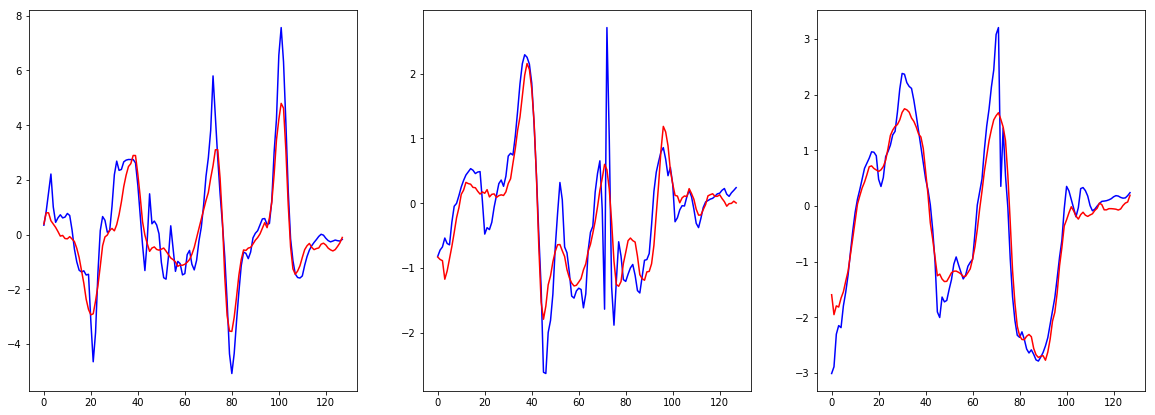

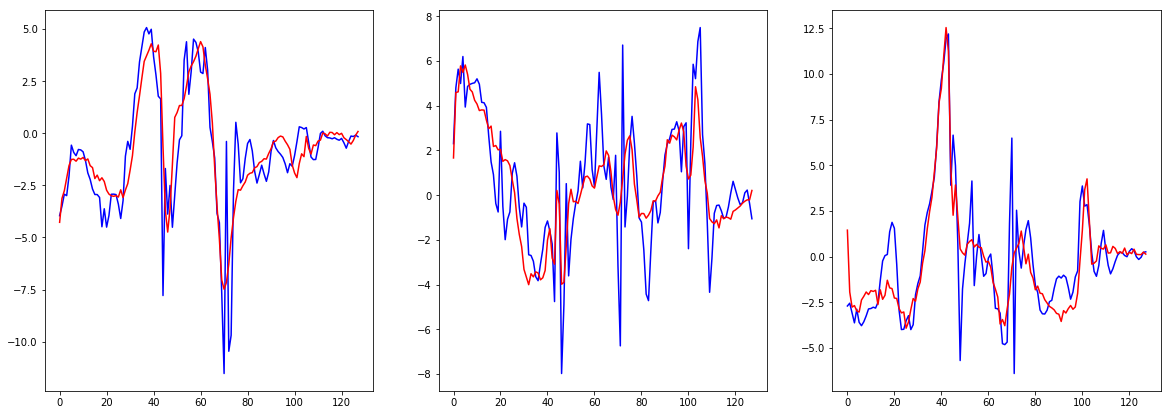

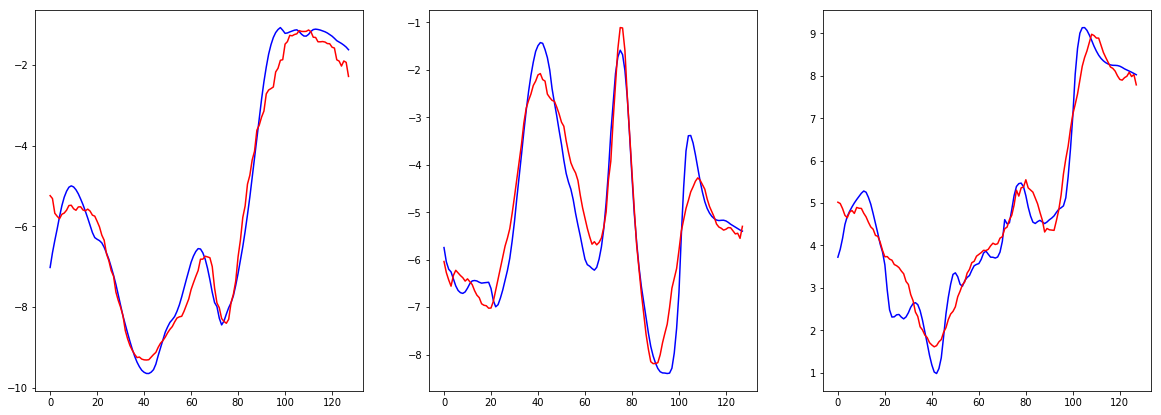

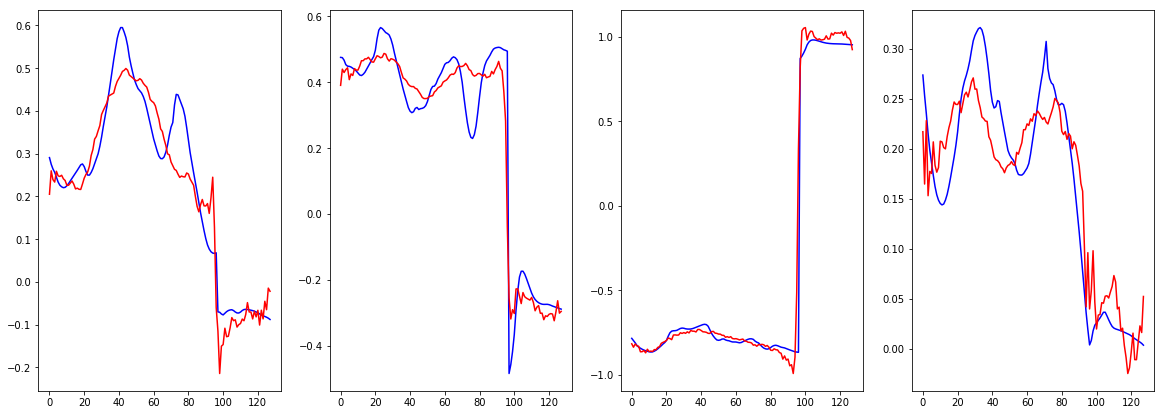

In [220]:
sample = 33
gyroy = gyroModel.predict(gyro_train[sample].reshape(1,128,3))
fig=plt.figure(figsize=(20,7))
for channel in range(3):
    plt.subplot(1,3,channel+1)
    plot(gyro_train[sample,:,channel],'b')
    plot(gyroy[0,:,channel],'r')
linearAccy = linearAccModel.predict(linearAcc_train[sample].reshape(1,128,3))
fig=plt.figure(figsize=(20,7))
for channel in range(3):
    plt.subplot(1,3,channel+1)
    plot(linearAcc_train[sample,:,channel],'b')
    plot(linearAccy[0,:,channel],'r')
gravityy = gravityModel.predict(gravity_train[sample].reshape(1,128,3))
fig=plt.figure(figsize=(20,7))
for channel in range(3):
    plt.subplot(1,3,channel+1)
    plot(gravity_train[sample,:,channel],'b')
    plot(gravityy[0,:,channel],'r')
gameVecy = gameVecModel.predict(gameVec_train[sample].reshape(1,128,4))
fig=plt.figure(figsize=(20,7))
for channel in range(4):
    plt.subplot(1,4,channel+1)
    plot(gameVec_train[sample,:,channel],'b')
    plot(gameVecy[0,:,channel],'r')